# Imports libraries and data

In [1]:
import pandas as pd
import numpy as np
import os
import warnings
warnings.filterwarnings('ignore')
import mritopng
from PIL import Image

import torch

import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from torchvision.models.vgg import vgg19
import sys
sys.path.append('./Zero-Learning-Fast-Medical-Image-Fusion')
from utils import *

import shutil
import tensorflow as tf

current_path = os.getcwd()
data_path = os.path.join(current_path, 'Data\manifest-MjbMt99Q1553106146386120388')
metadata_path = os.path.join(data_path, 'metadata.csv')
info_path = os.path.join(data_path, 'INFOclinical_STS_csv.csv')
# import data
metadata = pd.read_csv(metadata_path)
info = pd.read_csv(info_path)
import cv2

# Helper Functions

In [2]:
def change_labels(label_list, label_ref):
    """
    This function changes the labels from the predicted labels to the original labels
    :param label_list: list of labels to change
    :param label_ref: list of labels to change to
    :return: list of changed labels
    """
    new_labels = []
    for label in label_list:
        new_label = label_ref[label]
        new_labels.append(new_label)
    return new_labels


# EDA and Metadata Pre-proccessing Before Image Pre-proccessing

In [16]:
info.head()

Subject ID      MSKCC type Site of primary STS         Grade   
0    STS_001     Liposarcoma          left thigh          High  \
1    STS_002  Leiomyosarcoma        left buttock          High   
2    STS_003           Other       right buttock  Intermediate   
3    STS_004             MFH         right thigh           Low   
4    STS_005  Leiomyosarcoma         left biceps          High   

   Time - diagnosis to MRI scan (days)  Time - MRI scan to PET scan (days)   
0                                   -7                                   4  \
1                                  -10                                  25   
2                                  -13                                  15   
3                                   -6                                  22   
4                                  -24                                  34   

                               Treatment Outcome (recurrence, mets)   
0  Radiotherapy + Surgery + Chemotherapy                Mets - arms  \
1                 Radiotherapy + Surgery                         --   
2                 Radiotherapy + Surgery                         --   
3                 Radiotherapy + Surgery                         --   
4                 Radiotherapy + Surgery                         --   

  Time - diagnosis to outcome (days) Status (NED, AWD, D)   
0                                266                    D  \
1                                 --                  NED   
2                                 --                  NED   
3                                 --                  NED   
4                                 --                  NED   

   Time - diagnosis to last follow-up (days)  
0                                        845  
1                                        501  
2                                        756  
3                                       1792  
4                                        647

In [17]:
metadata.head()

Series UID           Collection   
0  1.3.6.1.4.1.14519.5.2.1.5168.1900.169505605471...  Soft-tissue-Sarcoma  \
1  1.3.6.1.4.1.14519.5.2.1.5168.1900.236909650266...  Soft-tissue-Sarcoma   
2  1.3.6.1.4.1.14519.5.2.1.5168.1900.269249420684...  Soft-tissue-Sarcoma   
3  1.3.6.1.4.1.14519.5.2.1.5168.1900.267475167888...  Soft-tissue-Sarcoma   
4  1.3.6.1.4.1.14519.5.2.1.5168.1900.147597676388...  Soft-tissue-Sarcoma   

   3rd Party Analysis                           Data Description URI   
0                 NaN  https://doi.org/10.7937/K9/TCIA.2015.7GO2GSKS  \
1                 NaN  https://doi.org/10.7937/K9/TCIA.2015.7GO2GSKS   
2                 NaN  https://doi.org/10.7937/K9/TCIA.2015.7GO2GSKS   
3                 NaN  https://doi.org/10.7937/K9/TCIA.2015.7GO2GSKS   
4                 NaN  https://doi.org/10.7937/K9/TCIA.2015.7GO2GSKS   

  Subject ID                                          Study UID   
0    STS_001  1.3.6.1.4.1.14519.5.2.1.5168.1900.288970202012...  \
1    STS_001  1.3.6.1.4.1.14519.5.2.1.5168.1900.288970202012...   
2    STS_001  1.3.6.1.4.1.14519.5.2.1.5168.1900.288970202012...   
3    STS_001  1.3.6.1.4.1.14519.5.2.1.5168.1900.288970202012...   
4    STS_001  1.3.6.1.4.1.14519.5.2.1.5168.1900.980314374925...   

  Study Description  Study Date              Series Description   
0             THIGH  09-03-2000                      RTstructT1  \
1             THIGH  09-03-2000          AXIAL SE T1 - RESEARCH   
2             THIGH  09-03-2000                    RTstructT2FS   
3             THIGH  09-03-2000  AXIAL SE T2 FAT SAT - RESEARCH   
4            PET CT  09-07-2000          RTstructAlignedT1toPET   

        Manufacturer  Modality            SOP Class Name   
0  MIM Software Inc.  RTSTRUCT  RT Structure Set Storage  \
1            SIEMENS        MR          MR Image Storage   
2  MIM Software Inc.  RTSTRUCT  RT Structure Set Storage   
3            SIEMENS        MR          MR Image Storage   
4  MIM Software Inc.  RTSTRUCT  RT Structure Set Storage   

                   SOP Class UID  Number of Images  File Size   
0  1.2.840.10008.5.1.4.1.1.481.3                 1    1.05 MB  \
1      1.2.840.10008.5.1.4.1.1.4                40   21.06 MB   
2  1.2.840.10008.5.1.4.1.1.481.3                 1  793.95 KB   
3      1.2.840.10008.5.1.4.1.1.4                40   11.89 MB   
4  1.2.840.10008.5.1.4.1.1.481.3                 1    1.22 MB   

                                       File Location       Download Timestamp  
0  .\Soft-tissue-Sarcoma\STS_001\09-03-2000-NA-TH...  2022-12-04T15:17:17.081  
1  .\Soft-tissue-Sarcoma\STS_001\09-03-2000-NA-TH...  2022-12-04T15:17:18.905  
2  .\Soft-tissue-Sarcoma\STS_001\09-03-2000-NA-TH...  2022-12-04T15:17:20.531  
3  .\Soft-tissue-Sarcoma\STS_001\09-03-2000-NA-TH...  2022-12-04T15:17:22.271  
4  .\Soft-tissue-Sarcoma\STS_001\09-07-2000-NA-PE...  2022-12-04T15:17:22.541

## Check how many images per modality

Number of Images
Modality                  
CT                   13607
MR                   10753
PT                   13617
RTSTRUCT               306

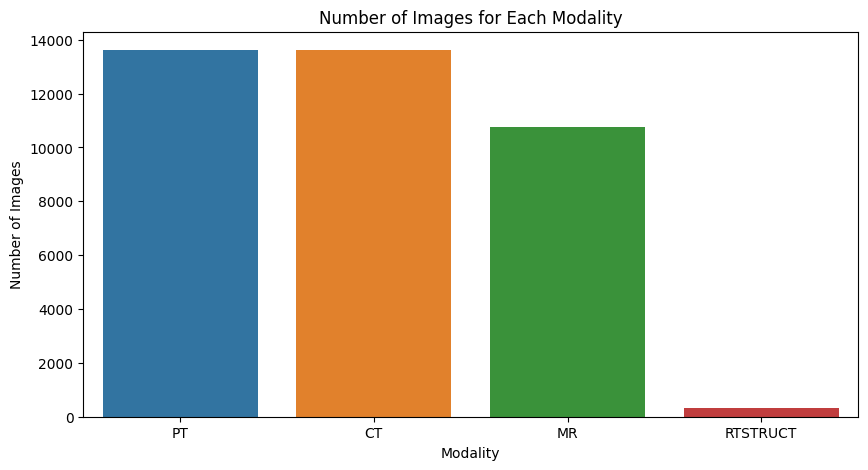

In [18]:
display(metadata[['Number of Images','Modality']].groupby('Modality').sum())
# plot the sum number of images for each modality in ascending order
plt.figure(figsize=(10,5))
sns.barplot(x='Modality', 
            y='Number of Images', 
            data=metadata[['Number of Images','Modality']]
            .groupby('Modality')
            .sum()
            .reset_index()
            .sort_values('Number of Images', ascending=False))
plt.title('Number of Images for Each Modality')
plt.show()

## Check how many subjects per MSKCC type

Subject ID
MSKCC type                            
Extraskeletal bone sarcoma           4
Fibrosarcoma                         1
Leiomyosarcoma                      10
Liposarcoma                         11
MFH                                 17
Other                                3
Synovial sarcoma                     5

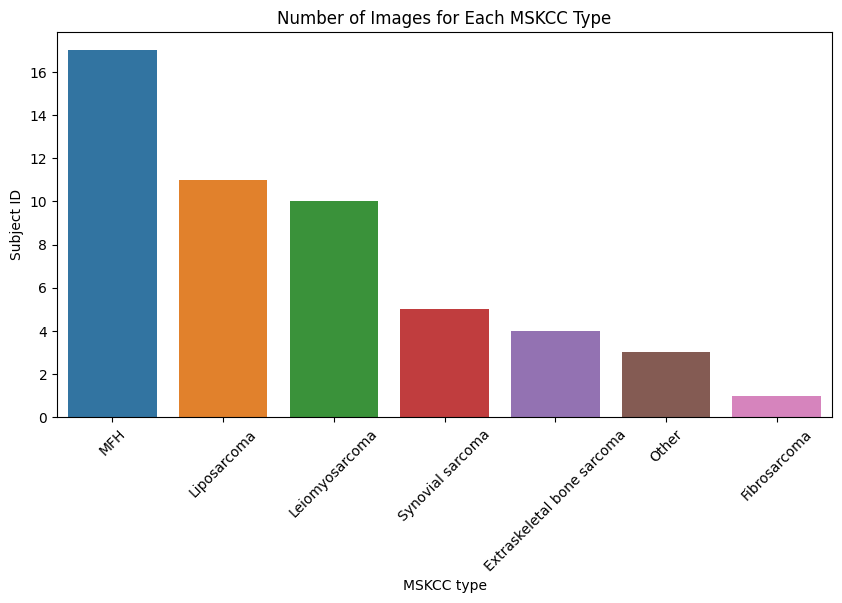

In [19]:
display(info[['Subject ID','MSKCC type']].groupby('MSKCC type').count())
# plot the number of images for each MSKCC type in ascending order
plt.figure(figsize=(10,5))
sns.barplot(x='MSKCC type',
            y='Subject ID',
            data=info[['Subject ID','MSKCC type']]
            .groupby('MSKCC type')
            .count()
            .reset_index()
            .sort_values('Subject ID', ascending=False),)
plt.xticks(rotation=45)
plt.title('Number of Images for Each MSKCC Type')
plt.show()

## Extract relevant columns from both metadataset and join them

In [20]:
meta_extracted = metadata[['Subject ID','Modality','Number of Images', 'File Location','Series Description']]
info_extracted = info[['Subject ID','MSKCC type']]

In [21]:
# join two dataframes
meta_info_join = pd.merge(meta_extracted, info_extracted, on='Subject ID', how='left')

In [22]:
meta_info_join

Subject ID  Modality  Number of Images   
0      STS_001  RTSTRUCT                 1  \
1      STS_001        MR                40   
2      STS_001  RTSTRUCT                 1   
3      STS_001        MR                40   
4      STS_001  RTSTRUCT                 1   
..         ...       ...               ...   
607    STS_051  RTSTRUCT                 1   
608    STS_051        CT               267   
609    STS_051        MR                50   
610    STS_051        MR                52   
611    STS_051        PT               267   

                                         File Location   
0    .\Soft-tissue-Sarcoma\STS_001\09-03-2000-NA-TH...  \
1    .\Soft-tissue-Sarcoma\STS_001\09-03-2000-NA-TH...   
2    .\Soft-tissue-Sarcoma\STS_001\09-03-2000-NA-TH...   
3    .\Soft-tissue-Sarcoma\STS_001\09-03-2000-NA-TH...   
4    .\Soft-tissue-Sarcoma\STS_001\09-07-2000-NA-PE...   
..                                                 ...   
607  .\Soft-tissue-Sarcoma\STS_051\11-05-1999-NA-PE...   
608  .\Soft-tissue-Sarcoma\STS_051\11-05-1999-NA-PE...   
609  .\Soft-tissue-Sarcoma\STS_051\11-05-1999-NA-PE...   
610  .\Soft-tissue-Sarcoma\STS_051\11-05-1999-NA-PE...   
611  .\Soft-tissue-Sarcoma\STS_051\11-05-1999-NA-PE...   

                 Series Description        MSKCC type  
0                        RTstructT1       Liposarcoma  
1            AXIAL SE T1 - RESEARCH       Liposarcoma  
2                      RTstructT2FS       Liposarcoma  
3    AXIAL SE T2 FAT SAT - RESEARCH       Liposarcoma  
4            RTstructAlignedT1toPET       Liposarcoma  
..                              ...               ...  
607                     RTstructPET  Synovial sarcoma  
608     CT IMAGES - LEGS - RESEARCH  Synovial sarcoma  
609               AlignedT1toPETBOX  Synovial sarcoma  
610             AlignedT2FStoPETBOX  Synovial sarcoma  
611                          PET AC  Synovial sarcoma  

[612 rows x 6 columns]

## Extract MRI images and non-PETBOX images

In [23]:
# check MR images
meta_info_extracted = meta_info_join[(meta_info_join['Modality'] == 'MR') & (meta_info_join['Series Description'].str.contains('PETBOX') != True)].reset_index(drop=True)
meta_info_extracted

Subject ID Modality  Number of Images   
0      STS_001       MR                40  \
1      STS_001       MR                40   
2      STS_002       MR                27   
3      STS_002       MR                18   
4      STS_003       MR                36   
..         ...      ...               ...   
97     STS_049       MR                34   
98     STS_050       MR                30   
99     STS_051       MR                48   
100    STS_050       MR                30   
101    STS_051       MR                48   

                                         File Location   
0    .\Soft-tissue-Sarcoma\STS_001\09-03-2000-NA-TH...  \
1    .\Soft-tissue-Sarcoma\STS_001\09-03-2000-NA-TH...   
2    .\Soft-tissue-Sarcoma\STS_002\01-03-2006-NA-L-...   
3    .\Soft-tissue-Sarcoma\STS_002\01-03-2006-NA-L-...   
4    .\Soft-tissue-Sarcoma\STS_003\03-30-2005-NA-MR...   
..                                                 ...   
97   .\Soft-tissue-Sarcoma\STS_049\04-14-2002-NA-MR...   
98   .\Soft-tissue-Sarcoma\STS_050\01-02-2004-NA-IR...   
99   .\Soft-tissue-Sarcoma\STS_051\10-24-1999-NA-B ...   
100  .\Soft-tissue-Sarcoma\STS_050\01-02-2004-NA-IR...   
101  .\Soft-tissue-Sarcoma\STS_051\10-24-1999-NA-B ...   

                       Series Description        MSKCC type  
0                  AXIAL SE T1 - RESEARCH       Liposarcoma  
1          AXIAL SE T2 FAT SAT - RESEARCH       Liposarcoma  
2                                    AXT1    Leiomyosarcoma  
3                          STIR longTE AX    Leiomyosarcoma  
4                                 AX STIR             Other  
..                                    ...               ...  
97   Axial FSET1 LOWER TIB FIB - RESEARCH       Liposarcoma  
98                                AX STIR    Leiomyosarcoma  
99        AXIAL  FSE T2 FATSAT - RESEARCH  Synovial sarcoma  
100                 AXI T1 FSE - RESEARCH    Leiomyosarcoma  
101                   AXIAL  T1- RESEARCH  Synovial sarcoma  

[102 rows x 6 columns]

## Add PNG File Location to the metadataset

In [24]:
#  png files location
file_location = meta_info_extracted['File Location'].tolist()
# add png infront of the file location
new_file_location = [x[:21] + '-png' + x[21:] for x in file_location]
meta_info_extracted['PNG File Location'] = new_file_location

## Get rid of STS_029 due to non-matching images

In [25]:
# Get rid of STS_029 due to non-matching images
meta_info_extracted = meta_info_extracted[meta_info_extracted['Subject ID'] != 'STS_029']

In [26]:
meta_info_extracted

Subject ID Modality  Number of Images   
0      STS_001       MR                40  \
1      STS_001       MR                40   
2      STS_002       MR                27   
3      STS_002       MR                18   
4      STS_003       MR                36   
..         ...      ...               ...   
97     STS_049       MR                34   
98     STS_050       MR                30   
99     STS_051       MR                48   
100    STS_050       MR                30   
101    STS_051       MR                48   

                                         File Location   
0    .\Soft-tissue-Sarcoma\STS_001\09-03-2000-NA-TH...  \
1    .\Soft-tissue-Sarcoma\STS_001\09-03-2000-NA-TH...   
2    .\Soft-tissue-Sarcoma\STS_002\01-03-2006-NA-L-...   
3    .\Soft-tissue-Sarcoma\STS_002\01-03-2006-NA-L-...   
4    .\Soft-tissue-Sarcoma\STS_003\03-30-2005-NA-MR...   
..                                                 ...   
97   .\Soft-tissue-Sarcoma\STS_049\04-14-2002-NA-MR...   
98   .\Soft-tissue-Sarcoma\STS_050\01-02-2004-NA-IR...   
99   .\Soft-tissue-Sarcoma\STS_051\10-24-1999-NA-B ...   
100  .\Soft-tissue-Sarcoma\STS_050\01-02-2004-NA-IR...   
101  .\Soft-tissue-Sarcoma\STS_051\10-24-1999-NA-B ...   

                       Series Description        MSKCC type   
0                  AXIAL SE T1 - RESEARCH       Liposarcoma  \
1          AXIAL SE T2 FAT SAT - RESEARCH       Liposarcoma   
2                                    AXT1    Leiomyosarcoma   
3                          STIR longTE AX    Leiomyosarcoma   
4                                 AX STIR             Other   
..                                    ...               ...   
97   Axial FSET1 LOWER TIB FIB - RESEARCH       Liposarcoma   
98                                AX STIR    Leiomyosarcoma   
99        AXIAL  FSE T2 FATSAT - RESEARCH  Synovial sarcoma   
100                 AXI T1 FSE - RESEARCH    Leiomyosarcoma   
101                   AXIAL  T1- RESEARCH  Synovial sarcoma   

                                     PNG File Location  
0    .\Soft-tissue-Sarcoma-png\STS_001\09-03-2000-N...  
1    .\Soft-tissue-Sarcoma-png\STS_001\09-03-2000-N...  
2    .\Soft-tissue-Sarcoma-png\STS_002\01-03-2006-N...  
3    .\Soft-tissue-Sarcoma-png\STS_002\01-03-2006-N...  
4    .\Soft-tissue-Sarcoma-png\STS_003\03-30-2005-N...  
..                                                 ...  
97   .\Soft-tissue-Sarcoma-png\STS_049\04-14-2002-N...  
98   .\Soft-tissue-Sarcoma-png\STS_050\01-02-2004-N...  
99   .\Soft-tissue-Sarcoma-png\STS_051\10-24-1999-N...  
100  .\Soft-tissue-Sarcoma-png\STS_050\01-02-2004-N...  
101  .\Soft-tissue-Sarcoma-png\STS_051\10-24-1999-N...  

[100 rows x 7 columns]

## Check the number of images per each MSKCC type and modality

Number of Images
Modality MSKCC type                                  
MR       MFH                                     1106
         Liposarcoma                              850
         Leiomyosarcoma                           733
         Synovial sarcoma                         342
         Extraskeletal bone sarcoma               284
         Other                                    176
         Fibrosarcoma                             100

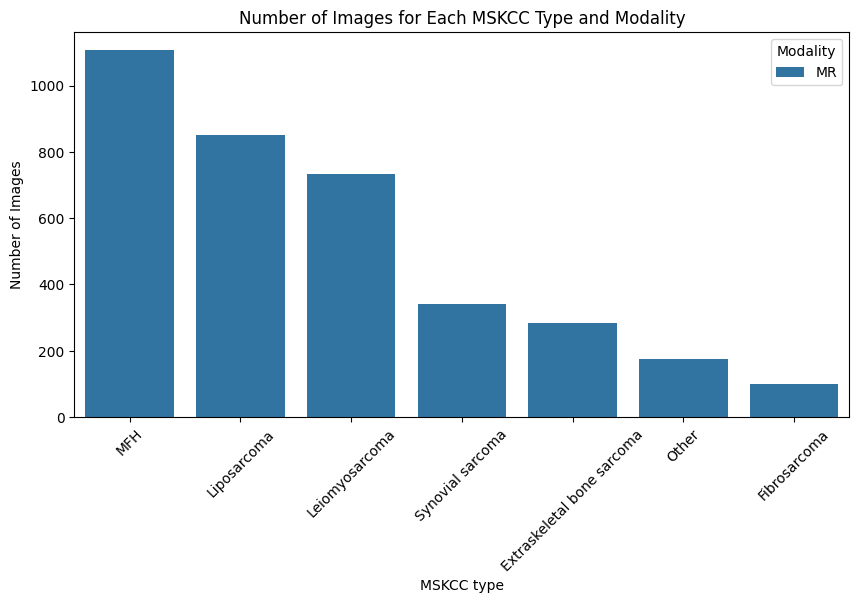

In [27]:
display(meta_info_extracted[['Modality', 'MSKCC type', 'Number of Images']]
 .groupby(['Modality', 'MSKCC type'])
 .sum()
 .sort_values('Number of Images', ascending=False))
#  plot 
plt.figure(figsize=(10,5))
sns.barplot(x='MSKCC type',
            y='Number of Images',
            hue='Modality',
            data=meta_info_extracted[['Modality', 'MSKCC type', 'Number of Images']]
            .groupby(['Modality', 'MSKCC type'])
            .sum()
            .reset_index()
            .sort_values('Number of Images', ascending=False))
plt.xticks(rotation=45)
plt.title('Number of Images for Each MSKCC Type and Modality')
plt.show()

## Checkpoint creation #1

In [40]:
# Checkpoint 1: meta_info_extracted
meta_info_extracted.to_csv('csv_checkpoints\\meta_info_extracted-1.csv', index=False)

# Image Pre-proccessing

## Resume from checkpoint #1

In [42]:
# Restore checkpoint 1
meta_info_extracted = pd.read_csv('csv_checkpoints\\meta_info_extracted-1.csv')

## Convert dicom to png

In [43]:
meta_info_extracted

Subject ID Modality  Number of Images   
0     STS_001       MR                40  \
1     STS_001       MR                40   
2     STS_002       MR                27   
3     STS_002       MR                18   
4     STS_003       MR                36   
..        ...      ...               ...   
95    STS_049       MR                34   
96    STS_050       MR                30   
97    STS_051       MR                48   
98    STS_050       MR                30   
99    STS_051       MR                48   

                                        File Location   
0   .\Soft-tissue-Sarcoma\STS_001\09-03-2000-NA-TH...  \
1   .\Soft-tissue-Sarcoma\STS_001\09-03-2000-NA-TH...   
2   .\Soft-tissue-Sarcoma\STS_002\01-03-2006-NA-L-...   
3   .\Soft-tissue-Sarcoma\STS_002\01-03-2006-NA-L-...   
4   .\Soft-tissue-Sarcoma\STS_003\03-30-2005-NA-MR...   
..                                                ...   
95  .\Soft-tissue-Sarcoma\STS_049\04-14-2002-NA-MR...   
96  .\Soft-tissue-Sarcoma\STS_050\01-02-2004-NA-IR...   
97  .\Soft-tissue-Sarcoma\STS_051\10-24-1999-NA-B ...   
98  .\Soft-tissue-Sarcoma\STS_050\01-02-2004-NA-IR...   
99  .\Soft-tissue-Sarcoma\STS_051\10-24-1999-NA-B ...   

                      Series Description        MSKCC type   
0                 AXIAL SE T1 - RESEARCH       Liposarcoma  \
1         AXIAL SE T2 FAT SAT - RESEARCH       Liposarcoma   
2                                   AXT1    Leiomyosarcoma   
3                         STIR longTE AX    Leiomyosarcoma   
4                                AX STIR             Other   
..                                   ...               ...   
95  Axial FSET1 LOWER TIB FIB - RESEARCH       Liposarcoma   
96                               AX STIR    Leiomyosarcoma   
97       AXIAL  FSE T2 FATSAT - RESEARCH  Synovial sarcoma   
98                 AXI T1 FSE - RESEARCH    Leiomyosarcoma   
99                   AXIAL  T1- RESEARCH  Synovial sarcoma   

                                    PNG File Location  
0   .\Soft-tissue-Sarcoma-png\STS_001\09-03-2000-N...  
1   .\Soft-tissue-Sarcoma-png\STS_001\09-03-2000-N...  
2   .\Soft-tissue-Sarcoma-png\STS_002\01-03-2006-N...  
3   .\Soft-tissue-Sarcoma-png\STS_002\01-03-2006-N...  
4   .\Soft-tissue-Sarcoma-png\STS_003\03-30-2005-N...  
..                                                ...  
95  .\Soft-tissue-Sarcoma-png\STS_049\04-14-2002-N...  
96  .\Soft-tissue-Sarcoma-png\STS_050\01-02-2004-N...  
97  .\Soft-tissue-Sarcoma-png\STS_051\10-24-1999-N...  
98  .\Soft-tissue-Sarcoma-png\STS_050\01-02-2004-N...  
99  .\Soft-tissue-Sarcoma-png\STS_051\10-24-1999-N...  

[100 rows x 7 columns]

In [44]:
for i in range(len(meta_info_extracted)):
    try:
        mritopng.convert_folder(os.path.join(data_path, meta_info_extracted['File Location'].iloc[i])
                                , os.path.join(data_path, meta_info_extracted['PNG File Location'].iloc[i]))
    except:
        print(meta_info_extracted['File Location'].iloc[i], 'already converted')

.\Soft-tissue-Sarcoma\STS_001\09-03-2000-NA-THIGH-48623\11.000000-AXIAL SE T1 - RESEARCH-12555 already converted
.\Soft-tissue-Sarcoma\STS_001\09-03-2000-NA-THIGH-48623\10.000000-AXIAL SE T2 FAT SAT - RESEARCH-62438 already converted
.\Soft-tissue-Sarcoma\STS_002\01-03-2006-NA-L-SPINE-56934\501.000000-AXT1-02298 already converted
.\Soft-tissue-Sarcoma\STS_002\01-03-2006-NA-L-SPINE-56934\701.000000-STIR longTE AX-10990 already converted
.\Soft-tissue-Sarcoma\STS_003\03-30-2005-NA-MRI PELVIS C- C-15534\4.000000-AX STIR-73168 already converted
.\Soft-tissue-Sarcoma\STS_003\03-30-2005-NA-MRI PELVIS C- C-15534\5.000000-AX T1-51267 already converted
.\Soft-tissue-Sarcoma\STS_004\09-30-1999-NA-RIGHT THIGH C-81525\501.000000-T2ST RT - RESEARCH-20620 already converted
.\Soft-tissue-Sarcoma\STS_004\09-30-1999-NA-RIGHT THIGH C-81525\601.000000-T1 RT - RESEARCH-86077 already converted
.\Soft-tissue-Sarcoma\STS_005\05-29-2005-NA-IRM BRAS GAUCHE C-C-94418\3.000000-AXIALT1-40756 already converted
.\S

## Add Parent Directory to the metadataset

In [45]:
#  save original path
original_path = os.getcwd()

#  add a column that contain the parent directory
meta_info_extracted['Parent Directory'] = meta_info_extracted['PNG File Location'].apply(lambda x: os.path.join(data_path, x))
for i in range(len(meta_info_extracted)):
    #  move up one directory
    os.chdir(meta_info_extracted['Parent Directory'].iloc[i])
    os.chdir('..')
    #  record the child directory into the column
    parent_directory = os.getcwd()
    rel_parent_directory = os.path.relpath(parent_directory, start=data_path)
    meta_info_extracted['Parent Directory'].iloc[i] = ".\\" + rel_parent_directory

#  move back to original directory
os.chdir(original_path)

## M - Cleaned the pictures manually due to extra images that can impact image fusing

## Update file name and remove orignal file column

In [46]:
#  change the word Soft-tissue-Sarcoma-png to Soft-tissue-Sarcoma-png - Manual Cleaning
meta_info_extracted['PNG File Location'] = meta_info_extracted['PNG File Location'].str.replace('Soft-tissue-Sarcoma-png', 'STS - Manual Cleaning')
meta_info_extracted['Parent Directory'] = meta_info_extracted['Parent Directory'].str.replace('Soft-tissue-Sarcoma-png', 'STS - Manual Cleaning')
# remove image file column
meta_info_extracted = meta_info_extracted.drop(columns=['File Location'])

## Update image number

In [47]:
# join png file location with data directory and update number of images based on png files
meta_info_extracted['Number of Images'] = (meta_info_extracted['PNG File Location']
                                      .apply(lambda x: os.path.join(data_path, x))
                                      .apply(lambda x: len(os.listdir(x))))

In [48]:
meta_info_extracted

Subject ID Modality  Number of Images   
0     STS_001       MR                40  \
1     STS_001       MR                40   
2     STS_002       MR                15   
3     STS_002       MR                15   
4     STS_003       MR                36   
..        ...      ...               ...   
95    STS_049       MR                34   
96    STS_050       MR                30   
97    STS_051       MR                48   
98    STS_050       MR                30   
99    STS_051       MR                48   

                      Series Description        MSKCC type   
0                 AXIAL SE T1 - RESEARCH       Liposarcoma  \
1         AXIAL SE T2 FAT SAT - RESEARCH       Liposarcoma   
2                                   AXT1    Leiomyosarcoma   
3                         STIR longTE AX    Leiomyosarcoma   
4                                AX STIR             Other   
..                                   ...               ...   
95  Axial FSET1 LOWER TIB FIB - RESEARCH       Liposarcoma   
96                               AX STIR    Leiomyosarcoma   
97       AXIAL  FSE T2 FATSAT - RESEARCH  Synovial sarcoma   
98                 AXI T1 FSE - RESEARCH    Leiomyosarcoma   
99                   AXIAL  T1- RESEARCH  Synovial sarcoma   

                                    PNG File Location   
0   .\STS - Manual Cleaning\STS_001\09-03-2000-NA-...  \
1   .\STS - Manual Cleaning\STS_001\09-03-2000-NA-...   
2   .\STS - Manual Cleaning\STS_002\01-03-2006-NA-...   
3   .\STS - Manual Cleaning\STS_002\01-03-2006-NA-...   
4   .\STS - Manual Cleaning\STS_003\03-30-2005-NA-...   
..                                                ...   
95  .\STS - Manual Cleaning\STS_049\04-14-2002-NA-...   
96  .\STS - Manual Cleaning\STS_050\01-02-2004-NA-...   
97  .\STS - Manual Cleaning\STS_051\10-24-1999-NA-...   
98  .\STS - Manual Cleaning\STS_050\01-02-2004-NA-...   
99  .\STS - Manual Cleaning\STS_051\10-24-1999-NA-...   

                                     Parent Directory  
0   .\STS - Manual Cleaning\STS_001\09-03-2000-NA-...  
1   .\STS - Manual Cleaning\STS_001\09-03-2000-NA-...  
2   .\STS - Manual Cleaning\STS_002\01-03-2006-NA-...  
3   .\STS - Manual Cleaning\STS_002\01-03-2006-NA-...  
4   .\STS - Manual Cleaning\STS_003\03-30-2005-NA-...  
..                                                ...  
95  .\STS - Manual Cleaning\STS_049\04-14-2002-NA-...  
96  .\STS - Manual Cleaning\STS_050\01-02-2004-NA-...  
97  .\STS - Manual Cleaning\STS_051\10-24-1999-NA-...  
98  .\STS - Manual Cleaning\STS_050\01-02-2004-NA-...  
99  .\STS - Manual Cleaning\STS_051\10-24-1999-NA-...  

[100 rows x 7 columns]

## Checkpoint creation #2

In [49]:
# Checkpoint 2: meta_info_extracted
meta_info_extracted.to_csv('csv_checkpoints\\meta_info_extracted-2.csv', index=False)

## Resizing images

## Resuming from checkpoint #2

In [ ]:
# Restore checkpoint 2
meta_info_extracted = pd.read_csv('csv_checkpoints\\meta_info_extracted-2.csv')

In [51]:
#  for each image in the png file location, resize to 224x224
for i in range(len(meta_info_extracted)):
    # png file location
    png_file_location = os.path.join(data_path, meta_info_extracted['PNG File Location'].iloc[i])
    image_list = os.listdir(png_file_location)
    for image in image_list:
        #  open image
        im = Image.open(os.path.join(png_file_location, image))
        #  resize image
        im = im.resize((224, 224))
        #  save image
        im.save(os.path.join(png_file_location, image))

## Fuse images

In [52]:
# pretrained model
def fuse_images(image_1_path, image_2_path, output_path):
    def imread(image, mode):
        return np.array(Image.open(image).convert(mode))
    if torch.cuda.is_available():
        device = torch.device('cuda:0')
    else:
        device = torch.device('cpu')
    r1, eps1, r2, eps2 = 45, 0.01, 7, 1e-6
    model = vgg19(pretrained=True)
    vgg19_relus = [1, 3, 8]

    # path_to_images = ['images/IV_images/1-38.dcm.png', 'images/IV_images/1-38.dcm - Copy.png']
    path_to_images = [image_1_path, image_2_path]

    imgs = [imread(p, mode='L') for p in path_to_images]

    float_imgs = [(img / 255.).astype(np.float32) for img in imgs]
    bases, details = decompose(float_imgs)

    Wb_0 = sal_weights(imgs)
    Wb_0 = np.moveaxis(Wb_0, -1, 0)  # easier indexed in for-loop
    Wb = guided_optimize(float_imgs, Wb_0, r1, eps1)

    fused_base = weighted_sum(bases, Wb)

    tc_details = stack_to_tensor(details)
    fused_detial = cnn_detail_fusion(tc_details, model, device, relus=vgg19_relus)

    fused = np.clip(fused_base + fused_detial, 0, 1)
    fused = np.rint(fused * 255).astype(np.uint8)
    
    # save image in output path
    im = Image.fromarray(fused)
    im.save(output_path)

In [55]:
# create fuse column and have everything as false
meta_info_extracted['Fuse'] = False
while False in meta_info_extracted['Fuse'].tolist():
    #  check for the first row that is not fused
    first_fuse_row = meta_info_extracted[meta_info_extracted['Fuse'] == False].iloc[0]
    #  check for the rows that has the same parent directory and different png file location
    try:
        second_fuse_row = meta_info_extracted[(meta_info_extracted['Parent Directory'] == first_fuse_row['Parent Directory'])
                                         & (meta_info_extracted['PNG File Location'] != first_fuse_row['PNG File Location'])].iloc[0]
        if second_fuse_row.empty:
            raise Exception('Fuse Rows not found')
    except Exception as e:
        print(str(e))
    
    # fusing operations -------------------------------------------------------------------
    # list of images in the first row
    first_row_images = os.listdir(os.path.join(data_path, first_fuse_row['PNG File Location'][2:]))
    # list of images in the second row
    second_row_images = os.listdir(os.path.join(data_path, second_fuse_row['PNG File Location'][2:]))
    # make directory for fused images
    os.makedirs(os.path.join(data_path, first_fuse_row['Parent Directory'], 'fused'), exist_ok=True)
    for image_index in range(len(first_row_images)):
        image_number = image_index + 1
        image_number = str(image_number).zfill(3)
        fuse_image_name = 'fused-' + image_number + '.png'
        #  fuse the images
        if os.path.exists(os.path.join(data_path, first_fuse_row['PNG File Location'][2:], first_row_images[image_index])) and os.path.exists(os.path.join(data_path, second_fuse_row['PNG File Location'][2:], second_row_images[image_index])):
            # if the fused image does not exist
            if not os.path.exists(os.path.join(data_path, first_fuse_row['Parent Directory'], 'fused', fuse_image_name)):
                fuse_images(os.path.join(data_path, first_fuse_row['PNG File Location'][2:], first_row_images[image_index]),
                            os.path.join(data_path, second_fuse_row['PNG File Location'][2:], second_row_images[image_index]),
                            os.path.join(data_path, first_fuse_row['Parent Directory'], 'fused', fuse_image_name))
    # end of fusing operations ------------------------------------------------------------
    
    #  change fuse to true for every parent directory that has the same parent directory
    meta_info_extracted.loc[meta_info_extracted['Parent Directory'] == first_fuse_row['Parent Directory'], 'Fuse'] = True

#  remove fuse column
meta_info_extracted = meta_info_extracted.drop('Fuse', axis=1)

In [56]:
#  create a new dataframe that contains the parent directory of the fused images
meta_info_fused = meta_info_extracted.drop_duplicates(subset=['Parent Directory'])

meta_info_fused.drop(['PNG File Location', 'Modality'], axis=1, inplace=True)
#  add fused after the parent direcotry
meta_info_fused['Parent Directory'] = meta_info_fused['Parent Directory'] + '\\fused'
# rename parent directory to fused image directory
meta_info_fused.rename(columns={'Parent Directory': 'Fused Image Directory'}, inplace=True)
# update image count based on the number of images in the fused image directory
try:
    for i in range(len(meta_info_fused)):
        meta_info_fused['Number of Images'].iloc[i] = len(os.listdir(os.path.join(data_path, meta_info_fused['Fused Image Directory'].iloc[i][2:])))
except:
    print('Error in updating image count')

## Checkpoint creation #3

In [58]:
#check point 3
meta_info_fused.to_csv( 'csv_checkpoints\\meta_info_fused-3.csv', index=False)

## Resuming from checkpoint #3

In [5]:
# resume from check point 3
meta_info_fused = pd.read_csv('csv_checkpoints\\meta_info_fused-3.csv')

## Number of Images in each MSKCC type after fusing

Number of Images
MSKCC type                                  
MFH                                      547
Liposarcoma                              421
Leiomyosarcoma                           359
Synovial sarcoma                         171
Extraskeletal bone sarcoma               142
Other                                     88
Fibrosarcoma                              50

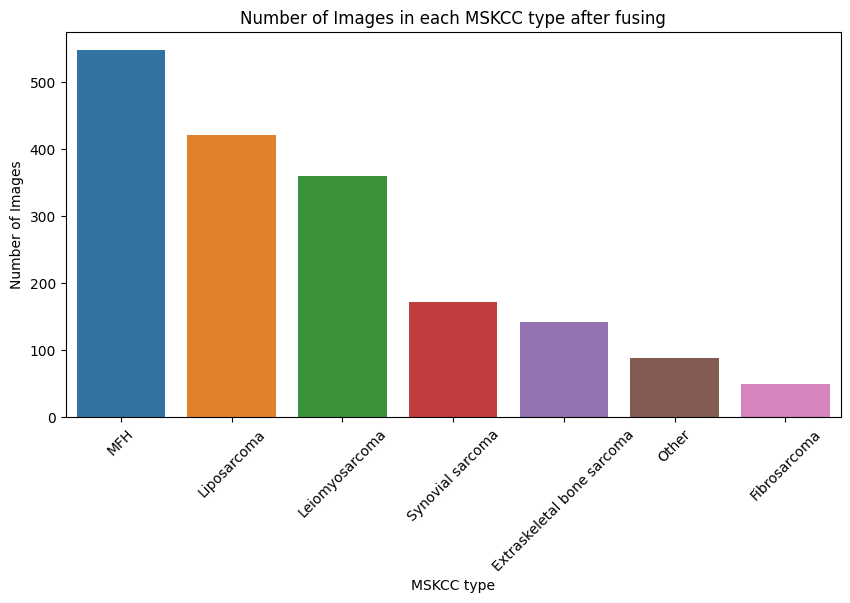

Number of Images
MSKCC type                                  
MFH                                      547
Liposarcoma                              421
Leiomyosarcoma                           359
Synovial sarcoma                         171
Extraskeletal bone sarcoma               142
Other                                     88
Fibrosarcoma                              50

In [30]:
#  count number of images in based on the MSKCC type after fusing
display(meta_info_fused[['MSKCC type', 'Number of Images']].groupby('MSKCC type').sum().sort_values(by='Number of Images', ascending=False))

#  plot
plt.figure(figsize=(10, 5))
sns.barplot(x=meta_info_fused[['MSKCC type', 'Number of Images']].groupby('MSKCC type').sum().sort_values(by='Number of Images', ascending=False).index,
            y=meta_info_fused[['MSKCC type', 'Number of Images']].groupby('MSKCC type').sum().sort_values(by='Number of Images', ascending=False)['Number of Images'])
plt.xticks(rotation=45)
plt.title('Number of Images in each MSKCC type after fusing')
plt.xlabel('MSKCC type')
plt.ylabel('Number of Images')
plt.show()
display(meta_info_fused[['MSKCC type', 'Number of Images']].groupby('MSKCC type').sum().sort_values(by='Number of Images', ascending=False))

## Combine Fibrosarcoma to Other

In [31]:
# Combine Fibrosarcoma to Other
meta_info_fused.loc[meta_info_fused['MSKCC type'] == 'Fibrosarcoma', 'MSKCC type'] = 'Other'

Number of Images
MSKCC type                                  
MFH                                      547
Liposarcoma                              421
Leiomyosarcoma                           359
Synovial sarcoma                         171
Extraskeletal bone sarcoma               142
Other                                    138

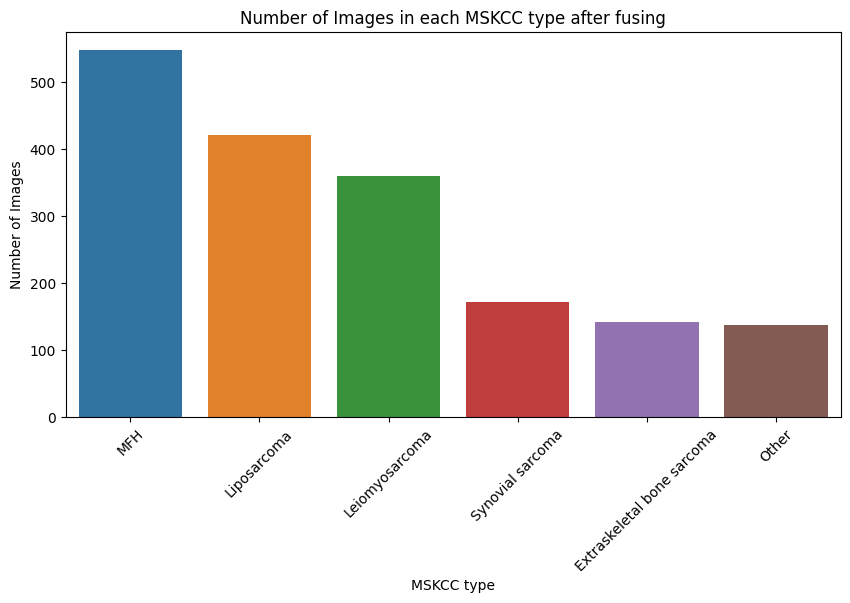

In [49]:
#  count number of images in based on the MSKCC type after fusing
display(meta_info_fused[['MSKCC type', 'Number of Images']].groupby('MSKCC type').sum().sort_values(by='Number of Images', ascending=False))

#  plot
plt.figure(figsize=(10, 5))
sns.barplot(x=meta_info_fused[['MSKCC type', 'Number of Images']].groupby('MSKCC type').sum().sort_values(by='Number of Images', ascending=False).index,
            y=meta_info_fused[['MSKCC type', 'Number of Images']].groupby('MSKCC type').sum().sort_values(by='Number of Images', ascending=False)['Number of Images'])
plt.xticks(rotation=45)
plt.title('Number of Images in each MSKCC type after fusing')
plt.xlabel('MSKCC type')
plt.ylabel('Number of Images')
plt.show()

##  Transfer images from their respectve directories to the folder that corresponds to their MSKCC type

In [33]:
#  transfer images from their respectve directories to the folder that corresponds to their MSKCC type
new_data_path = os.path.join(data_path, 'STS-Classes-6')

leiomyosarcoma_index = 1
MFH_index = 1
liposarcoma_index = 1
SS_index = 1
EBS_index = 1
fibrosarcoma_index = 1
other_index = 1

for i in range(len(meta_info_fused)):
    #  create the new directory for the image
    os.makedirs(os.path.join(new_data_path, meta_info_fused['MSKCC type'].iloc[i]), exist_ok=True)
    #  get the list of images in the fused image directory
    image_list = os.listdir(os.path.join(data_path, meta_info_fused['Fused Image Directory'].iloc[i][2:]))
    for image in image_list:
        try:
            #  transfer the image to the new directory
            shutil.copy(os.path.join(data_path, meta_info_fused['Fused Image Directory'].iloc[i][2:], image),
                        os.path.join(new_data_path, meta_info_fused['MSKCC type'].iloc[i], image))
            # rename the image
            if meta_info_fused['MSKCC type'].iloc[i] == 'Leiomyosarcoma':
                # zfill to 4 digits and add the index
                image_number = str(leiomyosarcoma_index).zfill(4)
                os.rename(os.path.join(new_data_path, meta_info_fused['MSKCC type'].iloc[i], image),
                            os.path.join(new_data_path, meta_info_fused['MSKCC type'].iloc[i], 'Leiomyosarcoma-' + image_number + '.png'))
                leiomyosarcoma_index += 1
            elif meta_info_fused['MSKCC type'].iloc[i] == 'MFH':
                # zfill to 4 digits and add the index
                image_number = str(MFH_index).zfill(4)
                os.rename(os.path.join(new_data_path, meta_info_fused['MSKCC type'].iloc[i], image),
                            os.path.join(new_data_path, meta_info_fused['MSKCC type'].iloc[i], 'MFH-' + image_number + '.png'))
                MFH_index += 1
            elif meta_info_fused['MSKCC type'].iloc[i] == 'Liposarcoma':
                # zfill to 4 digits and add the index
                image_number = str(liposarcoma_index).zfill(4)
                os.rename(os.path.join(new_data_path, meta_info_fused['MSKCC type'].iloc[i], image),
                            os.path.join(new_data_path, meta_info_fused['MSKCC type'].iloc[i], 'Liposarcoma-' + image_number + '.png'))
                liposarcoma_index += 1
            elif meta_info_fused['MSKCC type'].iloc[i] == 'Synovial sarcoma':
                # zfill to 4 digits and add the index
                image_number = str(SS_index).zfill(4)
                os.rename(os.path.join(new_data_path, meta_info_fused['MSKCC type'].iloc[i], image),
                            os.path.join(new_data_path, meta_info_fused['MSKCC type'].iloc[i], 'Synovial Sarcoma-' + image_number + '.png'))
                SS_index += 1
            elif meta_info_fused['MSKCC type'].iloc[i] == 'Extraskeletal bone sarcoma':
                # zfill to 4 digits and add the index
                image_number = str(EBS_index).zfill(4)
                os.rename(os.path.join(new_data_path, meta_info_fused['MSKCC type'].iloc[i], image),
                            os.path.join(new_data_path, meta_info_fused['MSKCC type'].iloc[i], 'Extraskeletal Bone Sarcoma-' + image_number + '.png'))
                EBS_index += 1
            elif meta_info_fused['MSKCC type'].iloc[i] == 'Fibrosarcoma':
                # zfill to 4 digits and add the index
                image_number = str(fibrosarcoma_index).zfill(4)
                os.rename(os.path.join(new_data_path, meta_info_fused['MSKCC type'].iloc[i], image),
                            os.path.join(new_data_path, meta_info_fused['MSKCC type'].iloc[i], 'Fibrosarcoma-' + image_number + '.png'))
                fibrosarcoma_index += 1
            elif meta_info_fused['MSKCC type'].iloc[i] == 'Other':
                # zfill to 4 digits and add the index
                image_number = str(other_index).zfill(4)
                os.rename(os.path.join(new_data_path, meta_info_fused['MSKCC type'].iloc[i], image),
                            os.path.join(new_data_path, meta_info_fused['MSKCC type'].iloc[i], 'Other-' + image_number + '.png'))
                other_index += 1           
        except:
            continue

# Deep Learning Model Development

## GPU Check 

In [34]:
# Check for GPU availability
gpu_devices = tf.config.list_physical_devices("GPU")
if gpu_devices:
    for device in gpu_devices:
        print("GPU:", device)
else:
    print("No GPU available.")

# Verify GPU usage in TensorFlow
tf.config.list_physical_devices('GPU')

GPU: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## Import Libraries define metrics and y columns

In [35]:
#  import train test split
from sklearn.model_selection import train_test_split

#  import metrics
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score,classification_report, accuracy_score

# for hyperparameter tuning
#  keras tuner random search
from kerastuner.tuners import RandomSearch
#  import HyperModel
from kerastuner import HyperModel

# cross validation
from sklearn.model_selection import StratifiedKFold

# imlearn for oversampling
from imblearn.over_sampling import RandomOverSampler

In [36]:
def microprecision(y_true, y_pred):
    true_positives = tf.reduce_sum(tf.round(tf.clip_by_value(y_true * y_pred, 0, 1)))
    predicted_positives = tf.reduce_sum(tf.round(tf.clip_by_value(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + tf.keras.backend.epsilon())
    return precision

In [37]:
def macroprecision(y_true, y_pred):
    true_positives = tf.reduce_sum(tf.round(tf.clip_by_value(y_true * y_pred, 0, 1)), axis=0)
    predicted_positives = tf.reduce_sum(tf.round(tf.clip_by_value(y_pred, 0, 1)), axis=0)
    precision = true_positives / (predicted_positives + tf.keras.backend.epsilon())
    macro_precision = tf.reduce_mean(precision)
    return macro_precision

In [38]:
# left out: 'Fibrosarcoma'
y_columns = ['Leiomyosarcoma', 'MFH', 'Liposarcoma', 'Synovial sarcoma', 'Extraskeletal bone sarcoma', 'Other']

In [39]:
PAT = 15
TUNING_PAT =5

## Image dataset preparation

### Create image_df

In [67]:
# import images from the new data path and do train test split, with their directory as their label
new_data_path = os.path.join(data_path, 'STS-Classes-6')
#  get the list of images
image_list = []
label_list = []
for root, dirs, files in os.walk(new_data_path):
    for file in files:
        if file.endswith('.png'):
            image_list.append(os.path.join(root, file))
            label_list.append(root.split('\\')[-1])

#  create a dataframe that contains the image path and their label
image_df = pd.DataFrame({'Image Path': image_list, 'Label': label_list})

# scramble the data random state 42
image_df = image_df.sample(frac=1, random_state=42).reset_index(drop=True)

In [68]:
image_df

Image Path           Label
0     c:\Users\User\Desktop\repo\OVERSAMPLING TEST\S...             MFH
1     c:\Users\User\Desktop\repo\OVERSAMPLING TEST\S...  Leiomyosarcoma
2     c:\Users\User\Desktop\repo\OVERSAMPLING TEST\S...           Other
3     c:\Users\User\Desktop\repo\OVERSAMPLING TEST\S...     Liposarcoma
4     c:\Users\User\Desktop\repo\OVERSAMPLING TEST\S...  Leiomyosarcoma
...                                                 ...             ...
1773  c:\Users\User\Desktop\repo\OVERSAMPLING TEST\S...             MFH
1774  c:\Users\User\Desktop\repo\OVERSAMPLING TEST\S...             MFH
1775  c:\Users\User\Desktop\repo\OVERSAMPLING TEST\S...     Liposarcoma
1776  c:\Users\User\Desktop\repo\OVERSAMPLING TEST\S...             MFH
1777  c:\Users\User\Desktop\repo\OVERSAMPLING TEST\S...             MFH

[1778 rows x 2 columns]

### Train test split

In [69]:
#  split the data into train and test
train_df, test_df = train_test_split(image_df, test_size=0.2, random_state=42, stratify=image_df['Label'])

#  one hot encode the labels
train_df = pd.concat([train_df, pd.get_dummies(train_df['Label'])], axis=1)
test_df = pd.concat([test_df, pd.get_dummies(test_df['Label'])], axis=1)

In [70]:
# check the distribution of the labels
train_df['Label'].value_counts()

Label
MFH                           437
Liposarcoma                   337
Leiomyosarcoma                287
Synovial sarcoma              137
Extraskeletal bone sarcoma    114
Other                         110
Name: count, dtype: int64

### Resolving class imbalance

In [71]:
# random oversampling
ros = RandomOverSampler(random_state=42)
train_df, _ = ros.fit_resample(train_df, train_df['Label'])   

In [72]:
train_df

Image Path             Label   
0     c:\Users\User\Desktop\repo\OVERSAMPLING TEST\S...    Leiomyosarcoma  \
1     c:\Users\User\Desktop\repo\OVERSAMPLING TEST\S...               MFH   
2     c:\Users\User\Desktop\repo\OVERSAMPLING TEST\S...    Leiomyosarcoma   
3     c:\Users\User\Desktop\repo\OVERSAMPLING TEST\S...             Other   
4     c:\Users\User\Desktop\repo\OVERSAMPLING TEST\S...       Liposarcoma   
...                                                 ...               ...   
2617  c:\Users\User\Desktop\repo\OVERSAMPLING TEST\S...  Synovial sarcoma   
2618  c:\Users\User\Desktop\repo\OVERSAMPLING TEST\S...  Synovial sarcoma   
2619  c:\Users\User\Desktop\repo\OVERSAMPLING TEST\S...  Synovial sarcoma   
2620  c:\Users\User\Desktop\repo\OVERSAMPLING TEST\S...  Synovial sarcoma   
2621  c:\Users\User\Desktop\repo\OVERSAMPLING TEST\S...  Synovial sarcoma   

      Extraskeletal bone sarcoma  Leiomyosarcoma  Liposarcoma    MFH  Other   
0                          False            True        False  False  False  \
1                          False           False        False   True  False   
2                          False            True        False  False  False   
3                          False           False        False  False   True   
4                          False           False         True  False  False   
...                          ...             ...          ...    ...    ...   
2617                       False           False        False  False  False   
2618                       False           False        False  False  False   
2619                       False           False        False  False  False   
2620                       False           False        False  False  False   
2621                       False           False        False  False  False   

      Synovial sarcoma  
0                False  
1                False  
2                False  
3                False  
4                False  
...                ...  
2617              True  
2618              True  
2619              True  
2620              True  
2621              True  

[2622 rows x 8 columns]

In [73]:
# check the distribution of the labels
train_df['Label'].value_counts()

Label
Leiomyosarcoma                437
MFH                           437
Other                         437
Liposarcoma                   437
Extraskeletal bone sarcoma    437
Synovial sarcoma              437
Name: count, dtype: int64

### Data Generator with Image Augmentation

In [74]:
#  create the image data generator
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    rotation_range=90,
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=[0.5, 1.5],
    zoom_range=[0.5, 1.5],
    fill_mode='nearest',
)


test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255
)
#  create the train, validation and test generators
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='Image Path',
    y_col= y_columns,
    target_size=(224, 224),
    batch_size=32,
    class_mode='raw',
    shuffle=True,
    seed=42
)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='Image Path',
    y_col= y_columns,
    target_size=(224, 224),
    batch_size=32,
    class_mode='raw',
    shuffle=False
)

train_generator.reset()
test_generator.reset()

Found 2622 validated image filenames.
Found 356 validated image filenames.


##  VGG-16 Model

In [75]:
#  create the model vgg16
vgg16 = tf.keras.applications.VGG16(
    include_top=False,
    weights='imagenet',
    input_shape=(224, 224, 3)
)

#  freeze the layers
vgg16.trainable = False

### VGG-16 attempt without hyperparameter tuning

#### Model Building

In [76]:
# create the model
model = tf.keras.models.Sequential([
    vgg16,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(6, activation='softmax')
])

#  compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=[tf.keras.metrics.CategoricalAccuracy(), macroprecision, microprecision]
)

#  create the callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=PAT,
    restore_best_weights=True
)

# create the model checkpoint
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath='tf_checkpoints\\VGG-16\\model_checkpoint',
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=True
)

# reset the generators
train_generator.reset()
test_generator.reset()

# fit the model
history = model.fit(
    train_generator,
    validation_data=test_generator,
    epochs=100,
    callbacks=[model_checkpoint, early_stopping]
)

# reset the generators
train_generator.reset()
test_generator.reset()

Epoch 1/100
82/82 [==============================] - 29s 352ms/step - loss: 1.7350 - categorical_accuracy: 0.3623 - macroprecision: 0.3354 - microprecision: 0.4607 - val_loss: 1.9907 - val_categorical_accuracy: 0.3904 - val_macroprecision: 0.4394 - val_microprecision: 0.5071
Epoch 2/100
82/82 [==============================] - 26s 311ms/step - loss: 1.3663 - categorical_accuracy: 0.4969 - macroprecision: 0.5349 - microprecision: 0.6091 - val_loss: 1.3022 - val_categorical_accuracy: 0.4382 - val_macroprecision: 0.5302 - val_microprecision: 0.5896
Epoch 3/100
82/82 [==============================] - 25s 307ms/step - loss: 1.2428 - categorical_accuracy: 0.5332 - macroprecision: 0.5999 - microprecision: 0.6267 - val_loss: 1.3050 - val_categorical_accuracy: 0.5281 - val_macroprecision: 0.6113 - val_microprecision: 0.6079
Epoch 4/100
82/82 [==============================] - 25s 309ms/step - loss: 1.1278 - categorical_accuracy: 0.5839 - macroprecision: 0.6553 - microprecision: 0.6855 - val_lo

#### Model claasification report

12/12 [==============================] - 1s 74ms/step
                            precision    recall  f1-score   support

Extraskeletal bone sarcoma       0.84      0.96      0.90        28
            Leiomyosarcoma       0.74      0.96      0.84        72
               Liposarcoma       0.84      0.75      0.79        84
                       MFH       0.85      0.65      0.73       110
                     Other       0.90      0.96      0.93        28
          Synovial sarcoma       0.79      0.97      0.87        34

                  accuracy                           0.81       356
                 macro avg       0.83      0.88      0.84       356
              weighted avg       0.82      0.81      0.81       356

Macro Precision:  0.8261063108038914
Micro Precision:  0.8146067415730337


Text(95.7222222222222, 0.5, 'True Labels')

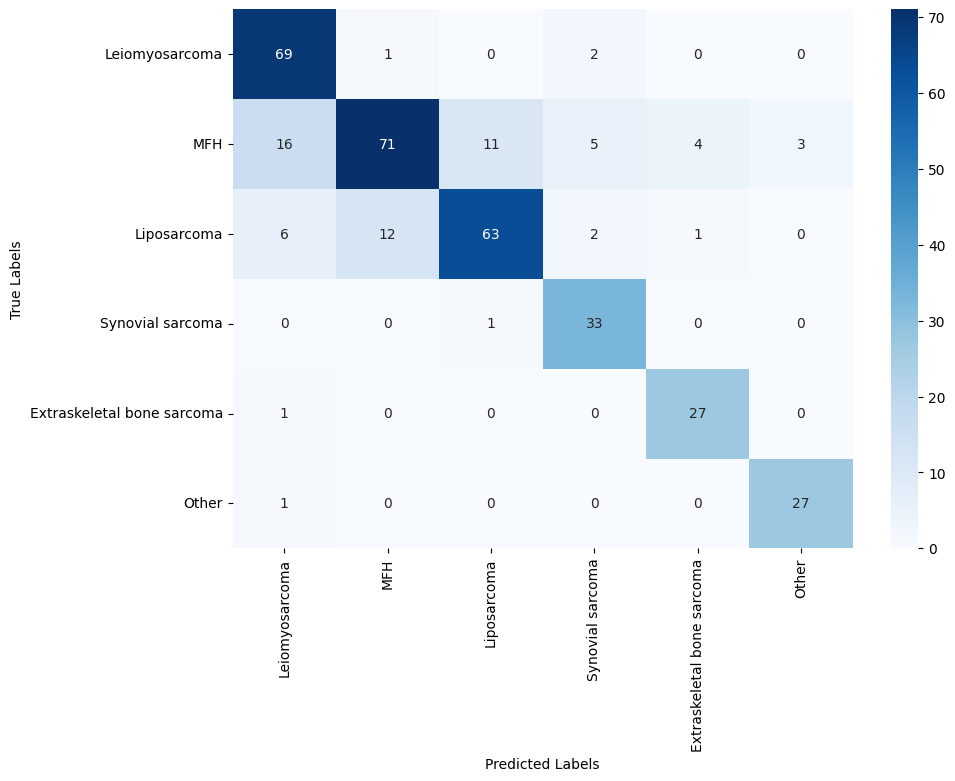

In [81]:
#  evaluate the model
model.evaluate(test_generator)

#  predict the test data
predictions = model.predict(test_generator)

#  get the predicted labels
predicted_labels = np.argmax(predictions, axis=1)

#  get the true labels
true_labels = test_generator.labels

# change the true_labels to the original labels
true_labels = np.argmax(true_labels, axis=1)

predicted_labels =  change_labels(predicted_labels, y_columns)
true_labels = change_labels(true_labels, y_columns)

#  print the classification report
print(classification_report(true_labels, predicted_labels))

#  print macro precision
micro_precision = precision_score(true_labels, predicted_labels, average='macro')
print('Macro Precision: ', micro_precision)

#  print micro precision
micro_precision = precision_score(true_labels, predicted_labels, average='micro')
print('Micro Precision: ', micro_precision)

#  get the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels, labels=y_columns)

#  plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=y_columns, yticklabels=y_columns)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')

#### Model History

Text(0.5, 1.0, 'Macro Precision')

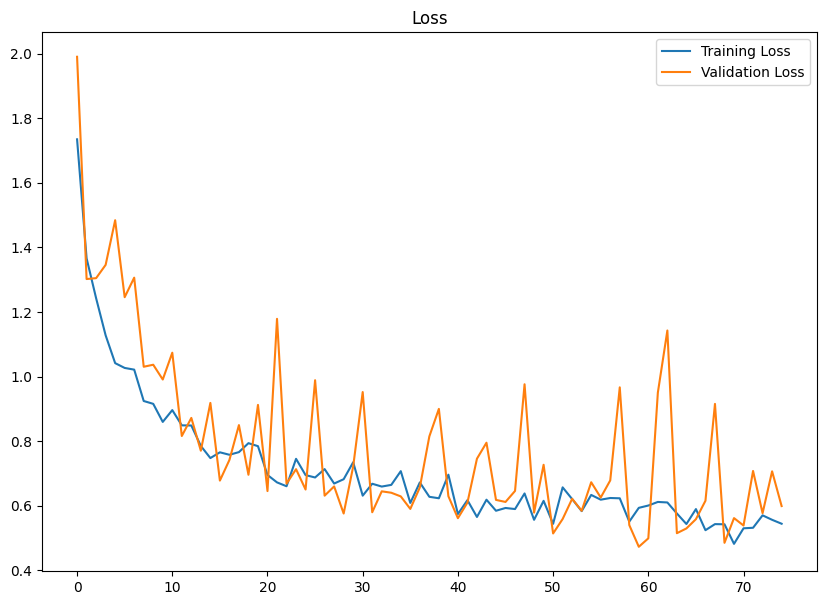

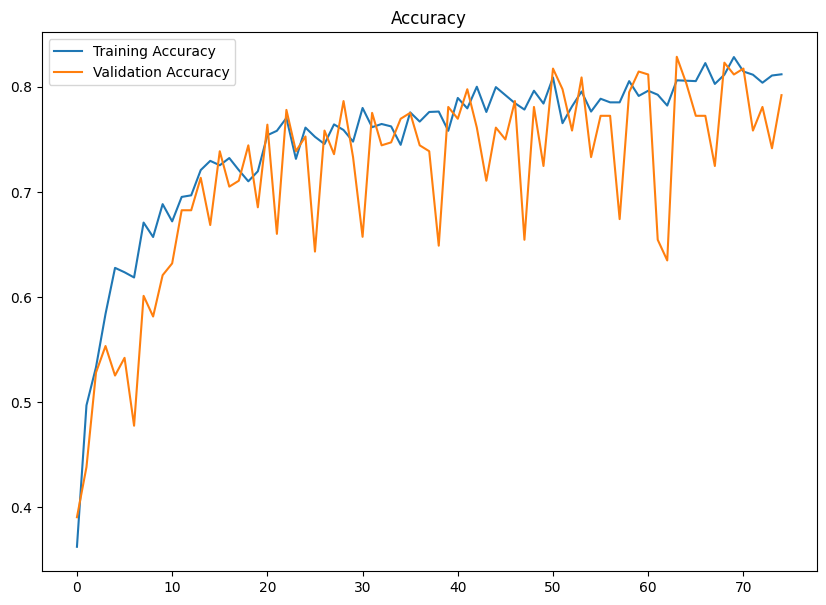

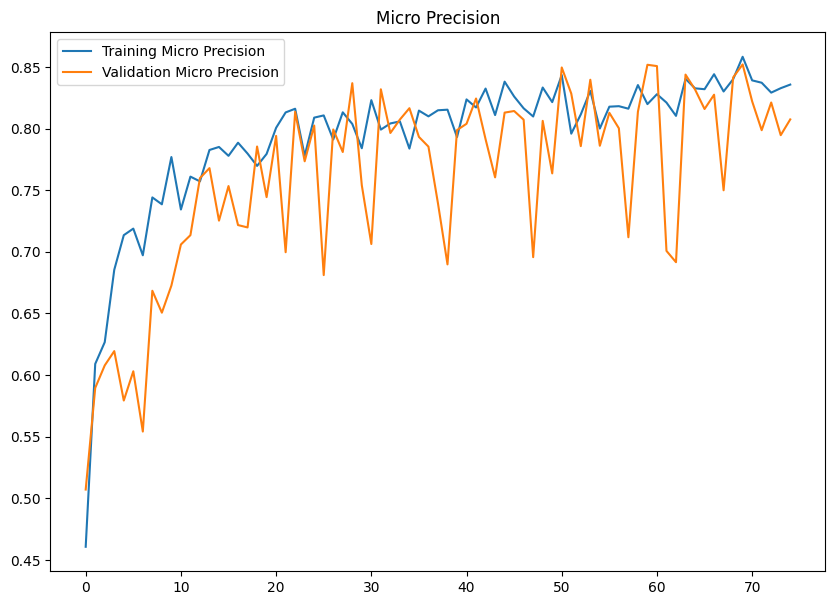

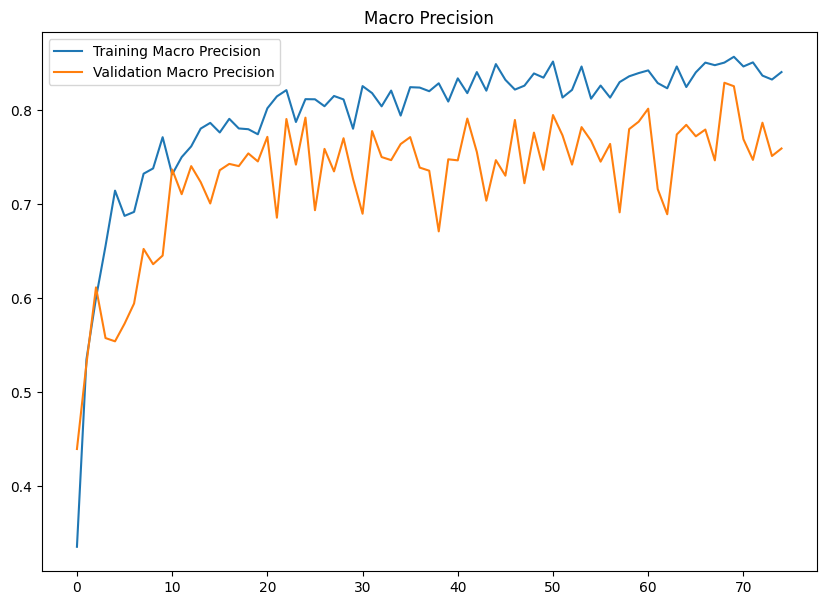

In [82]:
#  plot the loss and accuracy
plt.figure(figsize=(10, 7))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss')

plt.figure(figsize=(10, 7))
plt.plot(history.history['categorical_accuracy'], label='Training Accuracy')
plt.plot(history.history['val_categorical_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')

plt.figure(figsize=(10, 7))
plt.plot(history.history['microprecision'], label='Training Micro Precision')
plt.plot(history.history['val_microprecision'], label='Validation Micro Precision')
plt.legend()
plt.title('Micro Precision')

plt.figure(figsize=(10, 7))
plt.plot(history.history['macroprecision'], label='Training Macro Precision')
plt.plot(history.history['val_macroprecision'], label='Validation Macro Precision')
plt.legend()
plt.title('Macro Precision')

#### Save Model

In [83]:
# save the model
model.save('models\\VGG-16\\vgg-model-test.h5')

### VGG-16 attempt with hyperparameter tuning

#### Define VGG model class

In [89]:
class VGG16Model_class(HyperModel):
    def build(self, hp):
        vgg16 = tf.keras.applications.VGG16(
            include_top=False,
            weights='imagenet',
            input_shape=(224, 224, 3)
        )
        vgg16.trainable = False
        model = tf.keras.models.Sequential([
            vgg16,
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dropout(hp.Float('dropout_rate', 0, 0.5, step=0.1)),
            tf.keras.layers.Dense(6, activation='softmax')
        ])
        optimizer = tf.keras.optimizers.Adam(learning_rate=hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4]))
        model.compile(optimizer=optimizer, 
                        loss=tf.keras.losses.CategoricalCrossentropy(), 
                        metrics=[tf.keras.metrics.CategoricalAccuracy(), macroprecision, microprecision])
        return model
    
    def fit(self, hp, model, *args, **kwargs):
        train_generator.batch_size = hp.Choice("batch_size", [32, 64, 128])
        return model.fit(
            *args,
            epochs=hp.Choice("epochs", [50, 75, 100]),
            **kwargs,
        )

#### Random search for hyperparameter tuning

In [91]:
#  create the callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=TUNING_PAT,
    restore_best_weights=True
)

#  create the tuner
tuner = RandomSearch(
    hypermodel = VGG16Model_class(),
    objective='val_loss',
    seed=42,
    max_trials=50,
    executions_per_trial=2,
    overwrite=True,
    directory='models\\VGG-16\\random_search',
    project_name='VGG-16'
)

#  search for the best hyperparameters
tuner.search(
    train_generator,
    validation_data = test_generator,
    callbacks=[early_stopping],
)

Trial 9 Complete [00h 00m 13s]

Best val_loss So Far: 0.8176128268241882
Total elapsed time: 00h 34m 56s

Search: Running Trial #10

Value             |Best Value So Far |Hyperparameter
0.1               |0.2               |dropout_rate
0.0001            |0.001             |learning_rate
128               |32                |batch_size
50                |50                |epochs

Epoch 1/50


Traceback (most recent call last):
  File "c:\Users\User\miniconda3\envs\tf\lib\site-packages\keras_tuner\engine\base_tuner.py", line 270, in _try_run_and_update_trial
    self._run_and_update_trial(trial, *fit_args, **fit_kwargs)
  File "c:\Users\User\miniconda3\envs\tf\lib\site-packages\keras_tuner\engine\base_tuner.py", line 235, in _run_and_update_trial
    results = self.run_trial(trial, *fit_args, **fit_kwargs)
  File "c:\Users\User\miniconda3\envs\tf\lib\site-packages\keras_tuner\engine\tuner.py", line 287, in run_trial
    obj_value = self._build_and_fit_model(trial, *args, **copied_kwargs)
  File "c:\Users\User\miniconda3\envs\tf\lib\site-packages\keras_tuner\engine\tuner.py", line 214, in _build_and_fit_model
    results = self.hypermodel.fit(hp, model, *args, **kwargs)
  File "C:\Users\User\AppData\Local\Temp\ipykernel_52628\2367860523.py", line 23, in fit
    return model.fit(
  File "c:\Users\User\miniconda3\envs\tf\lib\site-packages\keras\utils\traceback_utils.py", line 7

RuntimeError: Number of consecutive failures excceeded the limit of 3.
Traceback (most recent call last):
  File "c:\Users\User\miniconda3\envs\tf\lib\site-packages\keras_tuner\engine\base_tuner.py", line 270, in _try_run_and_update_trial
    self._run_and_update_trial(trial, *fit_args, **fit_kwargs)
  File "c:\Users\User\miniconda3\envs\tf\lib\site-packages\keras_tuner\engine\base_tuner.py", line 235, in _run_and_update_trial
    results = self.run_trial(trial, *fit_args, **fit_kwargs)
  File "c:\Users\User\miniconda3\envs\tf\lib\site-packages\keras_tuner\engine\tuner.py", line 287, in run_trial
    obj_value = self._build_and_fit_model(trial, *args, **copied_kwargs)
  File "c:\Users\User\miniconda3\envs\tf\lib\site-packages\keras_tuner\engine\tuner.py", line 214, in _build_and_fit_model
    results = self.hypermodel.fit(hp, model, *args, **kwargs)
  File "C:\Users\User\AppData\Local\Temp\ipykernel_52628\2367860523.py", line 23, in fit
    return model.fit(
  File "c:\Users\User\miniconda3\envs\tf\lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "c:\Users\User\miniconda3\envs\tf\lib\site-packages\tensorflow\python\eager\execute.py", line 54, in quick_execute
    tensors = pywrap_tfe.TFE_Py_Execute(ctx._handle, device_name, op_name,
tensorflow.python.framework.errors_impl.ResourceExhaustedError: Graph execution error:

Detected at node 'sequential/vgg16/block1_conv2/Relu' defined at (most recent call last):
    File "c:\Users\User\miniconda3\envs\tf\lib\runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "c:\Users\User\miniconda3\envs\tf\lib\runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "C:\Users\User\AppData\Roaming\Python\Python39\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "c:\Users\User\miniconda3\envs\tf\lib\site-packages\traitlets\config\application.py", line 1043, in launch_instance
      app.start()
    File "C:\Users\User\AppData\Roaming\Python\Python39\site-packages\ipykernel\kernelapp.py", line 725, in start
      self.io_loop.start()
    File "C:\Users\User\AppData\Roaming\Python\Python39\site-packages\tornado\platform\asyncio.py", line 195, in start
      self.asyncio_loop.run_forever()
    File "c:\Users\User\miniconda3\envs\tf\lib\asyncio\base_events.py", line 601, in run_forever
      self._run_once()
    File "c:\Users\User\miniconda3\envs\tf\lib\asyncio\base_events.py", line 1905, in _run_once
      handle._run()
    File "c:\Users\User\miniconda3\envs\tf\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "C:\Users\User\AppData\Roaming\Python\Python39\site-packages\ipykernel\kernelbase.py", line 513, in dispatch_queue
      await self.process_one()
    File "C:\Users\User\AppData\Roaming\Python\Python39\site-packages\ipykernel\kernelbase.py", line 502, in process_one
      await dispatch(*args)
    File "C:\Users\User\AppData\Roaming\Python\Python39\site-packages\ipykernel\kernelbase.py", line 409, in dispatch_shell
      await result
    File "C:\Users\User\AppData\Roaming\Python\Python39\site-packages\ipykernel\kernelbase.py", line 729, in execute_request
      reply_content = await reply_content
    File "C:\Users\User\AppData\Roaming\Python\Python39\site-packages\ipykernel\ipkernel.py", line 422, in do_execute
      res = shell.run_cell(
    File "C:\Users\User\AppData\Roaming\Python\Python39\site-packages\ipykernel\zmqshell.py", line 540, in run_cell
      return super().run_cell(*args, **kwargs)
    File "c:\Users\User\miniconda3\envs\tf\lib\site-packages\IPython\core\interactiveshell.py", line 3009, in run_cell
      result = self._run_cell(
    File "c:\Users\User\miniconda3\envs\tf\lib\site-packages\IPython\core\interactiveshell.py", line 3064, in _run_cell
      result = runner(coro)
    File "c:\Users\User\miniconda3\envs\tf\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "c:\Users\User\miniconda3\envs\tf\lib\site-packages\IPython\core\interactiveshell.py", line 3269, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "c:\Users\User\miniconda3\envs\tf\lib\site-packages\IPython\core\interactiveshell.py", line 3448, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "c:\Users\User\miniconda3\envs\tf\lib\site-packages\IPython\core\interactiveshell.py", line 3508, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\User\AppData\Local\Temp\ipykernel_52628\2265965820.py", line 21, in <module>
      tuner.search(
    File "c:\Users\User\miniconda3\envs\tf\lib\site-packages\keras_tuner\engine\base_tuner.py", line 230, in search
      self._try_run_and_update_trial(trial, *fit_args, **fit_kwargs)
    File "c:\Users\User\miniconda3\envs\tf\lib\site-packages\keras_tuner\engine\base_tuner.py", line 270, in _try_run_and_update_trial
      self._run_and_update_trial(trial, *fit_args, **fit_kwargs)
    File "c:\Users\User\miniconda3\envs\tf\lib\site-packages\keras_tuner\engine\base_tuner.py", line 235, in _run_and_update_trial
      results = self.run_trial(trial, *fit_args, **fit_kwargs)
    File "c:\Users\User\miniconda3\envs\tf\lib\site-packages\keras_tuner\engine\tuner.py", line 287, in run_trial
      obj_value = self._build_and_fit_model(trial, *args, **copied_kwargs)
    File "c:\Users\User\miniconda3\envs\tf\lib\site-packages\keras_tuner\engine\tuner.py", line 214, in _build_and_fit_model
      results = self.hypermodel.fit(hp, model, *args, **kwargs)
    File "C:\Users\User\AppData\Local\Temp\ipykernel_52628\2367860523.py", line 23, in fit
      return model.fit(
    File "c:\Users\User\miniconda3\envs\tf\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\User\miniconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 1564, in fit
      tmp_logs = self.train_function(iterator)
    File "c:\Users\User\miniconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 1160, in train_function
      return step_function(self, iterator)
    File "c:\Users\User\miniconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 1146, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\User\miniconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 1135, in run_step
      outputs = model.train_step(data)
    File "c:\Users\User\miniconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 993, in train_step
      y_pred = self(x, training=True)
    File "c:\Users\User\miniconda3\envs\tf\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\User\miniconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 557, in __call__
      return super().__call__(*args, **kwargs)
    File "c:\Users\User\miniconda3\envs\tf\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\User\miniconda3\envs\tf\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\Users\User\miniconda3\envs\tf\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\User\miniconda3\envs\tf\lib\site-packages\keras\engine\sequential.py", line 410, in call
      return super().call(inputs, training=training, mask=mask)
    File "c:\Users\User\miniconda3\envs\tf\lib\site-packages\keras\engine\functional.py", line 510, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "c:\Users\User\miniconda3\envs\tf\lib\site-packages\keras\engine\functional.py", line 667, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "c:\Users\User\miniconda3\envs\tf\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\User\miniconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 557, in __call__
      return super().__call__(*args, **kwargs)
    File "c:\Users\User\miniconda3\envs\tf\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\User\miniconda3\envs\tf\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\Users\User\miniconda3\envs\tf\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\User\miniconda3\envs\tf\lib\site-packages\keras\engine\functional.py", line 510, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "c:\Users\User\miniconda3\envs\tf\lib\site-packages\keras\engine\functional.py", line 667, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "c:\Users\User\miniconda3\envs\tf\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\User\miniconda3\envs\tf\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\Users\User\miniconda3\envs\tf\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\User\miniconda3\envs\tf\lib\site-packages\keras\layers\convolutional\base_conv.py", line 314, in call
      return self.activation(outputs)
    File "c:\Users\User\miniconda3\envs\tf\lib\site-packages\keras\activations.py", line 317, in relu
      return backend.relu(
    File "c:\Users\User\miniconda3\envs\tf\lib\site-packages\keras\backend.py", line 5366, in relu
      x = tf.nn.relu(x)
Node: 'sequential/vgg16/block1_conv2/Relu'
OOM when allocating tensor with shape[128,64,224,224] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node sequential/vgg16/block1_conv2/Relu}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_258045]


: 

#### Tuning results

In [ ]:
tuner.results_summary()

Results summary
Results in models\VGG-16\random_search\VGG-16
Showing 10 best trials
Objective(name="val_loss", direction="min")

Trial 15 summary
Hyperparameters:
dropout_rate: 0.0
learning_rate: 0.001
batch_size: 32
epochs: 100
Score: 0.7102984189987183

Trial 49 summary
Hyperparameters:
dropout_rate: 0.1
learning_rate: 0.001
batch_size: 32
epochs: 100
Score: 0.7235555052757263

Trial 48 summary
Hyperparameters:
dropout_rate: 0.30000000000000004
learning_rate: 0.001
batch_size: 64
epochs: 50
Score: 0.7280642092227936

Trial 06 summary
Hyperparameters:
dropout_rate: 0.2
learning_rate: 0.001
batch_size: 32
epochs: 50
Score: 0.7350674867630005

Trial 44 summary
Hyperparameters:
dropout_rate: 0.30000000000000004
learning_rate: 0.001
batch_size: 128
epochs: 50
Score: 0.8211560845375061

Trial 10 summary
Hyperparameters:
dropout_rate: 0.1
learning_rate: 0.001
batch_size: 32
epochs: 75
Score: 0.8552727401256561

Trial 28 summary
Hyperparameters:
dropout_rate: 0.2
learning_rate: 0.001
batch_

In [ ]:
#  get the best hyperparameters
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]
best_hyperparameters.values

{'dropout_rate': 0.0, 'learning_rate': 0.001, 'batch_size': 32, 'epochs': 100}

#### Build the model with the best hyperparameters

##### Model Building

In [ ]:
# Build the model with the best hyperparameters
vgg_tuned_model = tuner.hypermodel.build(best_hyperparameters)

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath='tf_checkpoints\\VGG-16\\tuning_model',
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=True
)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='loss',
    patience=PAT,
    restore_best_weights=True
) 

train_generator.batch_size = best_hyperparameters.values['batch_size']

#  fit the model
history = vgg_tuned_model.fit(
    train_generator,
    validation_data=test_generator,
    epochs = best_hyperparameters.values['epochs'],
    callbacks=[model_checkpoint, early_stopping]
)
# reset the generators
train_generator.reset()

Epoch 1/100
34/34 [==============================] - 11s 322ms/step - loss: 2.0722 - categorical_accuracy: 0.3077 - macroprecision: 0.1451 - microprecision: 0.3625 - val_loss: 1.6529 - val_categorical_accuracy: 0.3483 - val_macroprecision: 0.1186 - val_microprecision: 0.4214
Epoch 2/100
34/34 [==============================] - 11s 314ms/step - loss: 1.5683 - categorical_accuracy: 0.4071 - macroprecision: 0.3176 - microprecision: 0.5141 - val_loss: 1.3874 - val_categorical_accuracy: 0.4438 - val_macroprecision: 0.3122 - val_microprecision: 0.5024
Epoch 3/100
34/34 [==============================] - 11s 308ms/step - loss: 1.4836 - categorical_accuracy: 0.4371 - macroprecision: 0.4018 - microprecision: 0.5494 - val_loss: 1.6036 - val_categorical_accuracy: 0.3539 - val_macroprecision: 0.3465 - val_microprecision: 0.3621
Epoch 4/100
34/34 [==============================] - 11s 315ms/step - loss: 1.3291 - categorical_accuracy: 0.4981 - macroprecision: 0.4463 - microprecision: 0.5942 - val_lo

##### Model claasification report

In [ ]:
#  evaluate the model
vgg_tuned_model.evaluate(test_generator)

#  predict the test data
predictions = vgg_tuned_model.predict(test_generator)

#  get the predicted labels
predicted_labels = np.argmax(predictions, axis=1)

#  get the true labels
true_labels = test_generator.labels

# change the true_labels to the original labels
true_labels = np.argmax(true_labels, axis=1)

predicted_labels =  change_labels(predicted_labels, y_columns)
true_labels = change_labels(true_labels, y_columns)

#  print the classification report
print(classification_report(true_labels, predicted_labels))

#  print micro precision
micro_precision = precision_score(true_labels, predicted_labels, average='micro')
print('Micro Precision: ', micro_precision)

# print  macro precision
macro_precision = precision_score(true_labels, predicted_labels, average='macro')
print('Macro Precision: ', macro_precision)

#  get the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels, labels=y_columns)

#  plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=y_columns, yticklabels=y_columns)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')

12/12 [==============================] - 1s 73ms/step
                            precision    recall  f1-score   support

Extraskeletal bone sarcoma       0.93      0.93      0.93        28
            Leiomyosarcoma       0.88      0.90      0.89        72
               Liposarcoma       0.81      0.83      0.82        84
                       MFH       0.87      0.78      0.82       110
                     Other       0.80      0.86      0.83        28
          Synovial sarcoma       0.72      0.82      0.77        34

                  accuracy                           0.84       356
                 macro avg       0.83      0.85      0.84       356
              weighted avg       0.84      0.84      0.84       356

Micro Precision:  0.8398876404494382
Macro Precision:  0.8345898136595812


##### Model History

Text(0.5, 1.0, 'Macro Precision')

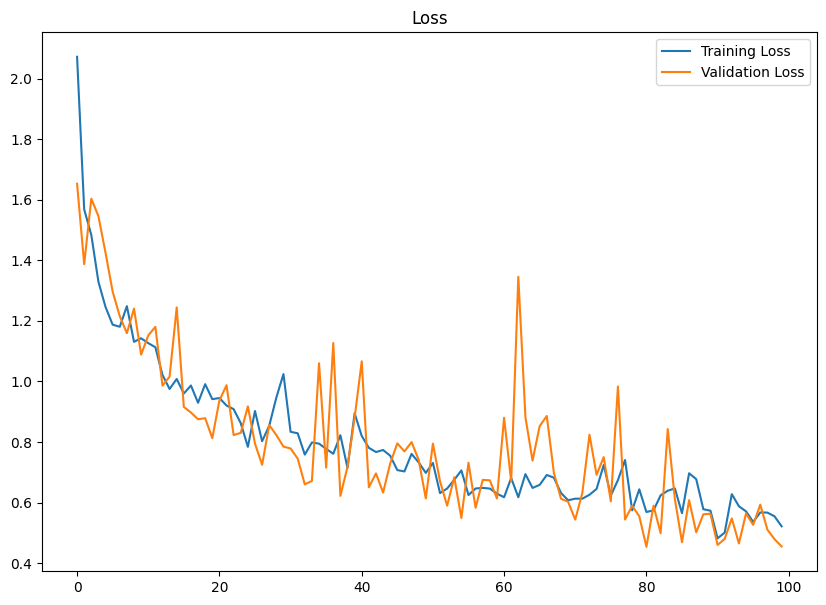

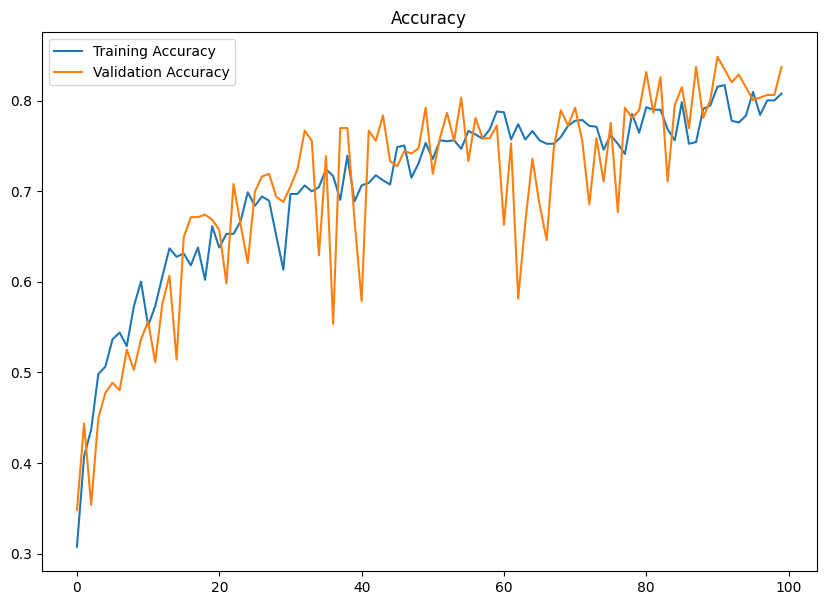

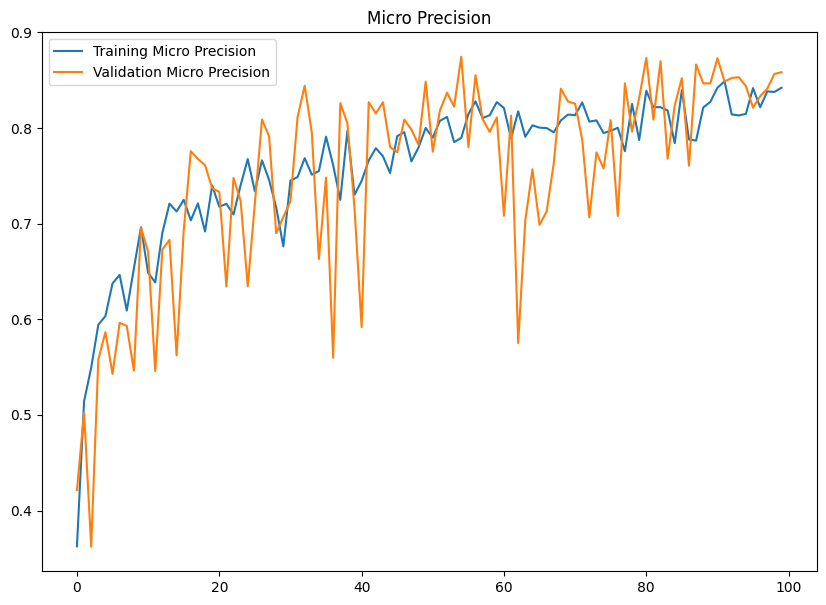

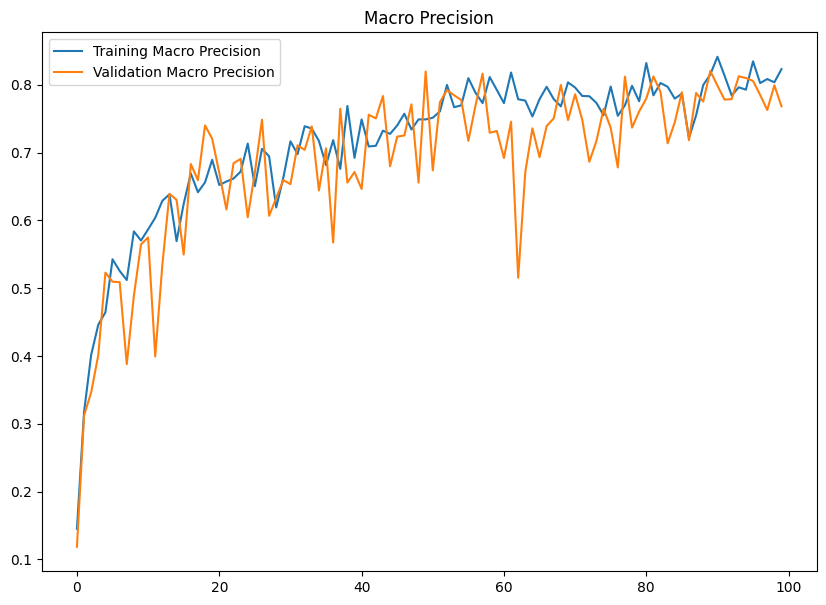

In [ ]:
#  plot the loss and accuracy
plt.figure(figsize=(10, 7))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss')

plt.figure(figsize=(10, 7))
plt.plot(history.history['categorical_accuracy'], label='Training Accuracy')
plt.plot(history.history['val_categorical_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')

plt.figure(figsize=(10, 7))
plt.plot(history.history['microprecision'], label='Training Micro Precision')
plt.plot(history.history['val_microprecision'], label='Validation Micro Precision')
plt.legend()
plt.title('Micro Precision')

plt.figure(figsize=(10, 7))
plt.plot(history.history['macroprecision'], label='Training Macro Precision')
plt.plot(history.history['val_macroprecision'], label='Validation Macro Precision')
plt.legend()
plt.title('Macro Precision')

##### Save Model

In [ ]:
# save the model
vgg_tuned_model.save('models\\VGG-16\\vgg_tuned_model.h5')

### VGG-16 Cross Validation

In [ ]:
# cross validation
skf = StratifiedKFold(n_splits = 5, shuffle=True, random_state=42)

i = 1
vgg_hist = []
vgg_accuracy = []
vgg_micro_precision = []
vgg_macro_precision = []
X = train_df['Image Path']
y = train_df['Label']

for train_index, test_index in skf.split(X, y):
    if i != 1:
        print('\n')
    print('-'*50)
    print('Fold ', i)
    print('-'*50)
    model_checkpoint_cv = tf.keras.callbacks.ModelCheckpoint(
        filepath='tf_checkpoints\\VGG-16\\cv_model\\model_' + str(i),
        monitor='val_loss',
        save_best_only=True,
        save_weights_only=True
    )

    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='loss',
        patience=PAT,
        restore_best_weights=True
    ) 
    
    train_data_cv  = train_df.iloc[train_index] 
    test_data_cv  = train_df.iloc[test_index]
    
    train_data_cv, _ = ros.fit_resample(train_data_cv, train_data_cv['Label'])  
    
    train_generator_cv = train_datagen.flow_from_dataframe(
        dataframe=train_data_cv,
        x_col='Image Path',
        y_col= y_columns,
        target_size=(224, 224),
        batch_size= best_hyperparameters.values['batch_size'],
        class_mode='raw',
        shuffle=True,
        seed=42,
        verbose=0
    )

    test_generator_cv = test_datagen.flow_from_dataframe(
        dataframe=test_data_cv,
        x_col='Image Path',
        y_col= y_columns,
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        shuffle=False,
        verbose=0
    )

    vgg_tuned_model_cv = tuner.hypermodel.build(best_hyperparameters)

    vgg_hist.append(vgg_tuned_model_cv.fit(
        train_generator_cv,
        epochs= best_hyperparameters.values['epochs'],
        callbacks=[model_checkpoint, early_stopping],
        validation_data=test_generator_cv,
        verbose=0
    ))

    print('\nModel ' + str(i) + ' evaluation:')
    vgg_tuned_model_cv.evaluate(test_generator_cv, verbose=0)
    predictions = vgg_tuned_model_cv.predict(test_generator_cv, verbose=0)
    predicted_labels = np.argmax(predictions, axis=1)
    true_labels = test_generator_cv.labels
    true_labels = np.argmax(true_labels, axis=1)
    predicted_labels =  change_labels(predicted_labels, y_columns)
    true_labels = change_labels(true_labels, y_columns)
    #  record the metrics
    vgg_accuracy.append(accuracy_score(true_labels, predicted_labels))
    vgg_micro_precision.append(precision_score(true_labels, predicted_labels, average='micro'))
    vgg_macro_precision.append(precision_score(true_labels, predicted_labels, average='macro'))
    print('Accuracy: ', vgg_accuracy[i-1], '\nMicro Precision: ', vgg_micro_precision[i-1], '\nMacro Precision: ', vgg_macro_precision[i-1])
    i += 1

print('\n')
print('-'*50)
print('Results:')
print('Average accuracy: ', np.mean(vgg_accuracy))
print('Average micro precision: ', np.mean(vgg_micro_precision))
print('Average macro precision: ', np.mean(vgg_macro_precision))

--------------------------------------------------
Fold  1
--------------------------------------------------
Found 1137 validated image filenames.
Found 285 validated image filenames.

Model 1 evaluation:
Accuracy:  0.7543859649122807 
Micro Precision:  0.7543859649122807 
Macro Precision:  0.826327088212334


--------------------------------------------------
Fold  2
--------------------------------------------------
Found 1137 validated image filenames.
Found 285 validated image filenames.

Model 2 evaluation:
Accuracy:  0.8315789473684211 
Micro Precision:  0.8315789473684211 
Macro Precision:  0.8268532522705034


--------------------------------------------------
Fold  3
--------------------------------------------------
Found 1138 validated image filenames.
Found 284 validated image filenames.

Model 3 evaluation:
Accuracy:  0.6971830985915493 
Micro Precision:  0.6971830985915493 
Macro Precision:  0.8050312501396094


--------------------------------------------------
Fold  4


## ResNet-50 Model

In [ ]:
# change batch size back to 32
train_generator.batch_size = 32

# create restnet model
restnet_model = tf.keras.applications.ResNet50(
    include_top=False,
    weights='imagenet',
    input_shape=(224, 224, 3)
)

#  freeze the layers
restnet_model.trainable = False

### ResNet-50 attempt without hyperparameter tuning

#### Model Building

In [ ]:
# create the model
model = tf.keras.Sequential([
    restnet_model,
    tf.keras.layers.GlobalAveragePooling2D(),  
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(6, activation='softmax')
])

#  compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=[tf.keras.metrics.CategoricalAccuracy(), macroprecision, microprecision]
)

#  create the callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=PAT,
    restore_best_weights=True
)

# create the model checkpoint
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath='tf_checkpoints\\RestNet-50\\model_checkpoint',
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=True
)

# reset the generators
train_generator.reset()
test_generator.reset()

# fit the model
history = model.fit(
    train_generator,
    validation_data=test_generator,
    epochs=100,
    callbacks=[model_checkpoint, early_stopping]
)

# reset the generators
train_generator.reset()
test_generator.reset()

Epoch 1/100
36/36 [==============================] - 16s 361ms/step - loss: 1.8304 - categorical_accuracy: 0.2469 - macroprecision: 0.0755 - microprecision: 0.2756 - val_loss: 1.6713 - val_categorical_accuracy: 0.2331 - val_macroprecision: 0.0000e+00 - val_microprecision: 0.0000e+00
Epoch 2/100
36/36 [==============================] - 13s 347ms/step - loss: 1.6942 - categorical_accuracy: 0.2680 - macroprecision: 0.0000e+00 - microprecision: 0.0000e+00 - val_loss: 1.6478 - val_categorical_accuracy: 0.3062 - val_macroprecision: 0.0000e+00 - val_microprecision: 0.0000e+00
Epoch 3/100
36/36 [==============================] - 12s 328ms/step - loss: 1.6798 - categorical_accuracy: 0.3084 - macroprecision: 0.0000e+00 - microprecision: 0.0000e+00 - val_loss: 1.6490 - val_categorical_accuracy: 0.3062 - val_macroprecision: 0.0000e+00 - val_microprecision: 0.0000e+00
Epoch 4/100
36/36 [==============================] - 12s 326ms/step - loss: 1.6667 - categorical_accuracy: 0.3023 - macroprecision: 

#### Model Classifcation Report

9/9 [==============================] - 1s 72ms/step
                            precision    recall  f1-score   support

Extraskeletal bone sarcoma       0.00      0.00      0.00        23
            Leiomyosarcoma       0.00      0.00      0.00        57
               Liposarcoma       0.26      0.18      0.21        68
                       MFH       0.29      0.78      0.42        87
                     Other       0.00      0.00      0.00        22
          Synovial sarcoma       0.00      0.00      0.00        27

                  accuracy                           0.28       284
                 macro avg       0.09      0.16      0.10       284
              weighted avg       0.15      0.28      0.18       284

Macro Precision:  0.09109730848861282
Micro Precision:  0.28169014084507044


Text(95.7222222222222, 0.5, 'True Labels')

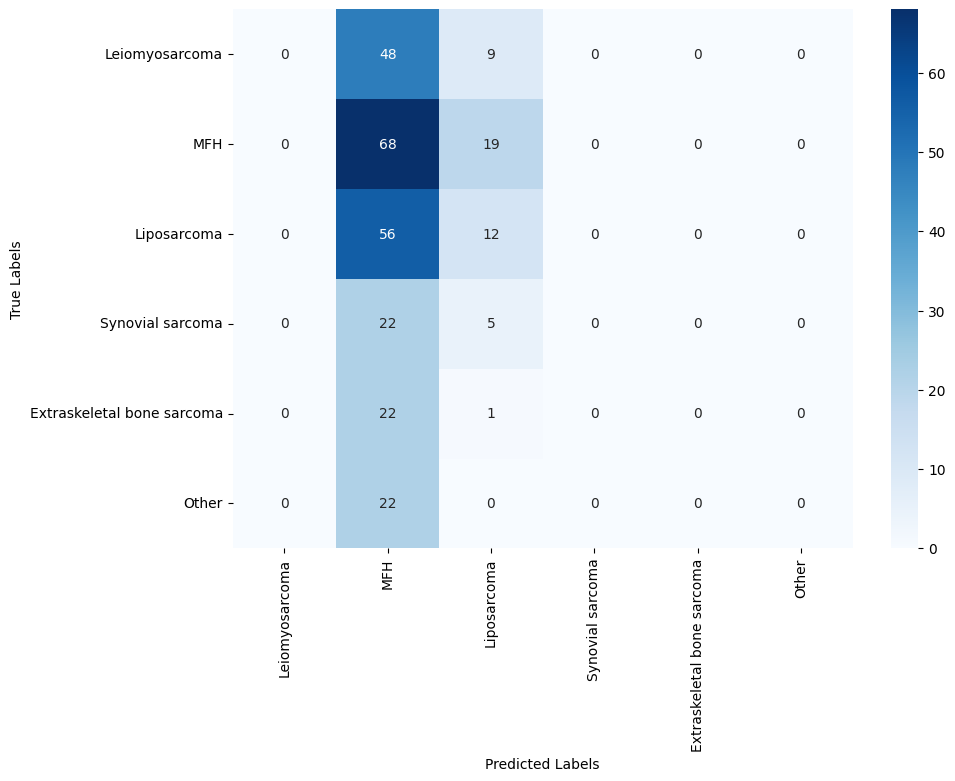

In [ ]:
#  evaluate the model
model.evaluate(test_generator)

#  predict the test data
predictions = model.predict(test_generator)

#  get the predicted labels
predicted_labels = np.argmax(predictions, axis=1)

#  get the true labels
true_labels = test_generator.labels

# change the true_labels to the original labels
true_labels = np.argmax(true_labels, axis=1)

predicted_labels =  change_labels(predicted_labels, y_columns)
true_labels = change_labels(true_labels, y_columns)

#  print the classification report
print(classification_report(true_labels, predicted_labels))

#  print macro precision
micro_precision = precision_score(true_labels, predicted_labels, average='macro')
print('Macro Precision: ', micro_precision)

#  print micro precision
micro_precision = precision_score(true_labels, predicted_labels, average='micro')
print('Micro Precision: ', micro_precision)

#  get the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels, labels=y_columns)

#  plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=y_columns, yticklabels=y_columns)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')

#### Model History

Text(0.5, 1.0, 'Macro Precision')

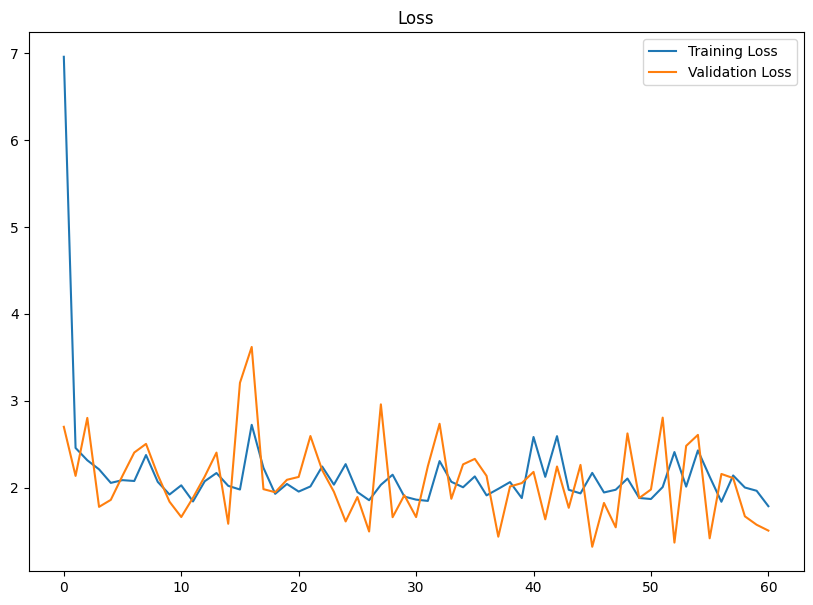

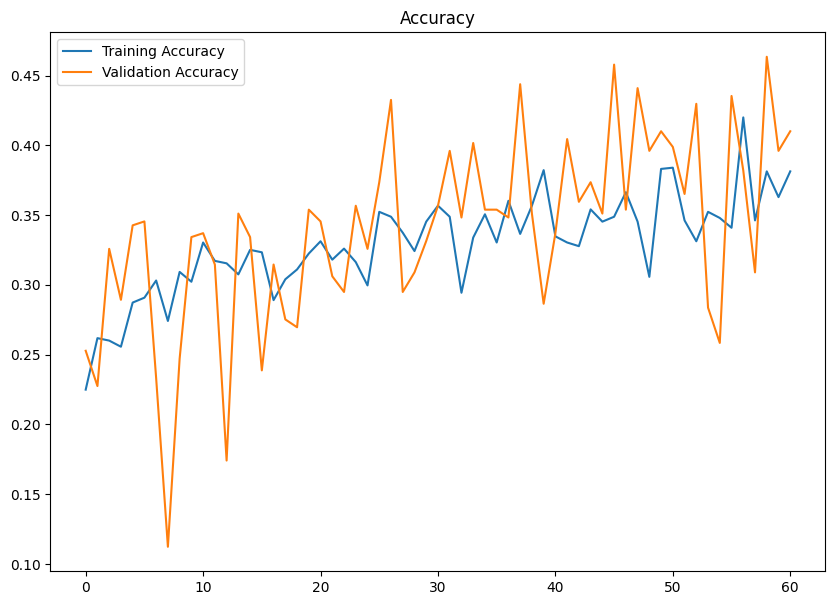

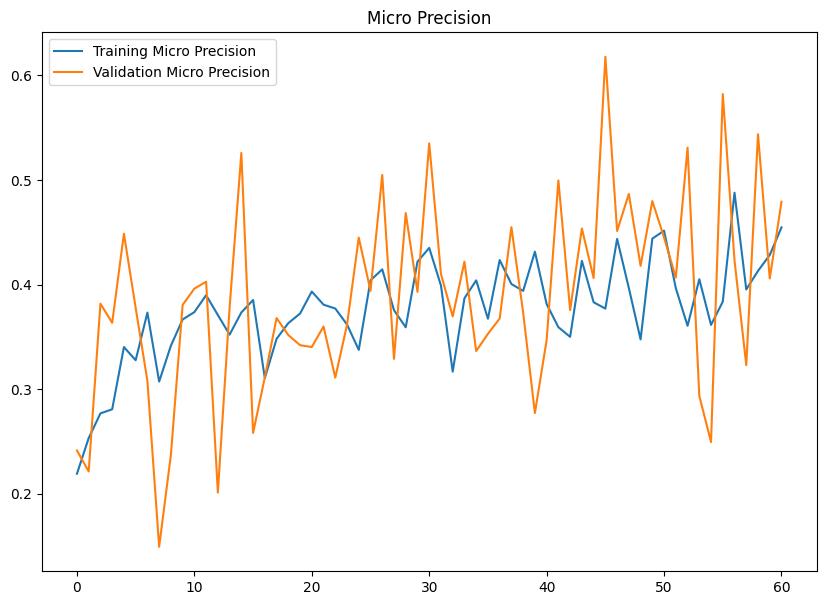

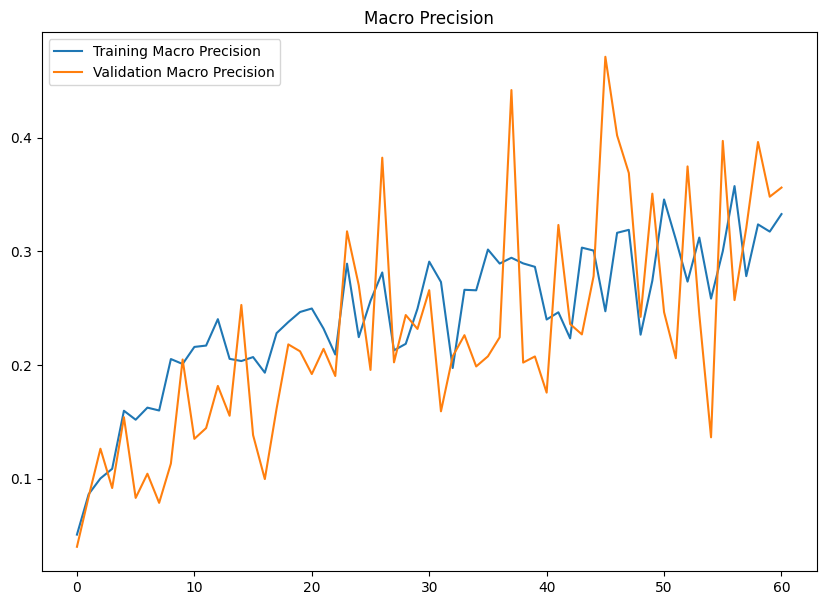

In [ ]:
#  plot the loss and accuracy
plt.figure(figsize=(10, 7))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss')

plt.figure(figsize=(10, 7))
plt.plot(history.history['categorical_accuracy'], label='Training Accuracy')
plt.plot(history.history['val_categorical_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')

plt.figure(figsize=(10, 7))
plt.plot(history.history['microprecision'], label='Training Micro Precision')
plt.plot(history.history['val_microprecision'], label='Validation Micro Precision')
plt.legend()
plt.title('Micro Precision')

plt.figure(figsize=(10, 7))
plt.plot(history.history['macroprecision'], label='Training Macro Precision')
plt.plot(history.history['val_macroprecision'], label='Validation Macro Precision')
plt.legend()
plt.title('Macro Precision')

#### Save Model

In [216]:
model.save('models\\RestNet-50\\restnet-model-test.h5')

### ResNet-50 attempt with hyperparameter tuning

#### Define ResNet model class

In [217]:
class RestNet50Model_class(HyperModel):
    def build(self, hp):
        restnet_model = tf.keras.applications.ResNet50(
            include_top=False,
            weights='imagenet',
            input_shape=(224, 224, 3)
        )

        #  freeze the layers
        restnet_model.trainable = False
        model = tf.keras.models.Sequential([
            restnet_model,
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dropout(hp.Float('dropout_rate', 0, 0.5, step=0.1)),
            tf.keras.layers.Dense(6, activation='softmax')
        ])
        optimizer = tf.keras.optimizers.Adam(learning_rate=hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4]))
        model.compile(optimizer=optimizer, 
                        loss=tf.keras.losses.CategoricalCrossentropy(), 
                        metrics=[tf.keras.metrics.CategoricalAccuracy(), macroprecision, microprecision])
        return model
    
    def fit(self, hp, model, *args, **kwargs):
        train_generator.batch_size = hp.Choice("batch_size", [32, 64, 128])
        return model.fit(
            *args,
            epochs=hp.Choice("epochs", [50, 75, 100]),
            **kwargs,
        )

#### Random search for hyperparameter tuning

In [218]:
#  create the callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=TUNING_PAT,
    restore_best_weights=True
)

#  create the tuner
tuner = RandomSearch(
    hypermodel = RestNet50Model_class(),
    objective='val_loss',
    seed=42,
    max_trials=50,
    executions_per_trial=2,
    overwrite=True,
    directory='models\\RestNet-50\\random_search',
    project_name='RestNet-50'
)

#  search for the best hyperparameters
tuner.search(
    train_generator,
    validation_data = test_generator,
    callbacks=[early_stopping],
)

Trial 10 Complete [00h 08m 15s]
val_loss: 1.5049453973770142

Best val_loss So Far: 1.5044156312942505
Total elapsed time: 00h 51m 19s

Search: Running Trial #11

Value             |Best Value So Far |Hyperparameter
0.1               |0.2               |dropout_rate
0.001             |0.001             |learning_rate
32                |32                |batch_size
75                |50                |epochs

Epoch 1/75
36/36 [==============================] - 15s 359ms/step - loss: 5.7607 - categorical_accuracy: 0.2197 - macroprecision: 0.0724 - microprecision: 0.2146 - val_loss: 3.1801 - val_categorical_accuracy: 0.2022 - val_macroprecision: 0.0376 - val_microprecision: 0.2253
Epoch 2/75
36/36 [==============================] - 12s 345ms/step - loss: 2.5845 - categorical_accuracy: 0.2293 - macroprecision: 0.0807 - microprecision: 0.2585 - val_loss: 1.5990 - val_categorical_accuracy: 0.3118 - val_macroprecision: 0.1093 - val_microprecision: 0.3000
Epoch 3/75
36/36 [==================

KeyboardInterrupt: 

In [ ]:
tuner.results_summary()

In [ ]:
#  get the best hyperparameters
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]
best_hyperparameters.values

#### Build the model with the best hyperparameters

##### Model Building

In [ ]:
# Build the model with the best hyperparameters
restnet_tuned_model = tuner.hypermodel.build(best_hyperparameters)

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath='tf_checkpoints\\RestNet-50\\tuning_model',
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=True
)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='loss',
    patience=PAT,
    restore_best_weights=True
) 

train_generator.batch_size = best_hyperparameters.values['batch_size']

#  fit the model
history = restnet_tuned_model.fit(
    train_generator,
    validation_data=test_generator,
    epochs= best_hyperparameters.values['epochs'],
    callbacks=[model_checkpoint, early_stopping]
)
# reset the generators
train_generator.reset()

##### Model Classification Report

In [ ]:
#  evaluate the model
restnet_tuned_model.evaluate(test_generator)

#  predict the test data
predictions = restnet_tuned_model.predict(test_generator)

#  get the predicted labels
predicted_labels = np.argmax(predictions, axis=1)

#  get the true labels
true_labels = test_generator.labels

# change the true_labels to the original labels
true_labels = np.argmax(true_labels, axis=1)

predicted_labels =  change_labels(predicted_labels, y_columns)
true_labels = change_labels(true_labels, y_columns)

#  print the classification report
print(classification_report(true_labels, predicted_labels))

#  print micro precision
micro_precision = precision_score(true_labels, predicted_labels, average='micro')
print('Micro Precision: ', micro_precision)

# print  macro precision
macro_precision = precision_score(true_labels, predicted_labels, average='macro')
print('Macro Precision: ', macro_precision)

##### Model History

In [ ]:
#  plot the loss and accuracy
plt.figure(figsize=(10, 7))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss')

plt.figure(figsize=(10, 7))
plt.plot(history.history['categorical_accuracy'], label='Training Accuracy')
plt.plot(history.history['val_categorical_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')

plt.figure(figsize=(10, 7))
plt.plot(history.history['microprecision'], label='Training Micro Precision')
plt.plot(history.history['val_microprecision'], label='Validation Micro Precision')
plt.legend()
plt.title('Micro Precision')

plt.figure(figsize=(10, 7))
plt.plot(history.history['macroprecision'], label='Training Macro Precision')
plt.plot(history.history['val_macroprecision'], label='Validation Macro Precision')
plt.legend()
plt.title('Macro Precision')

##### Save Model

In [ ]:
#  save the model
restnet_tuned_model.save('models\\RestNet-50\\restnet-model-tuned.h5')

### RestNet-50 Cross Validation

In [ ]:
# cross validation
skf = StratifiedKFold(n_splits = 5, shuffle=True, random_state=42)
i = 1
rest_hist = []
rest_accuracy = []
rest_micro_precision = []
rest_macro_precision = []
X = train_df['Image Path']
y = train_df['Label']

for train_index, test_index in skf.split(X, y):
    if i != 1:
        print('\n')
    print('-'*50)
    print('Fold ', i)
    print('-'*50)
    model_checkpoint_cv = tf.keras.callbacks.ModelCheckpoint(
        filepath='tf_checkpoints\\RestNet-50\\cv_model\\model_' + str(i),
        monitor='val_loss',
        save_best_only=True,
        save_weights_only=True
    )

    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='loss',
        patience=PAT,
        restore_best_weights=True
    ) 
    
    train_data_cv  = train_df.iloc[train_index]
    test_data_cv  = train_df.iloc[test_index]
    
    train_data_cv, _ = ros.fit_resample(train_data_cv, train_data_cv['Label'])  
    
    train_generator_cv = train_datagen.flow_from_dataframe(
        dataframe=train_data_cv,
        x_col='Image Path',
        y_col= y_columns,
        target_size=(224, 224),
        batch_size= best_hyperparameters.values['batch_size'],
        class_mode='raw',
        shuffle=True,
        seed=42,
        verbose=0
    )

    test_generator_cv = test_datagen.flow_from_dataframe(
        dataframe=test_data_cv,
        x_col='Image Path',
        y_col= y_columns,
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        shuffle=False,
        verbose=0
    )

    restnet_tuned_model_cv = tuner.hypermodel.build(best_hyperparameters)

    rest_hist.append(restnet_tuned_model_cv.fit(
        train_generator_cv,
        epochs=best_hyperparameters.values['epochs'],
        callbacks=[model_checkpoint, early_stopping],
        validation_data=test_generator_cv,
        verbose=0
    ))

    print('\nModel ' + str(i) + ' evaluation:')
    restnet_tuned_model_cv.evaluate(test_generator_cv, verbose=0)
    predictions = restnet_tuned_model_cv.predict(test_generator_cv, verbose=0)
    predicted_labels = np.argmax(predictions, axis=1)
    true_labels = test_generator_cv.labels
    true_labels = np.argmax(true_labels, axis=1)
    predicted_labels =  change_labels(predicted_labels, y_columns)
    true_labels = change_labels(true_labels, y_columns)
    #  record the metrics
    rest_accuracy.append(accuracy_score(true_labels, predicted_labels))
    rest_micro_precision.append(precision_score(true_labels, predicted_labels, average='micro'))
    rest_macro_precision.append(precision_score(true_labels, predicted_labels, average='macro'))
    print('Accuracy: ', rest_accuracy[i-1], '\nMicro Precision: ', micro_precision[i-1], '\nMacro Precision: ', macro_precision[i-1])
    i += 1

print('\n')
print('-'*50)
print('Results:')
print('Average accuracy: ', np.mean(rest_accuracy))
print('Average micro precision: ', np.mean(rest_micro_precision))
print('Average macro precision: ', np.mean(rest_macro_precision))

## InceptionV3 Model

In [ ]:
# change batch size back to 32
train_generator.batch_size = 32

# create inception model
inception_model = tf.keras.applications.InceptionV3(
    include_top=False,
    weights='imagenet',
    input_shape=(224, 224, 3)
)

#  freeze the layers
inception_model.trainable = False

87910968/87910968 [==============================] - 7s 0us/step


### InceptionV3 attempt without hyperparameter tuning

#### Model Building

In [ ]:
# create the model
model = tf.keras.models.Sequential([
    inception_model,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(6, activation='softmax')
])

#  compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=[tf.keras.metrics.CategoricalAccuracy(), macroprecision, microprecision]
)

#  create the callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=PAT,
    restore_best_weights=True
)

# create the model checkpoint
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath='tf_checkpoints\\InceptionV3\\model_checkpoint',
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=True
)

# reset the generators
train_generator.reset()
test_generator.reset()

# fit the model
history = model.fit(
    train_generator,
    validation_data=test_generator,
    epochs=100,
    callbacks=[model_checkpoint, early_stopping]
)

# reset the generators
train_generator.reset()
test_generator.reset()

Epoch 1/100
36/36 [==============================] - 16s 349ms/step - loss: 6.9114 - categorical_accuracy: 0.3172 - macroprecision: 0.2471 - microprecision: 0.3213 - val_loss: 3.1506 - val_categorical_accuracy: 0.4663 - val_macroprecision: 0.4020 - val_microprecision: 0.4780
Epoch 2/100
36/36 [==============================] - 11s 305ms/step - loss: 3.1005 - categorical_accuracy: 0.4789 - macroprecision: 0.4628 - microprecision: 0.4873 - val_loss: 2.6712 - val_categorical_accuracy: 0.4579 - val_macroprecision: 0.4620 - val_microprecision: 0.4413
Epoch 3/100
36/36 [==============================] - 11s 306ms/step - loss: 2.6359 - categorical_accuracy: 0.5334 - macroprecision: 0.4643 - microprecision: 0.5377 - val_loss: 2.1626 - val_categorical_accuracy: 0.5225 - val_macroprecision: 0.4667 - val_microprecision: 0.5667
Epoch 4/100
36/36 [==============================] - 10s 286ms/step - loss: 3.1973 - categorical_accuracy: 0.5202 - macroprecision: 0.5411 - microprecision: 0.5288 - val_lo

#### Model Classification Report

9/9 [==============================] - 1s 64ms/step
                            precision    recall  f1-score   support

Extraskeletal bone sarcoma       1.00      0.70      0.82        23
            Leiomyosarcoma       0.69      0.89      0.78        57
               Liposarcoma       0.78      0.82      0.80        68
                       MFH       0.84      0.68      0.75        87
                     Other       0.84      0.95      0.89        22
          Synovial sarcoma       0.59      0.59      0.59        27

                  accuracy                           0.77       284
                 macro avg       0.79      0.77      0.77       284
              weighted avg       0.79      0.77      0.77       284

Macro Precision:  0.790402783736117
Micro Precision:  0.7711267605633803


Text(95.7222222222222, 0.5, 'True Labels')

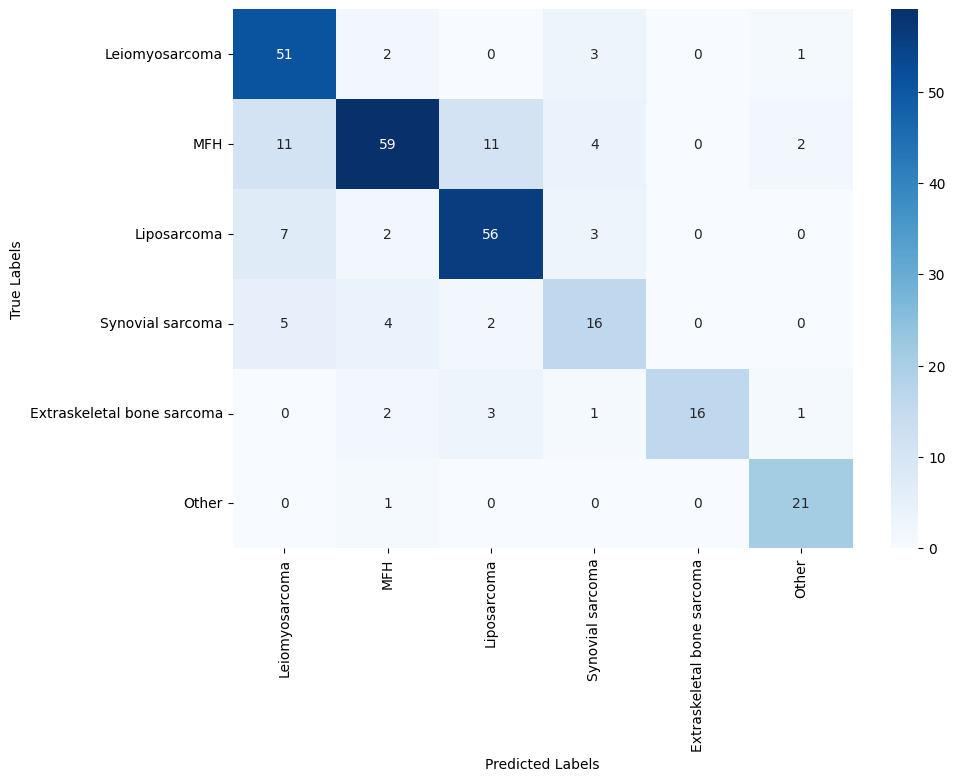

In [ ]:
#  evaluate the model
model.evaluate(test_generator)

#  predict the test data
predictions = model.predict(test_generator)

#  get the predicted labels
predicted_labels = np.argmax(predictions, axis=1)

#  get the true labels
true_labels = test_generator.labels

# change the true_labels to the original labels
true_labels = np.argmax(true_labels, axis=1)

predicted_labels =  change_labels(predicted_labels, y_columns)
true_labels = change_labels(true_labels, y_columns)

#  print the classification report
print(classification_report(true_labels, predicted_labels))

#  print macro precision
micro_precision = precision_score(true_labels, predicted_labels, average='macro')
print('Macro Precision: ', micro_precision)

#  print micro precision
micro_precision = precision_score(true_labels, predicted_labels, average='micro')
print('Micro Precision: ', micro_precision)

#  get the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels, labels=y_columns)

#  plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=y_columns, yticklabels=y_columns)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')

#### Model History

Text(0.5, 1.0, 'Macro Precision')

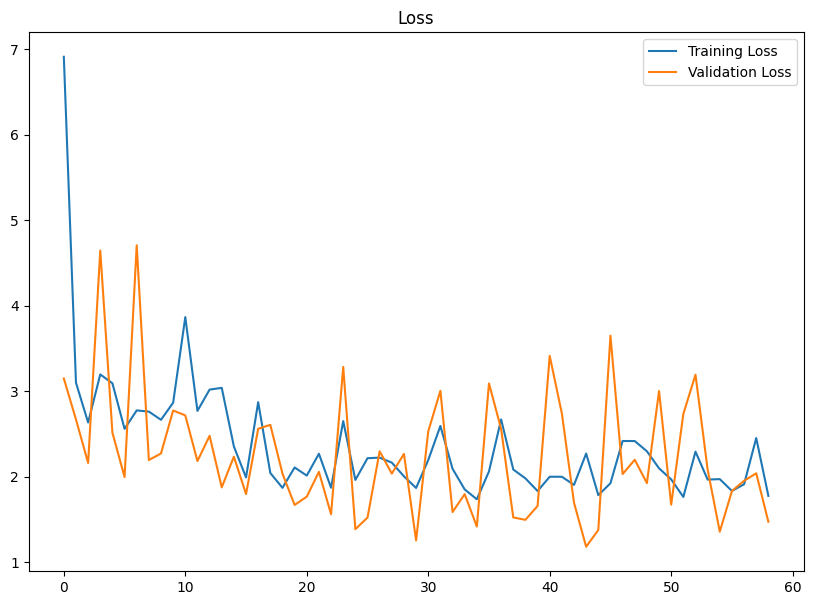

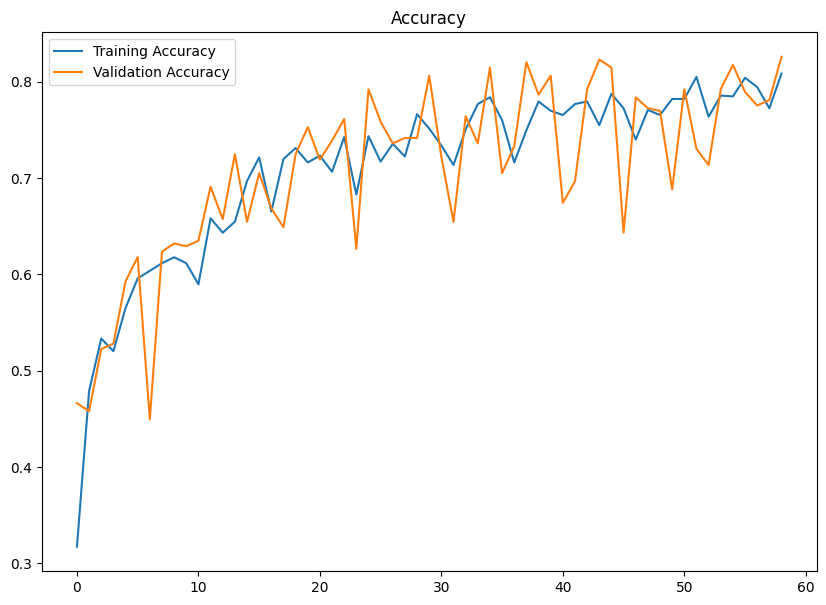

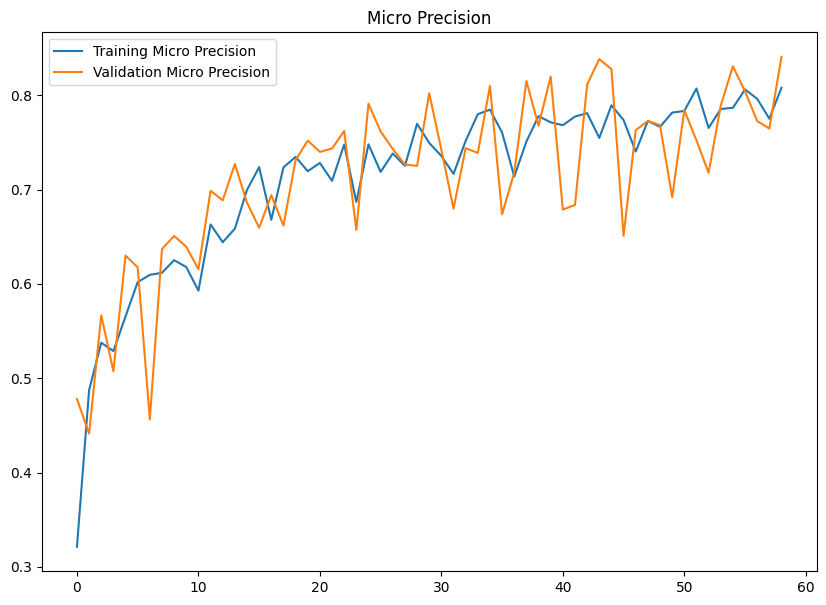

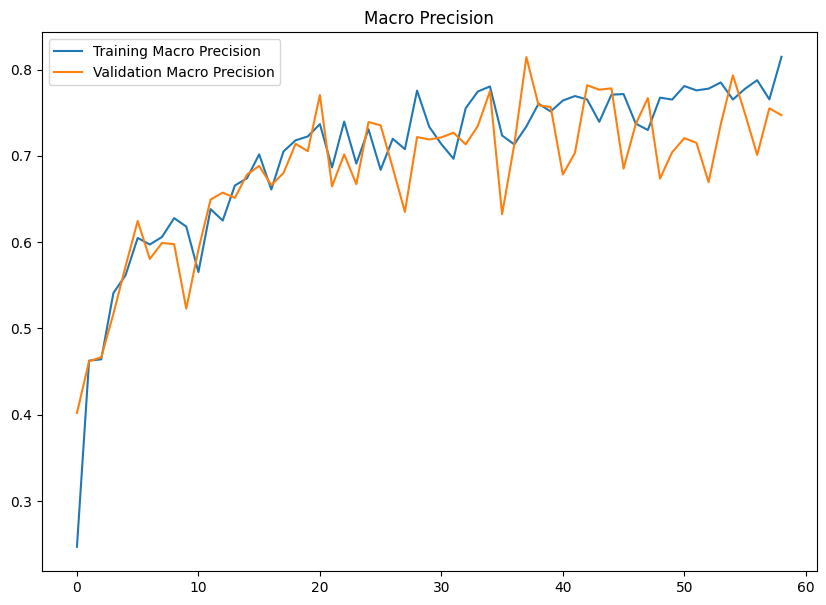

In [ ]:
#  plot the loss and accuracy
plt.figure(figsize=(10, 7))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss')

plt.figure(figsize=(10, 7))
plt.plot(history.history['categorical_accuracy'], label='Training Accuracy')
plt.plot(history.history['val_categorical_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')

plt.figure(figsize=(10, 7))
plt.plot(history.history['microprecision'], label='Training Micro Precision')
plt.plot(history.history['val_microprecision'], label='Validation Micro Precision')
plt.legend()
plt.title('Micro Precision')

plt.figure(figsize=(10, 7))
plt.plot(history.history['macroprecision'], label='Training Macro Precision')
plt.plot(history.history['val_macroprecision'], label='Validation Macro Precision')
plt.legend()
plt.title('Macro Precision')

#### Save Model

In [ ]:
# save the model
model.save('models\\InceptionV3\\inception-model-test.h5')

### InceptionV3 attempt with hyperparameter tuning

#### Define InceptionV3 model class

In [ ]:
class InceptionV3Model_class(HyperModel):
    def build(self, hp):
        inception_model = tf.keras.applications.InceptionV3(
            include_top=False,
            weights='imagenet',
            input_shape=(224, 224, 3)
        )

        #  freeze the layers
        inception_model.trainable = False
        model = tf.keras.models.Sequential([
            inception_model,
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dropout(hp.Float('dropout_rate', 0, 0.5, step=0.1)),
            tf.keras.layers.Dense(6, activation='softmax')
        ])
        optimizer = tf.keras.optimizers.Adam(learning_rate=hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4]))
        model.compile(optimizer=optimizer, 
                        loss=tf.keras.losses.CategoricalCrossentropy(), 
                        metrics=[tf.keras.metrics.CategoricalAccuracy(), macroprecision, microprecision])
        return model
    
    def fit(self, hp, model, *args, **kwargs):
        train_generator.batch_size = hp.Choice("batch_size", [32, 64, 128])
        return model.fit(
            *args,
            epochs=hp.Choice("epochs", [50, 75, 100]),
            **kwargs,
        )

#### Random search for hyperparameter tuning

In [ ]:
#  create the callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=TUNING_PAT,
    restore_best_weights=True
)

#  create the tuner
tuner = RandomSearch(
    hypermodel = InceptionV3Model_class(),
    objective='val_loss',
    seed=42,
    max_trials=50,
    executions_per_trial=2,
    overwrite=True,
    directory='models\\InceptionV3\\random_search',
    project_name='InceptionV3'
)

#  search for the best hyperparameters
tuner.search(
    train_generator,
    validation_data = test_generator,
    callbacks=[early_stopping],
)

Trial 50 Complete [00h 05m 58s]
val_loss: 1.6885340213775635

Best val_loss So Far: 0.4534218907356262
Total elapsed time: 05h 16m 00s
INFO:tensorflow:Oracle triggered exit


In [ ]:
tuner.results_summary()

Results summary
Results in models\InceptionV3\random_search\InceptionV3
Showing 10 best trials
Objective(name="val_loss", direction="min")

Trial 33 summary
Hyperparameters:
dropout_rate: 0.0
learning_rate: 0.0001
batch_size: 128
epochs: 100
Score: 0.4534218907356262

Trial 42 summary
Hyperparameters:
dropout_rate: 0.0
learning_rate: 0.0001
batch_size: 64
epochs: 75
Score: 0.5358130782842636

Trial 09 summary
Hyperparameters:
dropout_rate: 0.1
learning_rate: 0.0001
batch_size: 128
epochs: 50
Score: 0.5481984317302704

Trial 45 summary
Hyperparameters:
dropout_rate: 0.4
learning_rate: 0.0001
batch_size: 64
epochs: 100
Score: 0.5805798768997192

Trial 13 summary
Hyperparameters:
dropout_rate: 0.2
learning_rate: 0.0001
batch_size: 64
epochs: 100
Score: 0.5891461968421936

Trial 16 summary
Hyperparameters:
dropout_rate: 0.4
learning_rate: 0.0001
batch_size: 128
epochs: 50
Score: 0.59487184882164

Trial 41 summary
Hyperparameters:
dropout_rate: 0.4
learning_rate: 0.0001
batch_size: 32
epoch

In [ ]:
#  get the best hyperparameters
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]
best_hyperparameters.values

{'dropout_rate': 0.0,
 'learning_rate': 0.0001,
 'batch_size': 128,
 'epochs': 100}

#### Build the model with the best hyperparameters

##### Model Building

In [ ]:
# Build the model with the best hyperparameters
inception_tuned_model = tuner.hypermodel.build(best_hyperparameters)

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath='tf_checkpoints\\InceptionV3\\tuning_model',
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=True
)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='loss',
    patience=PAT,
    restore_best_weights=True
) 

train_generator.batch_size = best_hyperparameters.values['batch_size']

#  fit the model
history = inception_tuned_model.fit(
    train_generator,
    validation_data=test_generator,
    epochs= best_hyperparameters.values['epochs'],
    callbacks=[model_checkpoint, early_stopping]
)
# reset the generators
train_generator.reset()

Epoch 1/100
36/36 [==============================] - 15s 339ms/step - loss: 1.9828 - categorical_accuracy: 0.3137 - macroprecision: 0.2127 - microprecision: 0.3595 - val_loss: 1.6774 - val_categorical_accuracy: 0.3989 - val_macroprecision: 0.2448 - val_microprecision: 0.4674
Epoch 2/100
36/36 [==============================] - 11s 312ms/step - loss: 1.4219 - categorical_accuracy: 0.4789 - macroprecision: 0.4237 - microprecision: 0.5471 - val_loss: 1.4062 - val_categorical_accuracy: 0.4494 - val_macroprecision: 0.4730 - val_microprecision: 0.5818
Epoch 3/100
36/36 [==============================] - 11s 312ms/step - loss: 1.3418 - categorical_accuracy: 0.5070 - macroprecision: 0.4611 - microprecision: 0.5800 - val_loss: 1.3571 - val_categorical_accuracy: 0.4410 - val_macroprecision: 0.4322 - val_microprecision: 0.5685
Epoch 4/100
36/36 [==============================] - 11s 306ms/step - loss: 1.1587 - categorical_accuracy: 0.5562 - macroprecision: 0.5634 - microprecision: 0.6370 - val_lo

##### Model Classification Report

9/9 [==============================] - 1s 63ms/step
                            precision    recall  f1-score   support

Extraskeletal bone sarcoma       1.00      0.70      0.82        23
            Leiomyosarcoma       0.78      0.75      0.77        57
               Liposarcoma       0.82      0.81      0.81        68
                       MFH       0.73      0.90      0.80        87
                     Other       0.90      0.86      0.88        22
          Synovial sarcoma       0.78      0.52      0.62        27

                  accuracy                           0.79       284
                 macro avg       0.84      0.76      0.79       284
              weighted avg       0.80      0.79      0.79       284

Micro Precision:  0.7922535211267606
Macro Precision:  0.835704224893791


Text(95.7222222222222, 0.5, 'True Labels')

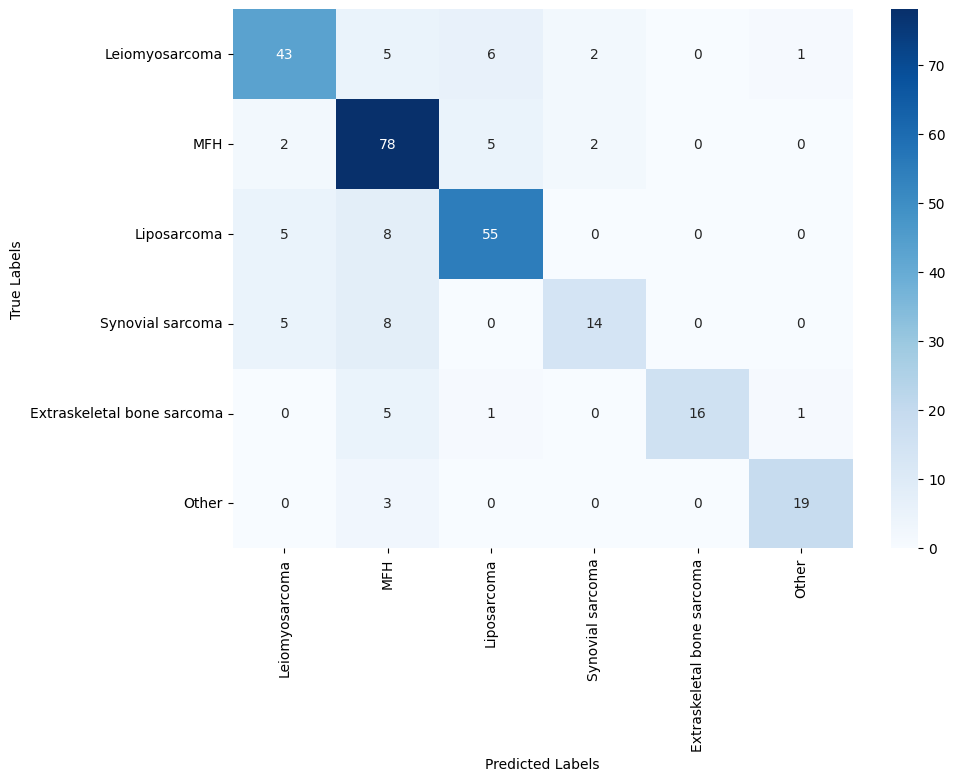

In [ ]:
#  evaluate the model
inception_tuned_model.evaluate(test_generator)

#  predict the test data
predictions = inception_tuned_model.predict(test_generator)

#  get the predicted labels
predicted_labels = np.argmax(predictions, axis=1)

#  get the true labels
true_labels = test_generator.labels

# change the true_labels to the original labels
true_labels = np.argmax(true_labels, axis=1)

predicted_labels =  change_labels(predicted_labels, y_columns)
true_labels = change_labels(true_labels, y_columns)

#  print the classification report
print(classification_report(true_labels, predicted_labels))

#  print micro precision
micro_precision = precision_score(true_labels, predicted_labels, average='micro')
print('Micro Precision: ', micro_precision)

# print  macro precision
macro_precision = precision_score(true_labels, predicted_labels, average='macro')
print('Macro Precision: ', macro_precision)

# get the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels, labels=y_columns)

#  plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=y_columns, yticklabels=y_columns)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')

##### Model History

Text(0.5, 1.0, 'Macro Precision')

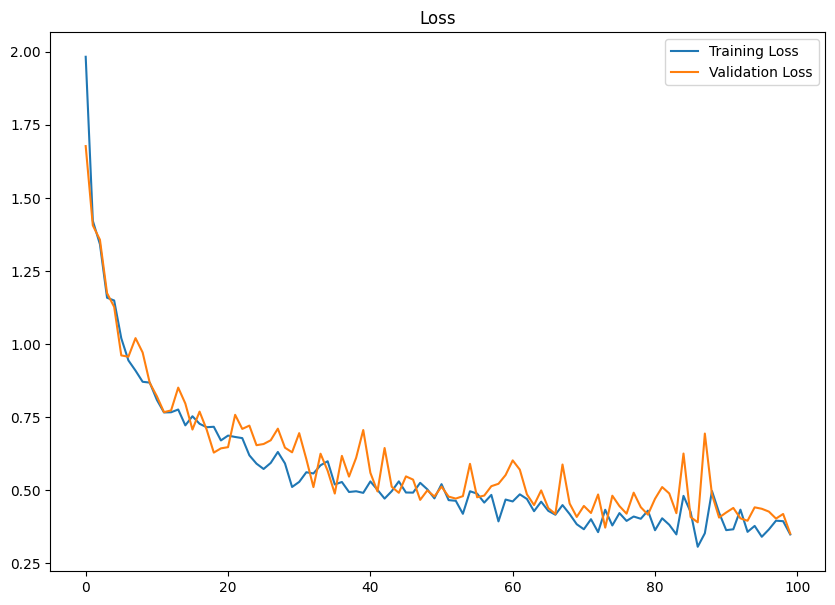

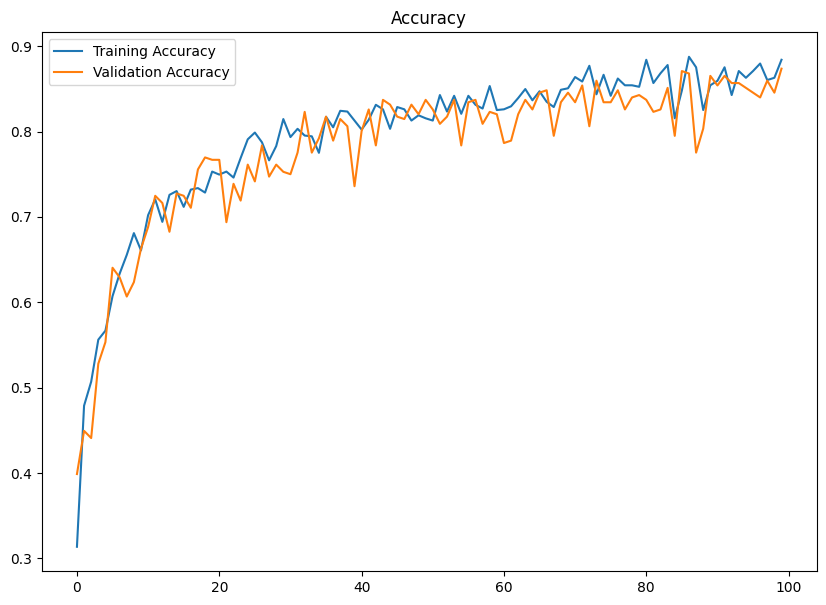

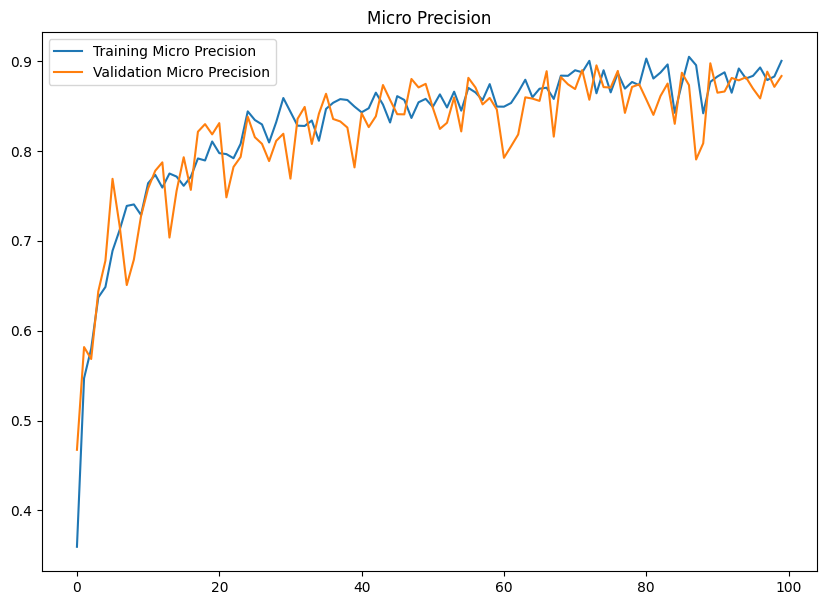

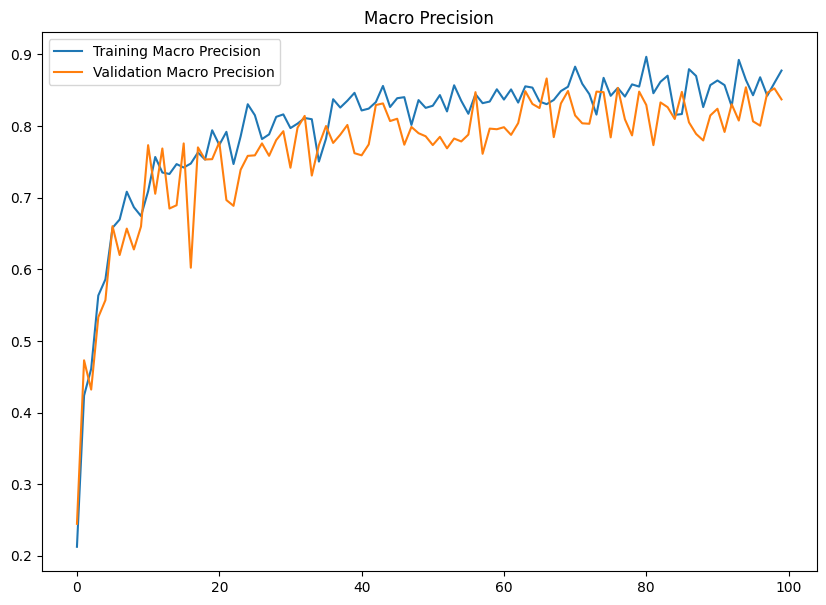

In [ ]:
#  plot the loss and accuracy
plt.figure(figsize=(10, 7))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss')

plt.figure(figsize=(10, 7))
plt.plot(history.history['categorical_accuracy'], label='Training Accuracy')
plt.plot(history.history['val_categorical_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')

plt.figure(figsize=(10, 7))
plt.plot(history.history['microprecision'], label='Training Micro Precision')
plt.plot(history.history['val_microprecision'], label='Validation Micro Precision')
plt.legend()
plt.title('Micro Precision')

plt.figure(figsize=(10, 7))
plt.plot(history.history['macroprecision'], label='Training Macro Precision')
plt.plot(history.history['val_macroprecision'], label='Validation Macro Precision')
plt.legend()
plt.title('Macro Precision')

##### Save Model

In [ ]:
#  save the model
inception_tuned_model.save('models\\InceptionV3\\inception-model-tuned.h5')

### InceptionV3 Cross Validation

In [ ]:
# cross validation
skf = StratifiedKFold(n_splits = 5, shuffle=True, random_state=42)
i = 1
incep_hist = []
incep_accuracy = []
incep_micro_precision = []
incep_macro_precision = []
X = train_df['Image Path']
y = train_df['Label']

for train_index, test_index in skf.split(X, y):
    if i != 1:
        print('\n')
    print('-'*50)
    print('Fold ', i)
    print('-'*50)
    model_checkpoint_cv = tf.keras.callbacks.ModelCheckpoint(
        filepath='tf_checkpoints\\InceptionV3\\cv_model\\model_' + str(i),
        monitor='val_loss',
        save_best_only=True,
        save_weights_only=True
    )

    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='loss',
        patience=PAT,
        restore_best_weights=True
    ) 
    
    train_data_cv  = train_df.iloc[train_index]
    test_data_cv  = train_df.iloc[test_index]
    
    train_data_cv, _ = ros.fit_resample(train_data_cv, train_data_cv['Label'])  
    
    train_generator_cv = train_datagen.flow_from_dataframe(
        dataframe=train_data_cv,
        x_col='Image Path',
        y_col= y_columns,
        target_size=(224, 224),
        batch_size=best_hyperparameters.values['batch_size'],
        class_mode='raw',
        shuffle=True,
        seed=42,
        verbose=0
    )

    test_generator_cv = test_datagen.flow_from_dataframe(
        dataframe=test_data_cv,
        x_col='Image Path',
        y_col= y_columns,
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        shuffle=False,
        verbose=0
    )

    inception_tuned_model_cv = tuner.hypermodel.build(best_hyperparameters)

    incep_hist.append(inception_tuned_model_cv.fit(
        train_generator_cv,
        epochs=best_hyperparameters.values['epochs'],
        callbacks=[model_checkpoint, early_stopping],
        validation_data=test_generator_cv,
        verbose=0
    ))

    print('\nModel ' + str(i) + ' evaluation:')
    inception_tuned_model_cv.evaluate(test_generator_cv, verbose=0)
    predictions = inception_tuned_model_cv.predict(test_generator_cv, verbose=0)
    predicted_labels = np.argmax(predictions, axis=1)
    true_labels = test_generator_cv.labels
    true_labels = np.argmax(true_labels, axis=1)
    predicted_labels =  change_labels(predicted_labels, y_columns)
    true_labels = change_labels(true_labels, y_columns)
    #  record the metrics
    incep_accuracy.append(accuracy_score(true_labels, predicted_labels))
    incep_micro_precision.append(precision_score(true_labels, predicted_labels, average='micro'))
    incep_macro_precision.append(precision_score(true_labels, predicted_labels, average='macro'))
    print('Accuracy: ', incep_accuracy[i-1], '\nMicro Precision: ', incep_micro_precision[i-1], '\nMacro Precision: ', incep_macro_precision[i-1])
    i += 1

print('\n')
print('-'*50)
print('Results:')
print('Average accuracy: ', np.mean(incep_accuracy))
print('Average micro precision: ', np.mean(incep_micro_precision))
print('Average macro precision: ', np.mean(incep_macro_precision))

--------------------------------------------------
Fold  1
--------------------------------------------------
Found 1137 validated image filenames.
Found 285 validated image filenames.

Model 1 evaluation:
Accuracy:  0.8385964912280702 
Micro Precision:  0.8385964912280702 
Macro Precision:  0.8157576055408873


--------------------------------------------------
Fold  2
--------------------------------------------------
Found 1137 validated image filenames.
Found 285 validated image filenames.

Model 2 evaluation:
Accuracy:  0.8035087719298246 
Micro Precision:  0.8035087719298246 
Macro Precision:  0.8209712744692584


--------------------------------------------------
Fold  3
--------------------------------------------------
Found 1138 validated image filenames.
Found 284 validated image filenames.

Model 3 evaluation:
Accuracy:  0.8767605633802817 
Micro Precision:  0.8767605633802817 
Macro Precision:  0.8739319496560349


--------------------------------------------------
Fold  4

## EfficientNet Model

In [234]:
# change batch size back to 32
train_generator.batch_size = 32

# create efficientnet model
efficientnet_model = tf.keras.applications.EfficientNetB0(
    include_top=False,
    weights='imagenet',
    input_shape=(224, 224, 3)
)

#  freeze the layers
efficientnet_model.trainable = False

16705208/16705208 [==============================] - 2s 0us/step


### EfficientNet attempt without hyperparameter tuning

#### Model Building

In [ ]:
# create the model
model = tf.keras.Sequential([
    efficientnet_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(len(y_columns), activation='softmax')
])

In [248]:
# create the model
model = tf.keras.Sequential([
    efficientnet_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(len(y_columns), activation='softmax')
])

#  compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=[tf.keras.metrics.CategoricalAccuracy(), macroprecision, microprecision]
)

#  create the callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=PAT,
    restore_best_weights=True
)

# create the model checkpoint
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath='tf_checkpoints\\EfficientNet\\model_checkpoint',
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=True
)

# reset the generators
train_generator.reset()
test_generator.reset()

# fit the model
history = model.fit(
    train_generator,
    validation_data=test_generator,
    epochs=100,
    callbacks=[model_checkpoint, early_stopping]
)

# reset the generators
train_generator.reset()
test_generator.reset()

Epoch 1/100
36/36 [==============================] - 17s 361ms/step - loss: 1.7031 - categorical_accuracy: 0.2777 - macroprecision: 0.0066 - microprecision: 0.0396 - val_loss: 1.6844 - val_categorical_accuracy: 0.2022 - val_macroprecision: 0.0000e+00 - val_microprecision: 0.0000e+00
Epoch 2/100
36/36 [==============================] - 11s 314ms/step - loss: 1.6700 - categorical_accuracy: 0.2777 - macroprecision: 0.0000e+00 - microprecision: 0.0000e+00 - val_loss: 1.7004 - val_categorical_accuracy: 0.3062 - val_macroprecision: 0.0000e+00 - val_microprecision: 0.0000e+00
Epoch 3/100
36/36 [==============================] - 12s 325ms/step - loss: 1.6749 - categorical_accuracy: 0.3076 - macroprecision: 0.0000e+00 - microprecision: 0.0000e+00 - val_loss: 1.6618 - val_categorical_accuracy: 0.3062 - val_macroprecision: 0.0000e+00 - val_microprecision: 0.0000e+00
Epoch 4/100
36/36 [==============================] - 12s 331ms/step - loss: 1.6635 - categorical_accuracy: 0.3076 - macroprecision: 

KeyboardInterrupt: 

#### Model Classification Report

9/9 [==============================] - 1s 40ms/step
                            precision    recall  f1-score   support

Extraskeletal bone sarcoma       0.00      0.00      0.00        23
            Leiomyosarcoma       0.00      0.00      0.00        57
               Liposarcoma       0.00      0.00      0.00        68
                       MFH       0.31      1.00      0.47        87
                     Other       0.00      0.00      0.00        22
          Synovial sarcoma       0.00      0.00      0.00        27

                  accuracy                           0.31       284
                 macro avg       0.05      0.17      0.08       284
              weighted avg       0.09      0.31      0.14       284

Macro Precision:  0.05105633802816901
Micro Precision:  0.30633802816901406


Text(95.7222222222222, 0.5, 'True Labels')

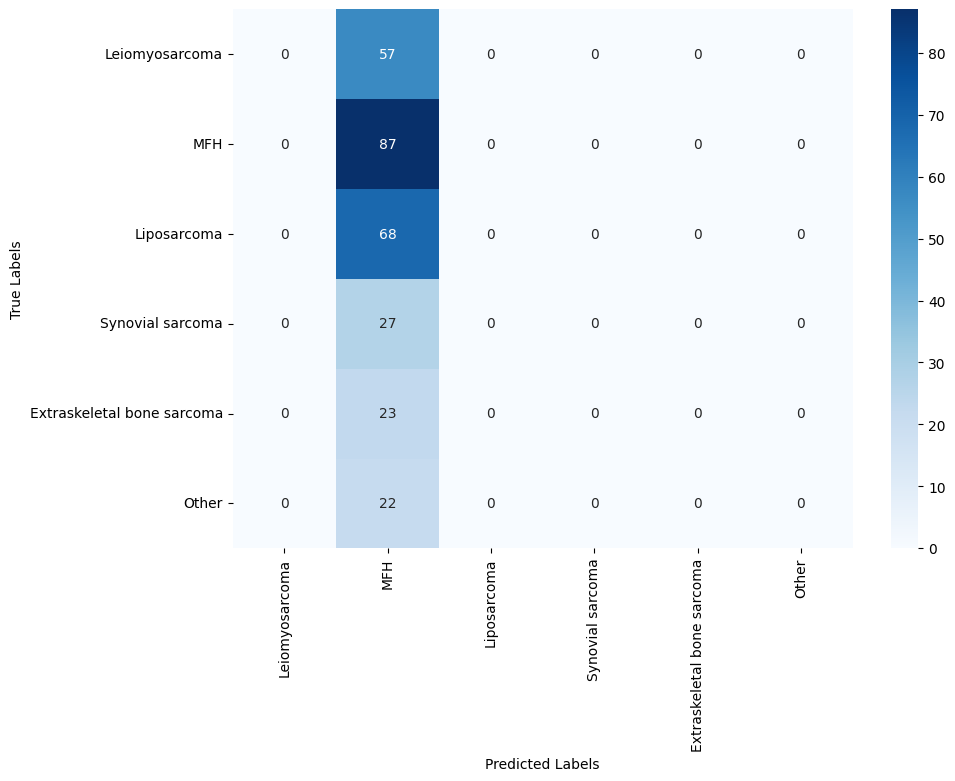

In [236]:
#  evaluate the model
model.evaluate(test_generator)

#  predict the test data
predictions = model.predict(test_generator)

#  get the predicted labels
predicted_labels = np.argmax(predictions, axis=1)

#  get the true labels
true_labels = test_generator.labels

# change the true_labels to the original labels
true_labels = np.argmax(true_labels, axis=1)

predicted_labels =  change_labels(predicted_labels, y_columns)
true_labels = change_labels(true_labels, y_columns)

#  print the classification report
print(classification_report(true_labels, predicted_labels))

#  print macro precision
micro_precision = precision_score(true_labels, predicted_labels, average='macro')
print('Macro Precision: ', micro_precision)

#  print micro precision
micro_precision = precision_score(true_labels, predicted_labels, average='micro')
print('Micro Precision: ', micro_precision)

#  get the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels, labels=y_columns)

#  plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=y_columns, yticklabels=y_columns)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')

#### Model History

Text(0.5, 1.0, 'Macro Precision')

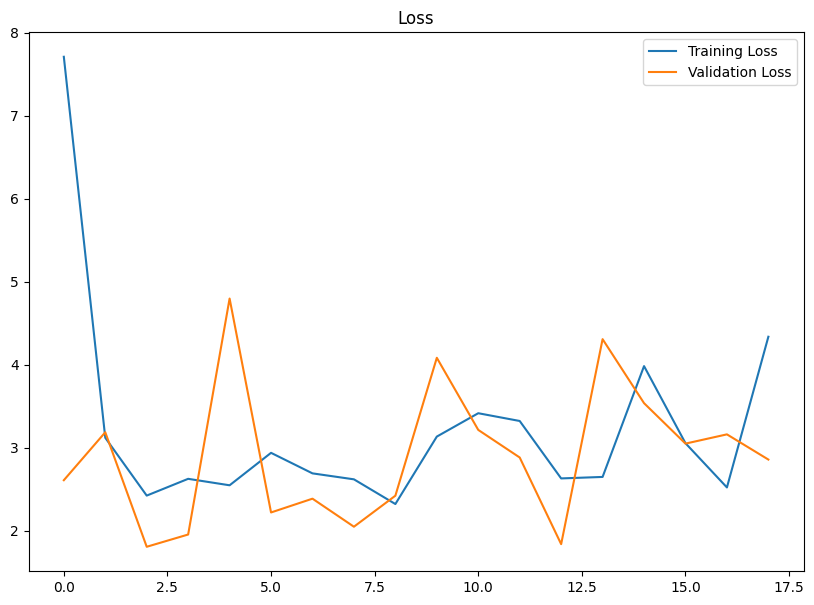

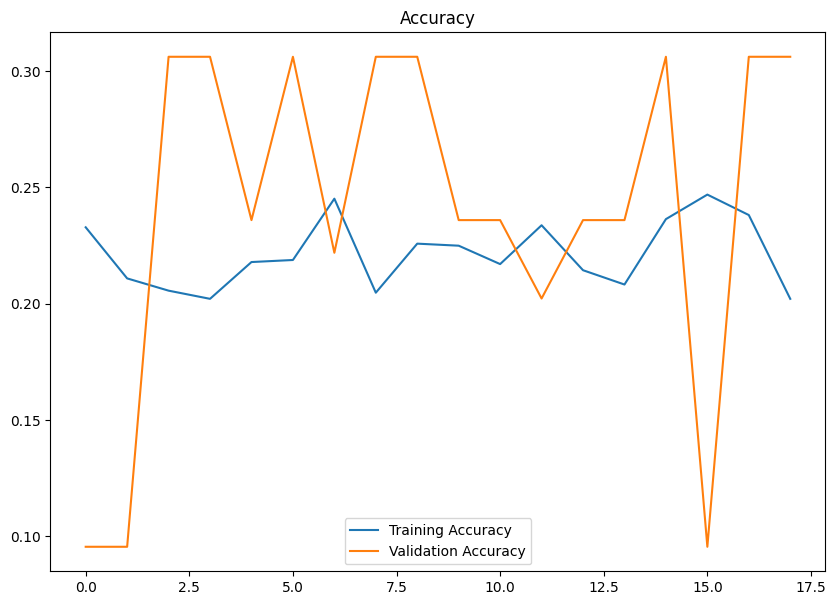

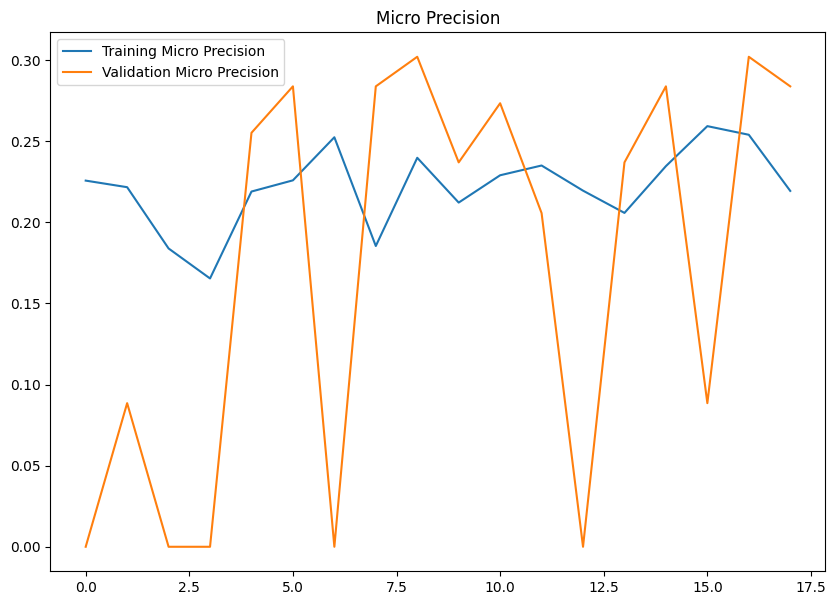

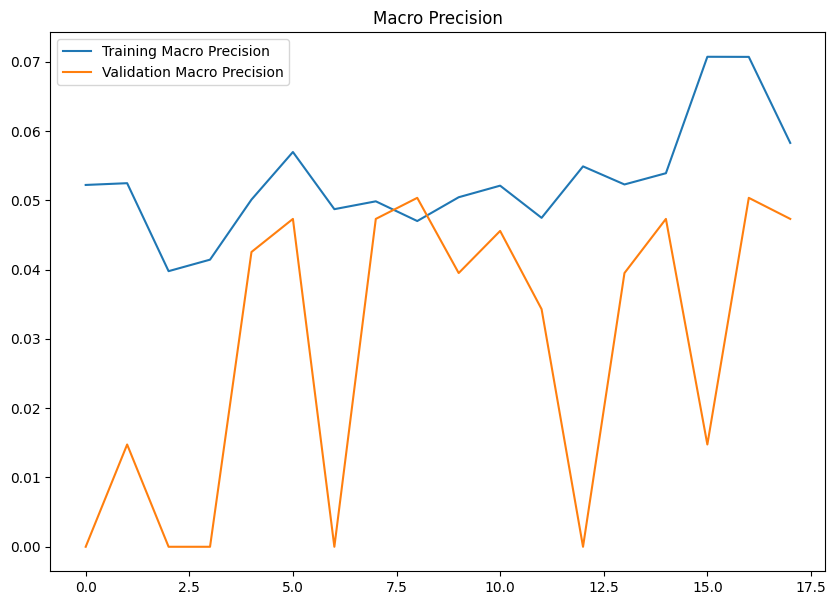

In [237]:
#  plot the loss and accuracy
plt.figure(figsize=(10, 7))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss')

plt.figure(figsize=(10, 7))
plt.plot(history.history['categorical_accuracy'], label='Training Accuracy')
plt.plot(history.history['val_categorical_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')

plt.figure(figsize=(10, 7))
plt.plot(history.history['microprecision'], label='Training Micro Precision')
plt.plot(history.history['val_microprecision'], label='Validation Micro Precision')
plt.legend()
plt.title('Micro Precision')

plt.figure(figsize=(10, 7))
plt.plot(history.history['macroprecision'], label='Training Macro Precision')
plt.plot(history.history['val_macroprecision'], label='Validation Macro Precision')
plt.legend()
plt.title('Macro Precision')

#### Save Model

In [238]:
model.save('models\\EfficientNet\\efficientnet-model-test.h5')

TypeError: Unable to serialize [2.0896919 2.1128857 2.1081853] to JSON. Unrecognized type <class 'tensorflow.python.framework.ops.EagerTensor'>.

### EfficientNet attempt with hyperparameter tuning

#### Define EfficientNet model class

In [ ]:
class EfficientNetModel_class(HyperModel):
    def build(self, hp):
        efficientnet_model = tf.keras.applications.EfficientNetB0(
            include_top=False,
            weights='imagenet',
            input_shape=(224, 224, 3)
        )

        #  freeze the layers
        efficientnet_model.trainable = False
        model = tf.keras.models.Sequential([
            efficientnet_model,
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dropout(hp.Float('dropout_rate', 0, 0.5, step=0.1)),
            tf.keras.layers.Dense(6, activation='softmax')
        ])
        optimizer = tf.keras.optimizers.Adam(learning_rate=hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4]))
        model.compile(optimizer=optimizer, 
                        loss=tf.keras.losses.CategoricalCrossentropy(), 
                        metrics=[tf.keras.metrics.CategoricalAccuracy(), macroprecision, microprecision])
        return model
    
    def fit(self, hp, model, *args, **kwargs):
        train_generator.batch_size = hp.Choice("batch_size", [32, 64, 128])
        return model.fit(
            *args,
            epochs=hp.Choice("epochs", [50, 75, 100]),
            **kwargs,
        )

#### Random search for hyperparameter tuning

In [ ]:
#  create the callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=TUNING_PAT,
    restore_best_weights=True
)

#  create the tuner
tuner = RandomSearch(
    hypermodel = EfficientNetModel_class(),
    objective='val_loss',
    seed=42,
    max_trials=50,
    executions_per_trial=2,
    overwrite=True,
    directory='models\\EfficientNet\\random_search',
    project_name='EfficientNet'
)

#  search for the best hyperparameters
tuner.search(
    train_generator,
    validation_data = test_generator,
    callbacks=[early_stopping],
)

In [ ]:
tuner.results_summary()

In [ ]:
#  get the best hyperparameters
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]
best_hyperparameters.values

#### Build the model with the best hyperparameters

##### Model Building

In [ ]:
# Build the model with the best hyperparameters
efficientnet_tuned_model = tuner.hypermodel.build(best_hyperparameters)

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath='tf_checkpoints\\EfficientNet\\tuning_model',
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=True
)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='loss',
    patience=PAT,
    restore_best_weights=True
) 

train_generator.batch_size = best_hyperparameters.values['batch_size']

#  fit the model
history = efficientnet_tuned_model.fit(
    train_generator,
    validation_data=test_generator,
    epochs= best_hyperparameters.values['epochs'],
    callbacks=[model_checkpoint, early_stopping]
)
# reset the generators
train_generator.reset()
test_generator.reset()

##### Model Classification Report

In [ ]:
#  evaluate the model
efficientnet_tuned_model.evaluate(test_generator)

#  predict the test data
predictions = efficientnet_tuned_model.predict(test_generator)

#  get the predicted labels
predicted_labels = np.argmax(predictions, axis=1)

#  get the true labels
true_labels = test_generator.labels

# change the true_labels to the original labels
true_labels = np.argmax(true_labels, axis=1)

predicted_labels =  change_labels(predicted_labels, y_columns)
true_labels = change_labels(true_labels, y_columns)

#  print the classification report
print(classification_report(true_labels, predicted_labels))

#  print micro precision
micro_precision = precision_score(true_labels, predicted_labels, average='micro')
print('Micro Precision: ', micro_precision)

# print  macro precision
macro_precision = precision_score(true_labels, predicted_labels, average='macro')
print('Macro Precision: ', macro_precision)

##### Model History

In [ ]:
#  plot the loss and accuracy
plt.figure(figsize=(10, 7))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss')

plt.figure(figsize=(10, 7))
plt.plot(history.history['categorical_accuracy'], label='Training Accuracy')
plt.plot(history.history['val_categorical_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')

plt.figure(figsize=(10, 7))
plt.plot(history.history['microprecision'], label='Training Micro Precision')
plt.plot(history.history['val_microprecision'], label='Validation Micro Precision')
plt.legend()
plt.title('Micro Precision')

plt.figure(figsize=(10, 7))
plt.plot(history.history['macroprecision'], label='Training Macro Precision')
plt.plot(history.history['val_macroprecision'], label='Validation Macro Precision')
plt.legend()
plt.title('Macro Precision')

##### Save Model

In [ ]:
#  save the model
restnet_tuned_model.save('models\\EfficientNet\\efficientnet-model-tuned.h5')

### EfficientNet Cross Validation

In [ ]:
# cross validation
skf = StratifiedKFold(n_splits = 5, shuffle=True, random_state=42)
i = 1
eff_hist = []
eff_accuracy = []
eff_micro_precision = []
eff_macro_precision = []
X = train_df['Image Path']
y = train_df['Label']

for train_index, test_index in skf.split(X, y):
    if i != 1:
        print('\n')
    print('-'*50)
    print('Fold ', i)
    print('-'*50)
    model_checkpoint_cv = tf.keras.callbacks.ModelCheckpoint(
        filepath='tf_checkpoints\\EfficientNet\\cv_model\\model_' + str(i),
        monitor='val_loss',
        save_best_only=True,
        save_weights_only=True
    )

    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='loss',
        patience=PAT,
        restore_best_weights=True
    ) 
    
    train_data_cv  = train_df.iloc[train_index]
    test_data_cv  = train_df.iloc[test_index]
    
    train_data_cv, _ = ros.fit_resample(train_data_cv, train_data_cv['Label'])  
    
    train_generator_cv = train_datagen.flow_from_dataframe(
        dataframe=train_data_cv,
        x_col='Image Path',
        y_col= y_columns,
        target_size=(224, 224),
        batch_size= best_hyperparameters.values['batch_size'],
        class_mode='raw',
        shuffle=True,
        seed=42,
        verbose=0
    )

    test_generator_cv = test_datagen.flow_from_dataframe(
        dataframe=test_data_cv,
        x_col='Image Path',
        y_col= y_columns,
        target_size=(224, 224),
        batch_size= 32,
        class_mode='raw',
        shuffle=False,
        verbose=0
    )

    efficientnet_tuned_model_cv = tuner.hypermodel.build(best_hyperparameters)

    eff_hist.append(efficientnet_tuned_model_cv.fit(
        train_generator_cv,
        epochs= best_hyperparameters.values['epochs'],
        callbacks=[model_checkpoint, early_stopping],
        validation_data=test_generator_cv,
        verbose=0
    ))

    print('\nModel ' + str(i) + ' evaluation:')
    efficientnet_tuned_model_cv.evaluate(test_generator_cv, verbose=0)
    predictions = efficientnet_tuned_model_cv.predict(test_generator_cv, verbose=0)
    predicted_labels = np.argmax(predictions, axis=1)
    true_labels = test_generator_cv.labels
    true_labels = np.argmax(true_labels, axis=1)
    predicted_labels =  change_labels(predicted_labels, y_columns)
    true_labels = change_labels(true_labels, y_columns)
    #  record the metrics
    eff_accuracy.append(accuracy_score(true_labels, predicted_labels))
    eff_micro_precision.append(precision_score(true_labels, predicted_labels, average='micro'))
    eff_macro_precision.append(precision_score(true_labels, predicted_labels, average='macro'))
    print('Accuracy: ', eff_accuracy[i-1], '\nMicro Precision: ', eff_micro_precision[i-1], '\nMacro Precision: ', eff_macro_precision[i-1])
    i += 1

print('\n')
print('-'*50)
print('Results:')
print('Average accuracy: ', np.mean(eff_accuracy))
print('Average micro precision: ', np.mean(eff_micro_precision))
print('Average macro precision: ', np.mean(eff_macro_precision))

## xception Model

In [249]:
# change batch size back to 32
train_generator.batch_size = 32

# xception model
xception_model = tf.keras.applications.Xception(
    include_top=False,
    weights='imagenet',
    input_shape=(224, 224, 3)
)

# freeze the base model
xception_model.trainable = False

83683744/83683744 [==============================] - 8s 0us/step


### xception attempt without hyperparameter tuning

#### Model Building

In [250]:
# model sequential
model = tf.keras.Sequential([
    xception_model,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(6, activation='softmax')
])

#  compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=[tf.keras.metrics.CategoricalAccuracy(), macroprecision, microprecision]
)

#  create the callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=PAT,
    restore_best_weights=True
)

# create the model checkpoint
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath='tf_checkpoints\\xception\\model_checkpoint',
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=True
)

# reset the generators
train_generator.reset()
test_generator.reset()

# fit the model
history = model.fit(
    train_generator,
    epochs=100,
    callbacks=[model_checkpoint, early_stopping],
    validation_data=test_generator,
    verbose=1
)

Epoch 1/100
36/36 [==============================] - 15s 352ms/step - loss: 5.8819 - categorical_accuracy: 0.3480 - macroprecision: 0.2889 - microprecision: 0.3493 - val_loss: 3.3518 - val_categorical_accuracy: 0.4270 - val_macroprecision: 0.3196 - val_microprecision: 0.4534
Epoch 2/100
36/36 [==============================] - 12s 329ms/step - loss: 2.7956 - categorical_accuracy: 0.5035 - macroprecision: 0.4797 - microprecision: 0.5150 - val_loss: 2.4366 - val_categorical_accuracy: 0.5421 - val_macroprecision: 0.6016 - val_microprecision: 0.5931
Epoch 3/100
36/36 [==============================] - 12s 338ms/step - loss: 1.8842 - categorical_accuracy: 0.6054 - macroprecision: 0.5574 - microprecision: 0.6161 - val_loss: 2.0975 - val_categorical_accuracy: 0.6208 - val_macroprecision: 0.6378 - val_microprecision: 0.6531
Epoch 4/100
36/36 [==============================] - 11s 316ms/step - loss: 2.2404 - categorical_accuracy: 0.5703 - macroprecision: 0.5701 - microprecision: 0.5835 - val_lo

#### Model classification report

9/9 [==============================] - 1s 66ms/step
                            precision    recall  f1-score   support

Extraskeletal bone sarcoma       0.72      0.57      0.63        23
            Leiomyosarcoma       0.71      0.77      0.74        57
               Liposarcoma       0.72      0.72      0.72        68
                       MFH       0.75      0.78      0.76        87
                     Other       0.82      0.82      0.82        22
          Synovial sarcoma       0.70      0.59      0.64        27

                  accuracy                           0.73       284
                 macro avg       0.74      0.71      0.72       284
              weighted avg       0.73      0.73      0.73       284

Macro Precision:  0.735595769369798
Micro Precision:  0.7323943661971831


Text(95.7222222222222, 0.5, 'True Labels')

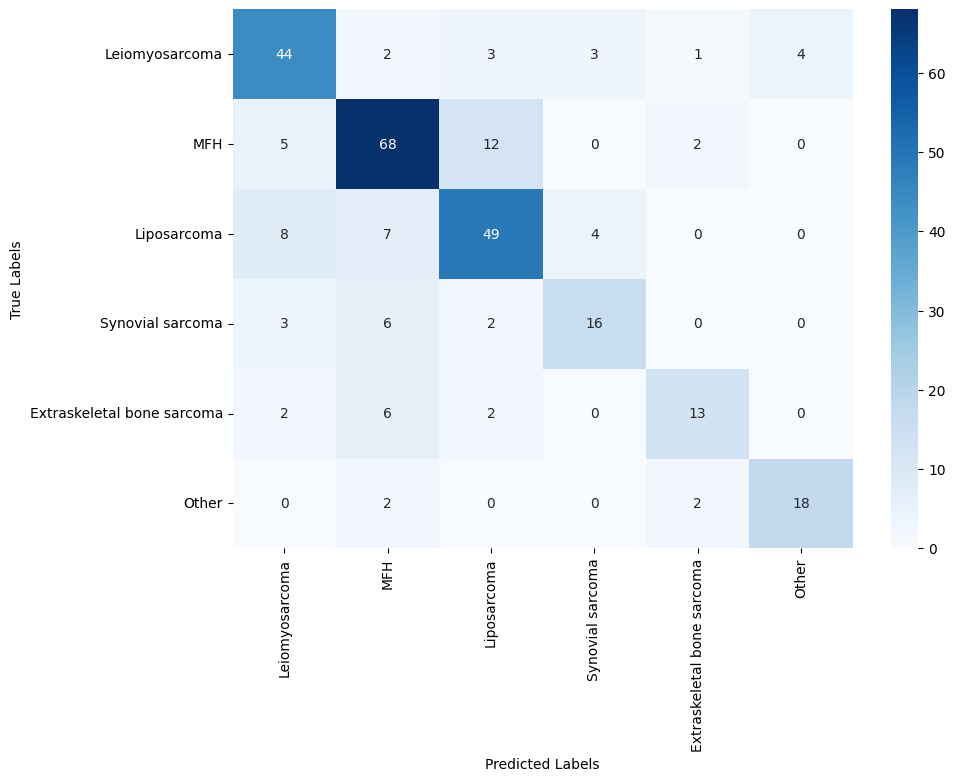

In [251]:
#  evaluate the model
model.evaluate(test_generator)

#  predict the test data
predictions = model.predict(test_generator)

#  get the predicted labels
predicted_labels = np.argmax(predictions, axis=1)

#  get the true labels
true_labels = test_generator.labels

# change the true_labels to the original labels
true_labels = np.argmax(true_labels, axis=1)

predicted_labels =  change_labels(predicted_labels, y_columns)
true_labels = change_labels(true_labels, y_columns)

#  print the classification report
print(classification_report(true_labels, predicted_labels))

#  print macro precision
micro_precision = precision_score(true_labels, predicted_labels, average='macro')
print('Macro Precision: ', micro_precision)

#  print micro precision
micro_precision = precision_score(true_labels, predicted_labels, average='micro')
print('Micro Precision: ', micro_precision)

#  get the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels, labels=y_columns)

#  plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=y_columns, yticklabels=y_columns)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')

#### Model History

Text(0.5, 1.0, 'Macro Precision')

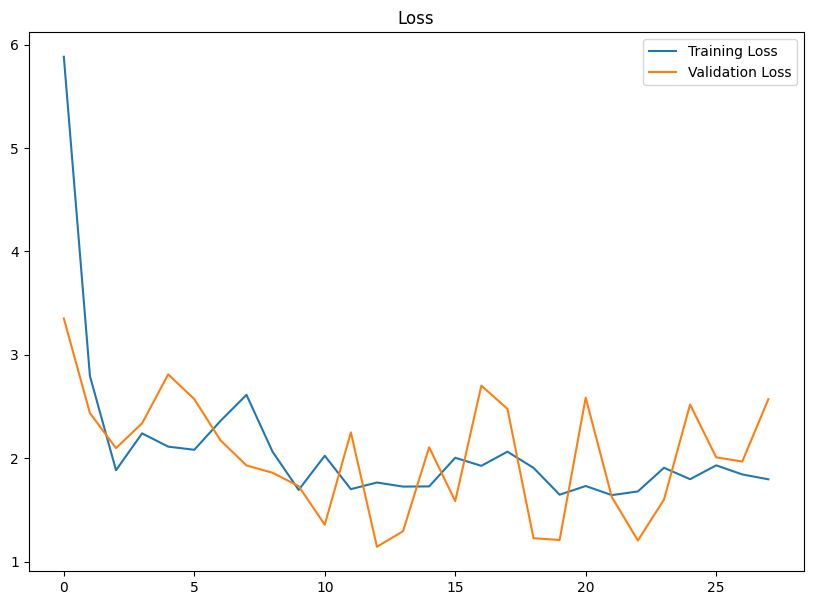

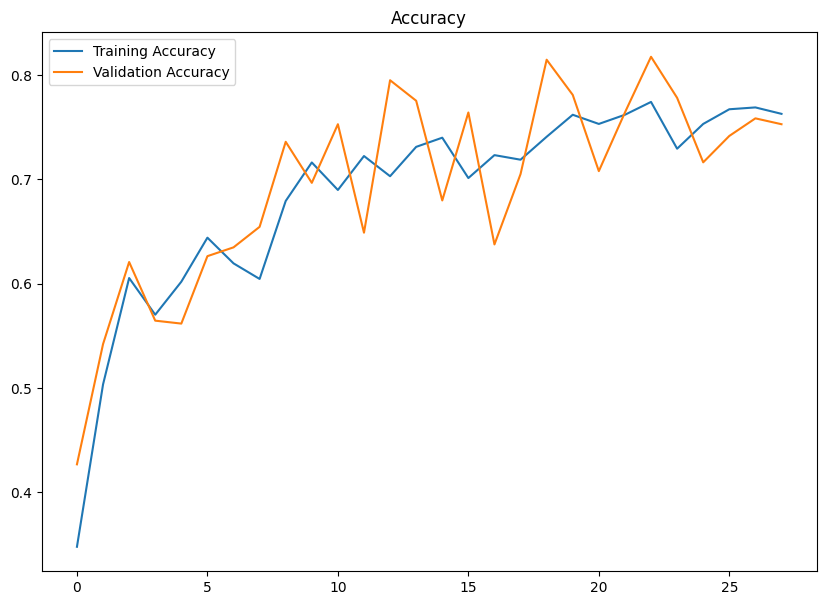

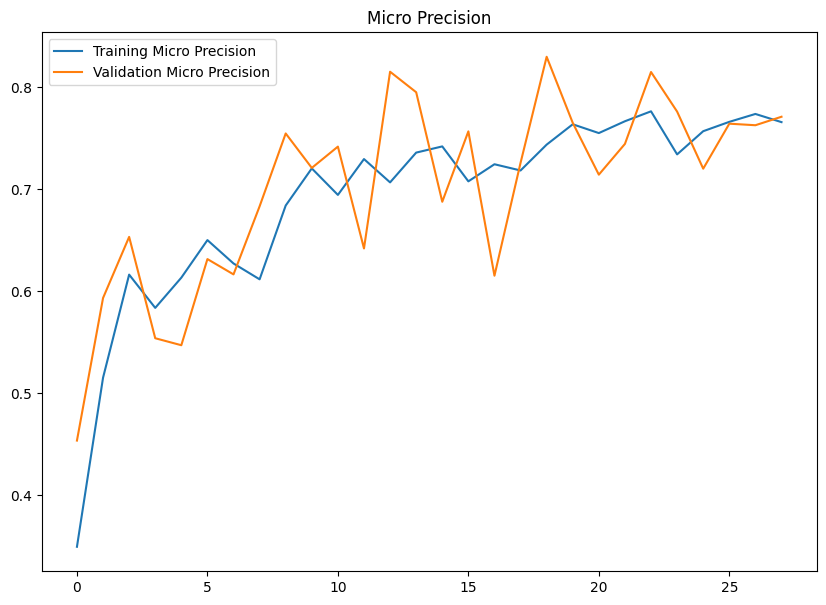

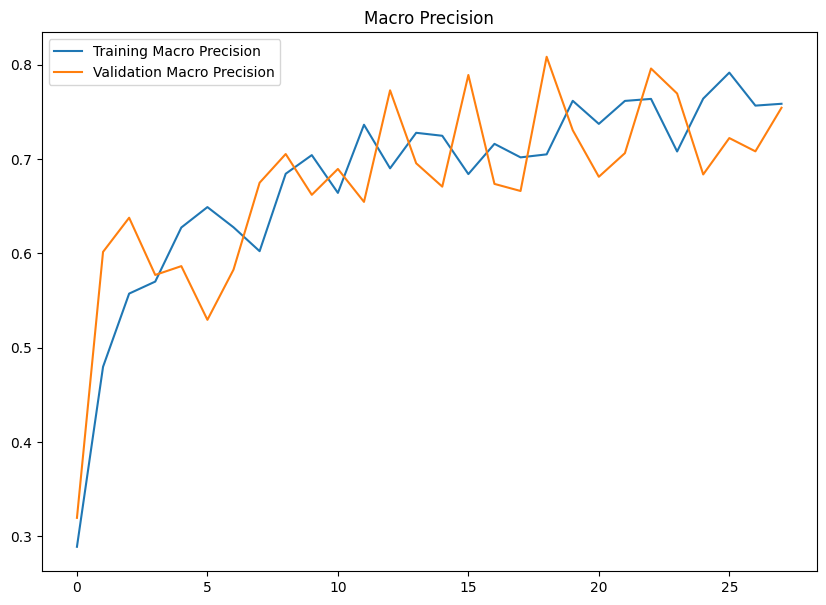

In [252]:
#  plot the loss and accuracy
plt.figure(figsize=(10, 7))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss')

plt.figure(figsize=(10, 7))
plt.plot(history.history['categorical_accuracy'], label='Training Accuracy')
plt.plot(history.history['val_categorical_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')

plt.figure(figsize=(10, 7))
plt.plot(history.history['microprecision'], label='Training Micro Precision')
plt.plot(history.history['val_microprecision'], label='Validation Micro Precision')
plt.legend()
plt.title('Micro Precision')

plt.figure(figsize=(10, 7))
plt.plot(history.history['macroprecision'], label='Training Macro Precision')
plt.plot(history.history['val_macroprecision'], label='Validation Macro Precision')
plt.legend()
plt.title('Macro Precision')

#### Save Model

In [253]:
#  save the model
model.save('models\\xception\\xceptionl-test.h5')

### xception attempt with hyperparameter tuning

#### Define xception model class

In [254]:
class xception_class(HyperModel):
    def build(self, hp):
        xception_model = tf.keras.applications.Xception(
            include_top=False,
            weights='imagenet',
            input_shape=(224, 224, 3)
        )
        xception_model.trainable = False
        model = tf.keras.models.Sequential([
            xception_model,
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dropout(hp.Float('dropout_rate', 0, 0.5, step=0.1)),
            tf.keras.layers.Dense(6, activation='softmax')
        ])
        optimizer = tf.keras.optimizers.Adam(learning_rate=hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4]))
        model.compile(optimizer=optimizer, 
                        loss=tf.keras.losses.CategoricalCrossentropy(), 
                        metrics=[tf.keras.metrics.CategoricalAccuracy(), macroprecision, microprecision])
        return model
    
    def fit(self, hp, model, *args, **kwargs):
        train_generator.batch_size = hp.Choice("batch_size", [32, 64, 128])
        return model.fit(
            *args,
            epochs=hp.Choice("epochs", [50, 75, 100]),
            **kwargs,
        )

#### Random search for hyperparameter tuning

In [255]:
#  create the callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=TUNING_PAT,
    restore_best_weights=True
)

#  create the tuner
tuner = RandomSearch(
    hypermodel = xception_class(),
    objective='val_loss',
    seed=42,
    max_trials=50,
    executions_per_trial=2,
    overwrite=True,
    directory='models\\xception\\random_search',
    project_name='xception'
)

#  search for the best hyperparameters
tuner.search(
    train_generator,
    validation_data = test_generator,
    callbacks=[early_stopping],
)

Trial 50 Complete [00h 04m 50s]
val_loss: 1.7961886525154114

Best val_loss So Far: 0.46916423738002777
Total elapsed time: 05h 01m 49s
INFO:tensorflow:Oracle triggered exit


#### Tuning results

In [256]:
tuner.results_summary()

Results summary
Results in models\xception\random_search\xception
Showing 10 best trials
Objective(name="val_loss", direction="min")

Trial 16 summary
Hyperparameters:
dropout_rate: 0.4
learning_rate: 0.0001
batch_size: 128
epochs: 50
Score: 0.46916423738002777

Trial 33 summary
Hyperparameters:
dropout_rate: 0.0
learning_rate: 0.0001
batch_size: 128
epochs: 100
Score: 0.5483468621969223

Trial 25 summary
Hyperparameters:
dropout_rate: 0.2
learning_rate: 0.0001
batch_size: 32
epochs: 75
Score: 0.5503692924976349

Trial 41 summary
Hyperparameters:
dropout_rate: 0.4
learning_rate: 0.0001
batch_size: 32
epochs: 100
Score: 0.5510706603527069

Trial 42 summary
Hyperparameters:
dropout_rate: 0.0
learning_rate: 0.0001
batch_size: 64
epochs: 75
Score: 0.5512222051620483

Trial 07 summary
Hyperparameters:
dropout_rate: 0.30000000000000004
learning_rate: 0.0001
batch_size: 128
epochs: 50
Score: 0.5576024055480957

Trial 27 summary
Hyperparameters:
dropout_rate: 0.4
learning_rate: 0.0001
batch_si

In [257]:
tuner.get_best_hyperparameters()[0].values

{'dropout_rate': 0.4, 'learning_rate': 0.0001, 'batch_size': 128, 'epochs': 50}

#### Build the model with the best hyperparameters

##### Model Building

In [263]:
# Build the model with the best hyperparameters
xception_tuned_model = tuner.hypermodel.build(best_hyperparameters)

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath='tf_checkpoints\\xception\\tuning_model',
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=True
)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='loss',
    patience=PAT,
    restore_best_weights=True
) 

train_generator.batch_size = best_hyperparameters.values['batch_size']
#  fit the model
history = xception_tuned_model.fit(
    train_generator,
    validation_data=test_generator,
    epochs= best_hyperparameters.values['epochs'],
    callbacks=[model_checkpoint, early_stopping]
)
# reset the generators
train_generator.reset()
test_generator.reset()

Epoch 1/50
36/36 [==============================] - 14s 338ms/step - loss: 1.6072 - categorical_accuracy: 0.3699 - macroprecision: 0.2641 - microprecision: 0.4756 - val_loss: 1.3640 - val_categorical_accuracy: 0.4551 - val_macroprecision: 0.2840 - val_microprecision: 0.5297
Epoch 2/50
36/36 [==============================] - 12s 325ms/step - loss: 1.2972 - categorical_accuracy: 0.5000 - macroprecision: 0.4354 - microprecision: 0.5963 - val_loss: 1.1911 - val_categorical_accuracy: 0.5084 - val_macroprecision: 0.5329 - val_microprecision: 0.6385
Epoch 3/50
36/36 [==============================] - 11s 317ms/step - loss: 1.0600 - categorical_accuracy: 0.5993 - macroprecision: 0.5937 - microprecision: 0.7101 - val_loss: 1.0665 - val_categorical_accuracy: 0.5646 - val_macroprecision: 0.6330 - val_microprecision: 0.7219
Epoch 4/50
36/36 [==============================] - 11s 314ms/step - loss: 0.9969 - categorical_accuracy: 0.6169 - macroprecision: 0.6040 - microprecision: 0.7245 - val_loss: 

##### Model Classification Report

9/9 [==============================] - 1s 59ms/step
                            precision    recall  f1-score   support

Extraskeletal bone sarcoma       0.72      0.57      0.63        23
            Leiomyosarcoma       0.71      0.77      0.74        57
               Liposarcoma       0.72      0.72      0.72        68
                       MFH       0.75      0.78      0.76        87
                     Other       0.82      0.82      0.82        22
          Synovial sarcoma       0.70      0.59      0.64        27

                  accuracy                           0.73       284
                 macro avg       0.74      0.71      0.72       284
              weighted avg       0.73      0.73      0.73       284

Macro Precision:  0.735595769369798
Micro Precision:  0.7323943661971831


Text(95.7222222222222, 0.5, 'True Labels')

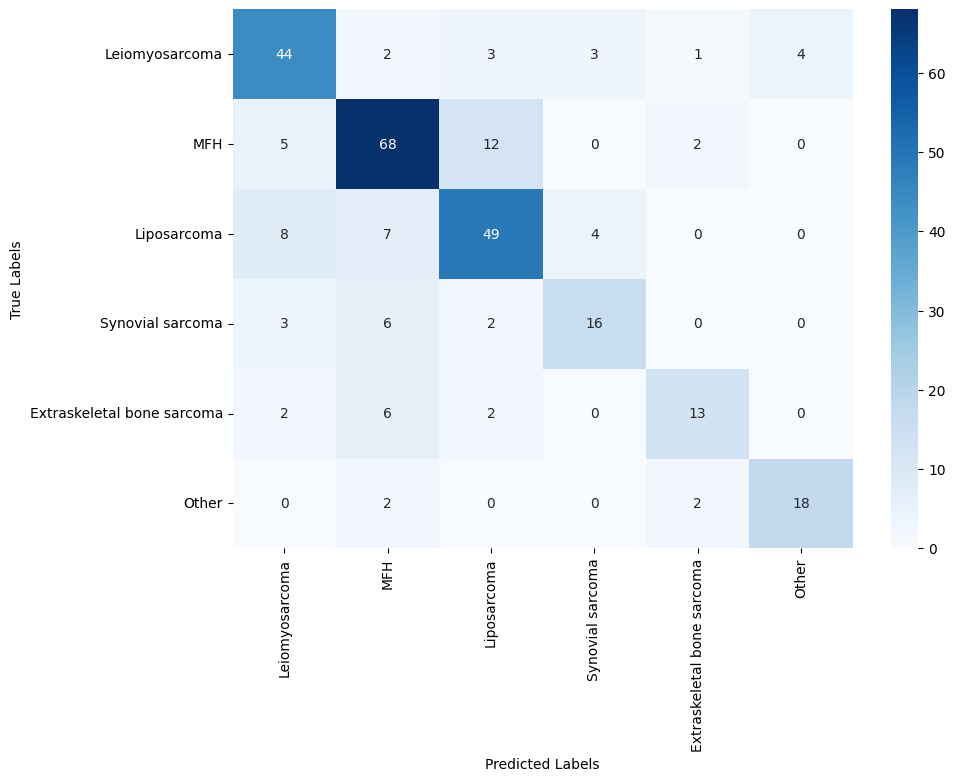

In [264]:
#  evaluate the model
model.evaluate(test_generator)

#  predict the test data
predictions = model.predict(test_generator)

#  get the predicted labels
predicted_labels = np.argmax(predictions, axis=1)

#  get the true labels
true_labels = test_generator.labels

# change the true_labels to the original labels
true_labels = np.argmax(true_labels, axis=1)

predicted_labels =  change_labels(predicted_labels, y_columns)
true_labels = change_labels(true_labels, y_columns)

#  print the classification report
print(classification_report(true_labels, predicted_labels))

#  print macro precision
micro_precision = precision_score(true_labels, predicted_labels, average='macro')
print('Macro Precision: ', micro_precision)

#  print micro precision
micro_precision = precision_score(true_labels, predicted_labels, average='micro')
print('Micro Precision: ', micro_precision)

#  get the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels, labels=y_columns)

#  plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=y_columns, yticklabels=y_columns)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')

##### model History

Text(0.5, 1.0, 'Macro Precision')

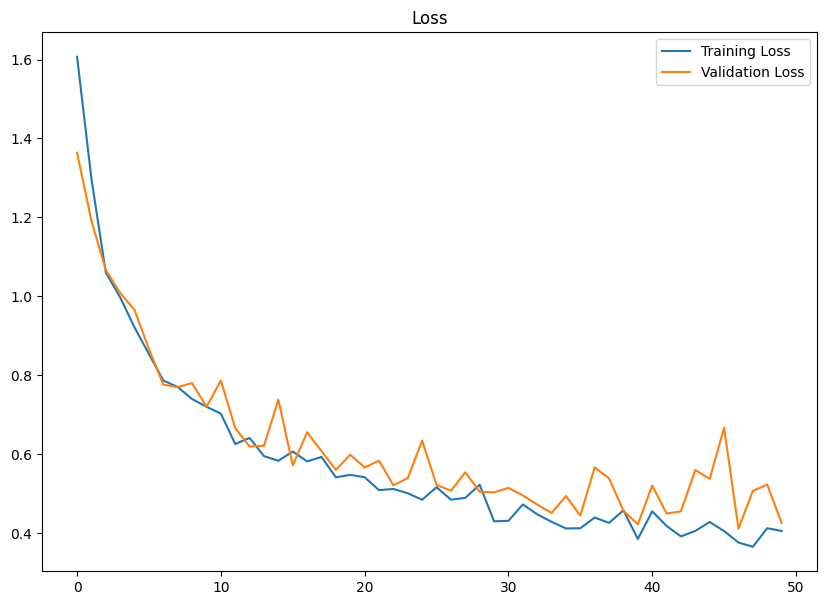

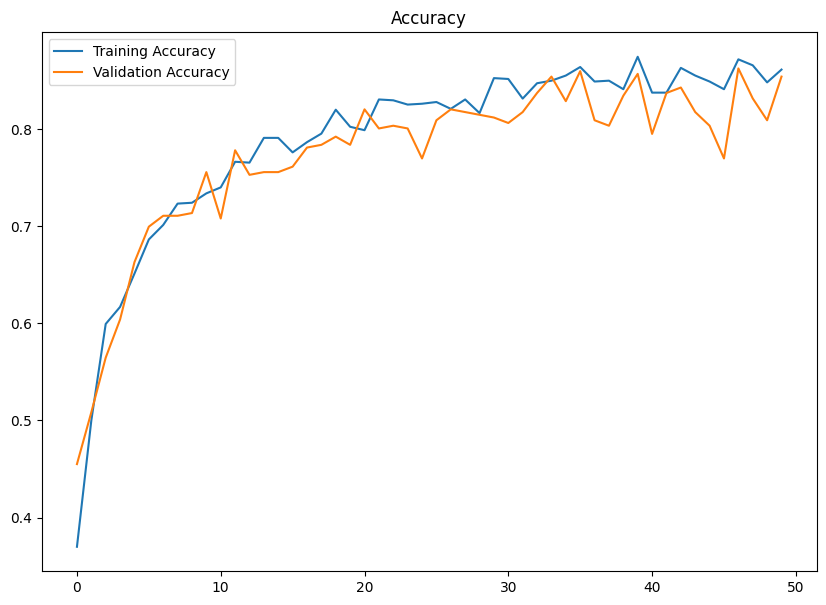

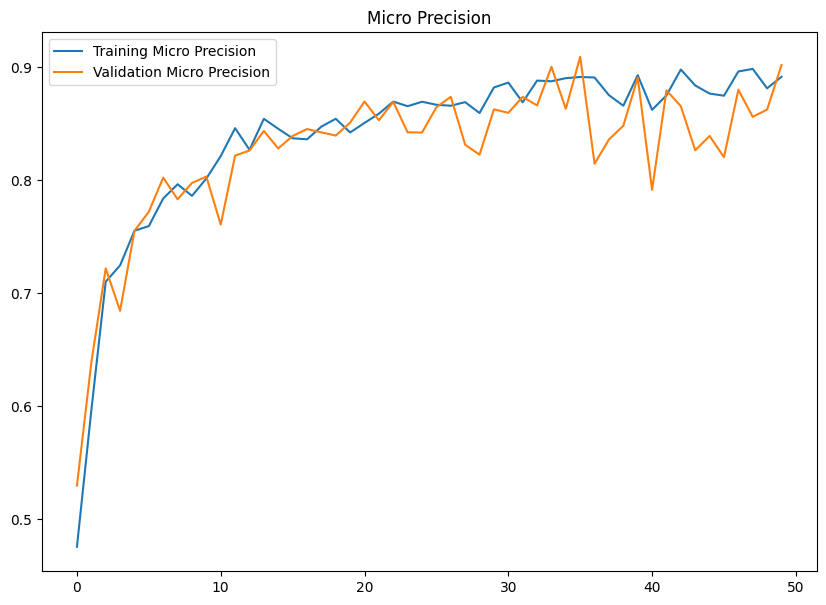

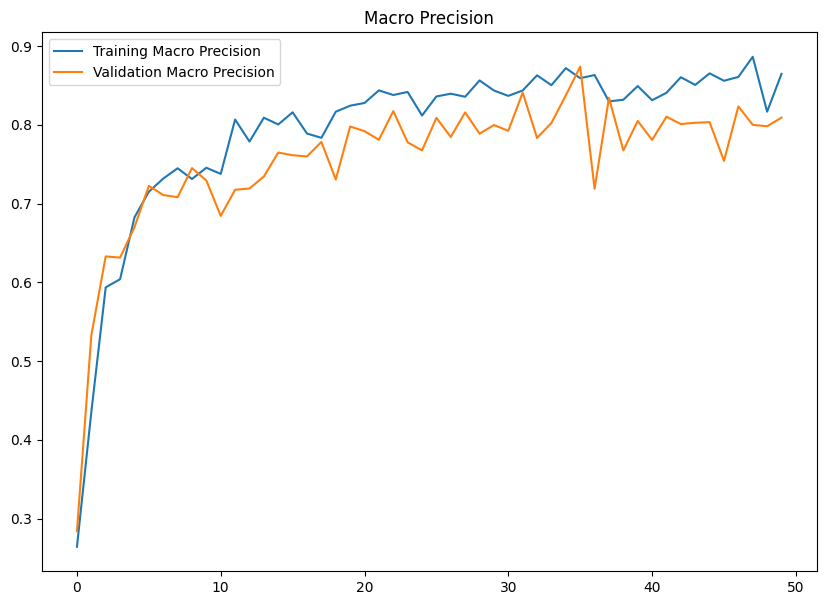

In [265]:
#  plot the loss and accuracy
plt.figure(figsize=(10, 7))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss')

plt.figure(figsize=(10, 7))
plt.plot(history.history['categorical_accuracy'], label='Training Accuracy')
plt.plot(history.history['val_categorical_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')

plt.figure(figsize=(10, 7))
plt.plot(history.history['microprecision'], label='Training Micro Precision')
plt.plot(history.history['val_microprecision'], label='Validation Micro Precision')
plt.legend()
plt.title('Micro Precision')

plt.figure(figsize=(10, 7))
plt.plot(history.history['macroprecision'], label='Training Macro Precision')
plt.plot(history.history['val_macroprecision'], label='Validation Macro Precision')
plt.legend()
plt.title('Macro Precision')

##### Save Model

In [266]:
# save the model
model.save('models\\xception\\xception-tuned-mode.h5')

### xception Cross Validation

In [279]:
xception_macro_precision

[0.8019000167113765,
 0.8289473156180399,
 0.8016849799501121,
 0.8480731816639536,
 0.8327909310894793]

In [268]:
# cross validation
skf = StratifiedKFold(n_splits = 5, shuffle=True, random_state=42)

i = 1
xception_hist = []
xception_accuracy = []
xception_micro_precision = []
xception_macro_precision = []
X = train_df['Image Path']
y = train_df['Label']

for train_index, test_index in skf.split(X, y):
    if i != 1:
        print('\n')
    print('-'*50)
    print('Fold ', i)
    print('-'*50)
    model_checkpoint_cv = tf.keras.callbacks.ModelCheckpoint(
        filepath='tf_checkpoints\\xception\\cv_model\\model_' + str(i),
        monitor='val_loss',
        save_best_only=True,
        save_weights_only=True
    )

    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='loss',
        patience=PAT,
        restore_best_weights=True
    ) 
    
    train_data_cv  = train_df.iloc[train_index]
    test_data_cv  = train_df.iloc[test_index]
    
    train_data_cv, _ = ros.fit_resample(train_data_cv, train_data_cv['Label'])  
    
    train_generator_cv = train_datagen.flow_from_dataframe(
        dataframe=train_data_cv,
        x_col='Image Path',
        y_col= y_columns,
        target_size=(224, 224),
        batch_size=best_hyperparameters.values['batch_size'],
        class_mode='raw',
        shuffle=True,
        seed=42,
        verbose=0
    )

    test_generator_cv = test_datagen.flow_from_dataframe(
        dataframe=test_data_cv,
        x_col='Image Path',
        y_col= y_columns,
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        shuffle=False,
        verbose=0
    )

    xception_tuned_model_cv = tuner.hypermodel.build(best_hyperparameters)

    xception_hist.append(xception_tuned_model_cv.fit(
        train_generator_cv,
        epochs=best_hyperparameters.values['epochs'],
        callbacks=[model_checkpoint, early_stopping],
        validation_data=test_generator_cv,
        verbose=0
    ))

    print('\nModel ' + str(i) + ' evaluation:')
    xception_tuned_model_cv.evaluate(test_generator_cv, verbose=0)
    predictions = xception_tuned_model_cv.predict(test_generator_cv, verbose=0)
    predicted_labels = np.argmax(predictions, axis=1)
    true_labels = test_generator_cv.labels
    true_labels = np.argmax(true_labels, axis=1)
    predicted_labels =  change_labels(predicted_labels, y_columns)
    true_labels = change_labels(true_labels, y_columns)
    #  record the metrics
    xception_accuracy.append(accuracy_score(true_labels, predicted_labels))
    xception_micro_precision.append(precision_score(true_labels, predicted_labels, average='micro'))
    xception_macro_precision.append(precision_score(true_labels, predicted_labels, average='macro'))
    print('Accuracy: ', xception_accuracy[i-1], '\nMicro Precision: ', xception_micro_precision[i-1], '\nMacro Precision: ', xception_macro_precision[i-1])
    i += 1

print('\n')
print('-'*50)
print('Results:')
print('Average accuracy: ', np.mean(xception_accuracy))
print('Average micro precision: ', np.mean(xception_micro_precision))
print('Average macro precision: ', np.mean(xception_macro_precision))

--------------------------------------------------
Fold  1
--------------------------------------------------
Found 1137 validated image filenames.
Found 285 validated image filenames.

Model 1 evaluation:
Accuracy:  0.8035087719298246 
Micro Precision:  0.8035087719298246 
Macro Precision:  0.826327088212334


--------------------------------------------------
Fold  2
--------------------------------------------------
Found 1137 validated image filenames.
Found 285 validated image filenames.

Model 2 evaluation:
Accuracy:  0.8070175438596491 
Micro Precision:  0.8070175438596491 
Macro Precision:  0.8268532522705034


--------------------------------------------------
Fold  3
--------------------------------------------------
Found 1138 validated image filenames.
Found 284 validated image filenames.

Model 3 evaluation:
Accuracy:  0.7746478873239436 
Micro Precision:  0.7746478873239436 
Macro Precision:  0.8050312501396094


--------------------------------------------------
Fold  4


## DenseNet Model

In [270]:
# change batch size back to 32
train_generator.batch_size = 32

# dense net
#  create the model
dense_net = tf.keras.applications.DenseNet121(
    include_top=False,
    weights='imagenet',
    input_shape=(224, 224, 3)
)

#  freeze the layers
dense_net.trainable = False

29084464/29084464 [==============================] - 3s 0us/step


### DenseNet attempt without hyperparameter tuning

#### Model Building

In [271]:
#  create the model
model = tf.keras.Sequential([
    dense_net,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(6, activation='softmax')
])

#  compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=[tf.keras.metrics.CategoricalAccuracy(), macroprecision, microprecision]
)

#  create the callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=PAT,
    restore_best_weights=True
)

# create the model checkpoint
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath='tf_checkpoints\\DenseNet\\model_checkpoint',
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=True
)

# reset the generators
train_generator.reset()
test_generator.reset()

# fit the model
history = model.fit(
    train_generator,
    validation_data=test_generator,
    epochs=100,
    callbacks=[model_checkpoint, early_stopping]
)

# reset the generators
train_generator.reset()
test_generator.reset()

Epoch 1/100
36/36 [==============================] - 19s 395ms/step - loss: 10.4424 - categorical_accuracy: 0.2891 - macroprecision: 0.1831 - microprecision: 0.2898 - val_loss: 8.6085 - val_categorical_accuracy: 0.3034 - val_macroprecision: 0.2096 - val_microprecision: 0.3002
Epoch 2/100
36/36 [==============================] - 13s 349ms/step - loss: 3.6539 - categorical_accuracy: 0.4376 - macroprecision: 0.3900 - microprecision: 0.4416 - val_loss: 1.7419 - val_categorical_accuracy: 0.5506 - val_macroprecision: 0.4655 - val_microprecision: 0.5735
Epoch 3/100
36/36 [==============================] - 12s 336ms/step - loss: 2.4556 - categorical_accuracy: 0.5387 - macroprecision: 0.5379 - microprecision: 0.5504 - val_loss: 2.0872 - val_categorical_accuracy: 0.5506 - val_macroprecision: 0.5574 - val_microprecision: 0.5765
Epoch 4/100
36/36 [==============================] - 13s 358ms/step - loss: 1.9631 - categorical_accuracy: 0.5773 - macroprecision: 0.5670 - microprecision: 0.5886 - val_l

#### Model Classification Report

9/9 [==============================] - 2s 83ms/step
                            precision    recall  f1-score   support

Extraskeletal bone sarcoma       1.00      0.65      0.79        23
            Leiomyosarcoma       0.74      0.86      0.80        57
               Liposarcoma       0.86      0.72      0.78        68
                       MFH       0.84      0.74      0.79        87
                     Other       0.95      0.86      0.90        22
          Synovial sarcoma       0.40      0.74      0.52        27

                  accuracy                           0.76       284
                 macro avg       0.80      0.76      0.76       284
              weighted avg       0.81      0.76      0.77       284

Macro Precision:  0.7990297713981925
Micro Precision:  0.7605633802816901


Text(95.7222222222222, 0.5, 'True Labels')

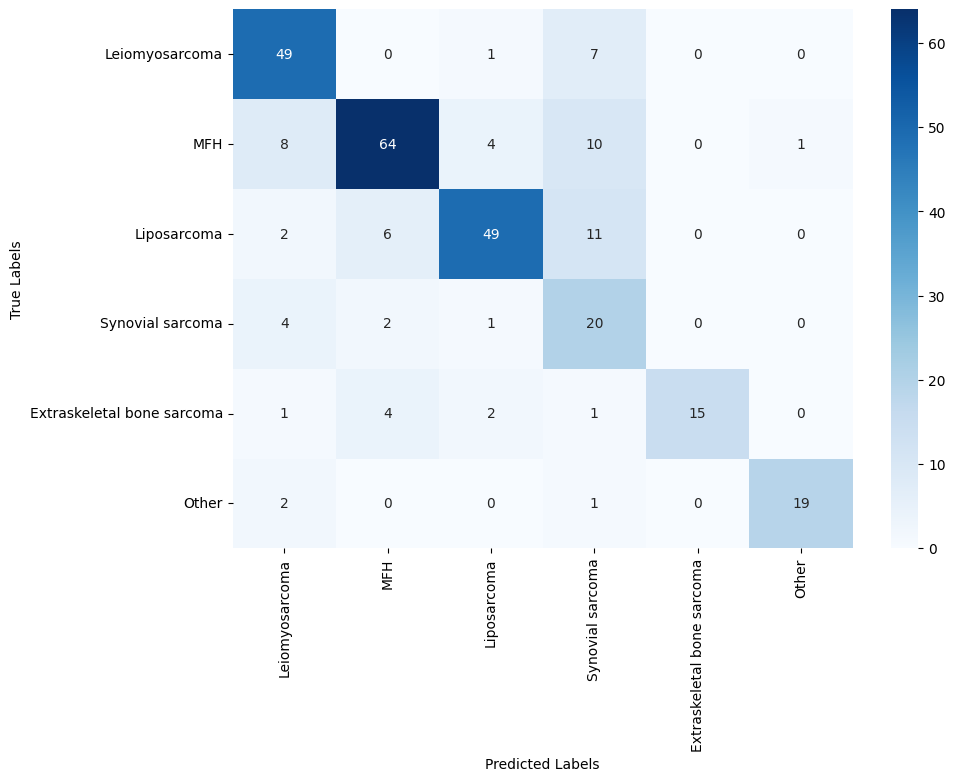

In [272]:
#  evaluate the model
model.evaluate(test_generator)

#  predict the test data
predictions = model.predict(test_generator)

#  get the predicted labels
predicted_labels = np.argmax(predictions, axis=1)

#  get the true labels
true_labels = test_generator.labels

# change the true_labels to the original labels
true_labels = np.argmax(true_labels, axis=1)

predicted_labels =  change_labels(predicted_labels, y_columns)
true_labels = change_labels(true_labels, y_columns)

#  print the classification report
print(classification_report(true_labels, predicted_labels))

#  print macro precision
micro_precision = precision_score(true_labels, predicted_labels, average='macro')
print('Macro Precision: ', micro_precision)

#  print micro precision
micro_precision = precision_score(true_labels, predicted_labels, average='micro')
print('Micro Precision: ', micro_precision)

#  get the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels, labels=y_columns)

#  plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=y_columns, yticklabels=y_columns)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')

#### Model History

Text(0.5, 1.0, 'Macro Precision')

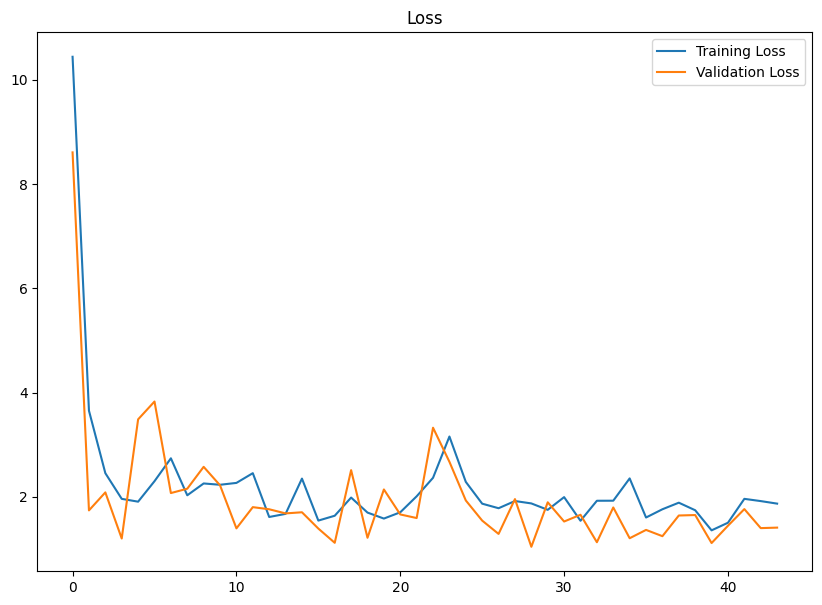

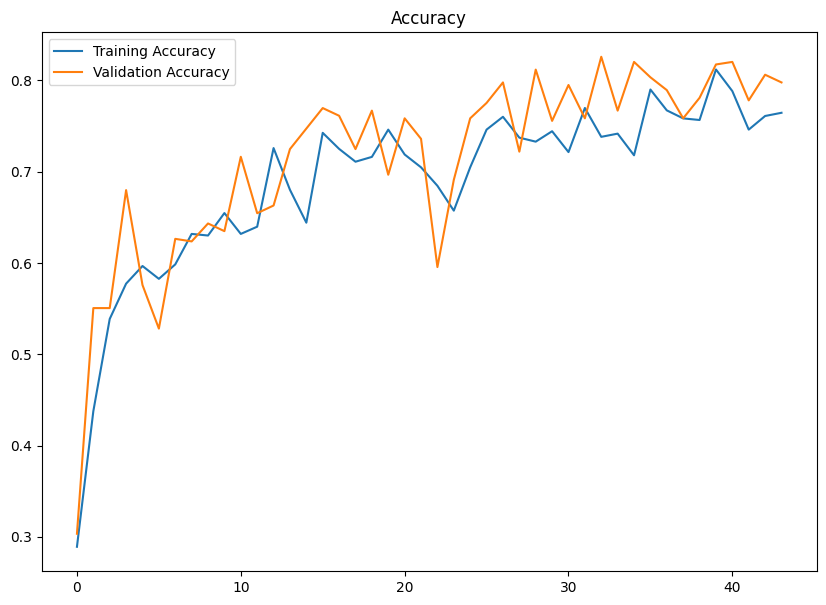

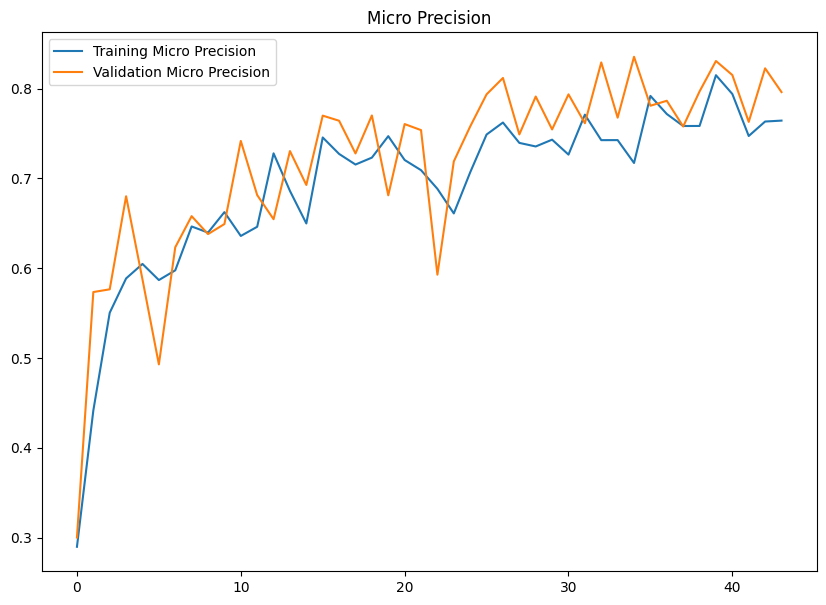

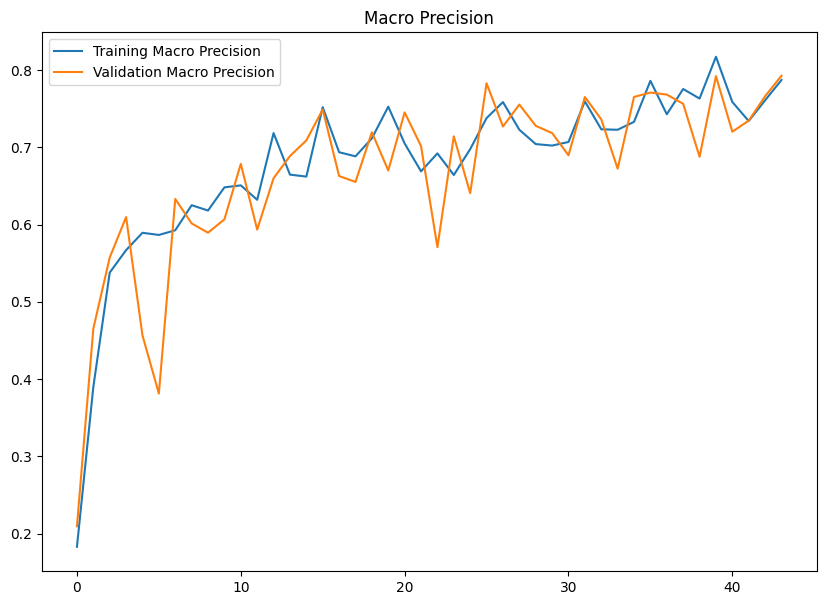

In [273]:
#  plot the loss and accuracy
plt.figure(figsize=(10, 7))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss')

plt.figure(figsize=(10, 7))
plt.plot(history.history['categorical_accuracy'], label='Training Accuracy')
plt.plot(history.history['val_categorical_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')

plt.figure(figsize=(10, 7))
plt.plot(history.history['microprecision'], label='Training Micro Precision')
plt.plot(history.history['val_microprecision'], label='Validation Micro Precision')
plt.legend()
plt.title('Micro Precision')

plt.figure(figsize=(10, 7))
plt.plot(history.history['macroprecision'], label='Training Macro Precision')
plt.plot(history.history['val_macroprecision'], label='Validation Macro Precision')
plt.legend()
plt.title('Macro Precision')

#### Save Model

In [274]:
# save the model
model.save('models\\DenseNet\\DenseNet-model-test.h5')

### DenseNet attempt with hyperparameter tuning

#### Define DenseNet model class

In [275]:
class DenseNet_class(HyperModel):
    def build(self, hp):
        dense_net = tf.keras.applications.DenseNet121(
            include_top=False,
            weights='imagenet',
            input_shape=(224, 224, 3)
        )
        dense_net.trainable = False
        model = tf.keras.models.Sequential([
            dense_net,
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dropout(hp.Float('dropout_rate', 0, 0.5, step=0.1)),
            tf.keras.layers.Dense(6, activation='softmax')
        ])
        optimizer = tf.keras.optimizers.Adam(learning_rate=hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4]))
        model.compile(optimizer=optimizer, 
                        loss=tf.keras.losses.CategoricalCrossentropy(), 
                        metrics=[tf.keras.metrics.CategoricalAccuracy(), macroprecision, microprecision])
        return model
    
    def fit(self, hp, model, *args, **kwargs):
        train_generator.batch_size = hp.Choice("batch_size", [32, 64, 128])
        return model.fit(
            *args,
            epochs=hp.Choice("epochs", [50, 75, 100]),
            **kwargs,
        )

#### Random search for hyperparameter tuning

In [276]:
#  create the callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=TUNING_PAT,
    restore_best_weights=True
)

#  create the tuner
tuner = RandomSearch(
    hypermodel = DenseNet_class(),
    objective='val_loss',
    seed=42,
    max_trials=50,
    executions_per_trial=2,
    overwrite=True,
    directory='models\\DenseNet\\random_search',
    project_name='DenseNet'
)

#  search for the best hyperparameters
tuner.search(
    train_generator,
    validation_data = test_generator,
    callbacks=[early_stopping],
)

Trial 50 Complete [00h 04m 36s]
val_loss: 1.4124618768692017

Best val_loss So Far: 0.35750818252563477
Total elapsed time: 05h 48m 07s
INFO:tensorflow:Oracle triggered exit


#### Tuning results

In [277]:
tuner.results_summary()

Results summary
Results in models\DenseNet\random_search\DenseNet
Showing 10 best trials
Objective(name="val_loss", direction="min")

Trial 13 summary
Hyperparameters:
dropout_rate: 0.2
learning_rate: 0.0001
batch_size: 64
epochs: 100
Score: 0.35750818252563477

Trial 33 summary
Hyperparameters:
dropout_rate: 0.0
learning_rate: 0.0001
batch_size: 128
epochs: 100
Score: 0.38075679540634155

Trial 07 summary
Hyperparameters:
dropout_rate: 0.30000000000000004
learning_rate: 0.0001
batch_size: 128
epochs: 50
Score: 0.40587568283081055

Trial 16 summary
Hyperparameters:
dropout_rate: 0.4
learning_rate: 0.0001
batch_size: 128
epochs: 50
Score: 0.45018817484378815

Trial 25 summary
Hyperparameters:
dropout_rate: 0.2
learning_rate: 0.0001
batch_size: 32
epochs: 75
Score: 0.4512881338596344

Trial 20 summary
Hyperparameters:
dropout_rate: 0.4
learning_rate: 0.0001
batch_size: 64
epochs: 50
Score: 0.47975948452949524

Trial 35 summary
Hyperparameters:
dropout_rate: 0.1
learning_rate: 0.0001
batc

In [278]:
#  get the best hyperparameters
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]
best_hyperparameters.values

{'dropout_rate': 0.2, 'learning_rate': 0.0001, 'batch_size': 64, 'epochs': 100}

#### Build the model with the best hyperparameters

##### Model Building

In [283]:
# Build the model with the best hyperparameters
densenet_tuned_model = tuner.hypermodel.build(best_hyperparameters)

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath='tf_checkpoints\\DenseNet\\tuning_model',
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=True
)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='loss',
    patience=PAT,
    restore_best_weights=True
) 

train_generator.batch_size = best_hyperparameters.values['batch_size']

#  fit the model
history = densenet_tuned_model.fit(
    train_generator,
    validation_data=test_generator,
    epochs = best_hyperparameters.values['epochs'],
    callbacks=[model_checkpoint, early_stopping]
)
# reset the generators
train_generator.reset()
test_generator.reset()

Epoch 1/100
36/36 [==============================] - 19s 409ms/step - loss: 2.4008 - categorical_accuracy: 0.2891 - macroprecision: 0.2155 - microprecision: 0.3056 - val_loss: 1.9504 - val_categorical_accuracy: 0.3483 - val_macroprecision: 0.2130 - val_microprecision: 0.3629
Epoch 2/100
36/36 [==============================] - 12s 343ms/step - loss: 1.7331 - categorical_accuracy: 0.3946 - macroprecision: 0.3303 - microprecision: 0.4332 - val_loss: 1.5552 - val_categorical_accuracy: 0.4354 - val_macroprecision: 0.3391 - val_microprecision: 0.5108
Epoch 3/100
36/36 [==============================] - 11s 314ms/step - loss: 1.5662 - categorical_accuracy: 0.4455 - macroprecision: 0.3919 - microprecision: 0.5036 - val_loss: 1.4573 - val_categorical_accuracy: 0.4635 - val_macroprecision: 0.3002 - val_microprecision: 0.4646
Epoch 4/100
36/36 [==============================] - 11s 316ms/step - loss: 1.4685 - categorical_accuracy: 0.4895 - macroprecision: 0.5053 - microprecision: 0.5428 - val_lo

##### Model Classification Report

9/9 [==============================] - 2s 66ms/step
                            precision    recall  f1-score   support

Extraskeletal bone sarcoma       1.00      0.61      0.76        23
            Leiomyosarcoma       0.71      0.91      0.80        57
               Liposarcoma       0.88      0.72      0.79        68
                       MFH       0.80      0.84      0.82        87
                     Other       1.00      0.68      0.81        22
          Synovial sarcoma       0.63      0.81      0.71        27

                  accuracy                           0.79       284
                 macro avg       0.84      0.76      0.78       284
              weighted avg       0.82      0.79      0.79       284

Macro Precision:  0.8363496663154196
Micro Precision:  0.7922535211267606


Text(95.7222222222222, 0.5, 'True Labels')

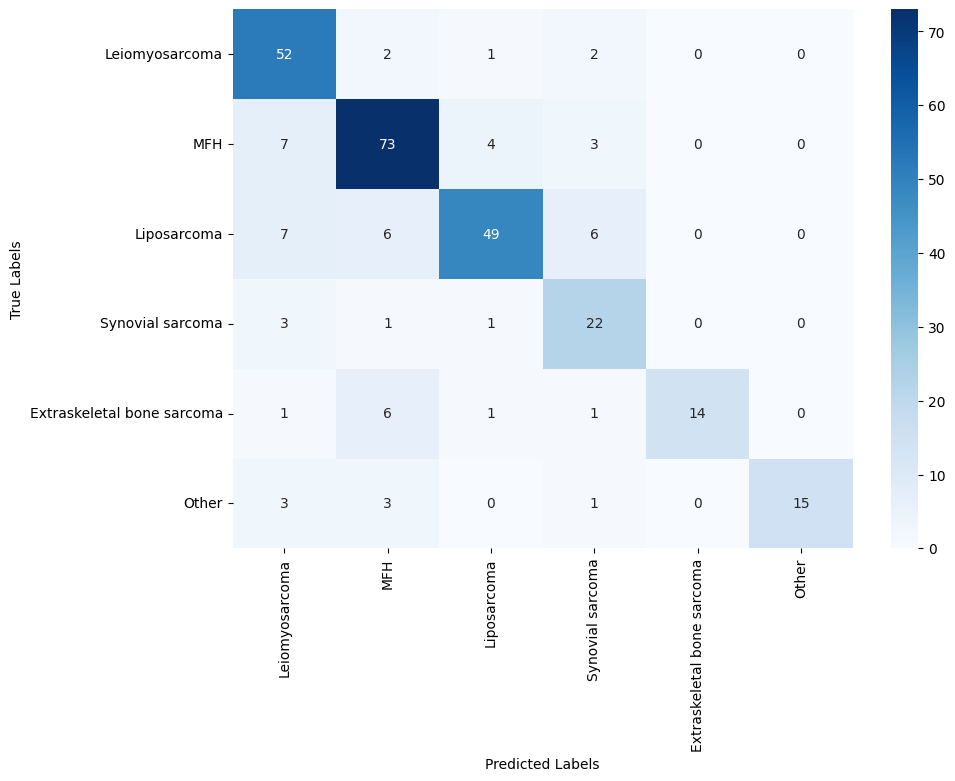

In [284]:
#  evaluate the model
densenet_tuned_model.evaluate(test_generator)

#  predict the test data
predictions = densenet_tuned_model.predict(test_generator)

#  get the predicted labels
predicted_labels = np.argmax(predictions, axis=1)

#  get the true labels
true_labels = test_generator.labels

# change the true_labels to the original labels
true_labels = np.argmax(true_labels, axis=1)

predicted_labels =  change_labels(predicted_labels, y_columns)
true_labels = change_labels(true_labels, y_columns)

#  print the classification report
print(classification_report(true_labels, predicted_labels))

#  print macro precision
micro_precision = precision_score(true_labels, predicted_labels, average='macro')
print('Macro Precision: ', micro_precision)

#  print micro precision
micro_precision = precision_score(true_labels, predicted_labels, average='micro')
print('Micro Precision: ', micro_precision)

#  get the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels, labels=y_columns)

#  plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=y_columns, yticklabels=y_columns)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')

##### Model History

Text(0.5, 1.0, 'Macro Precision')

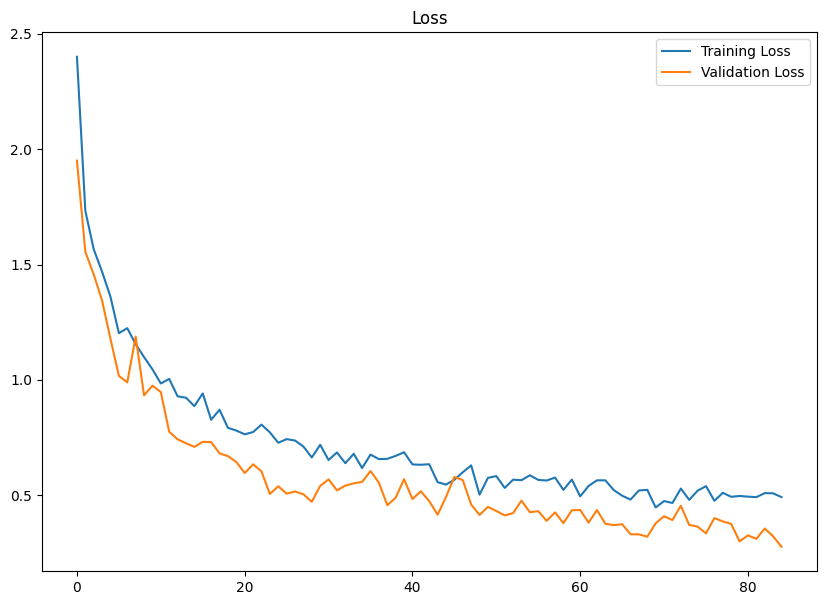

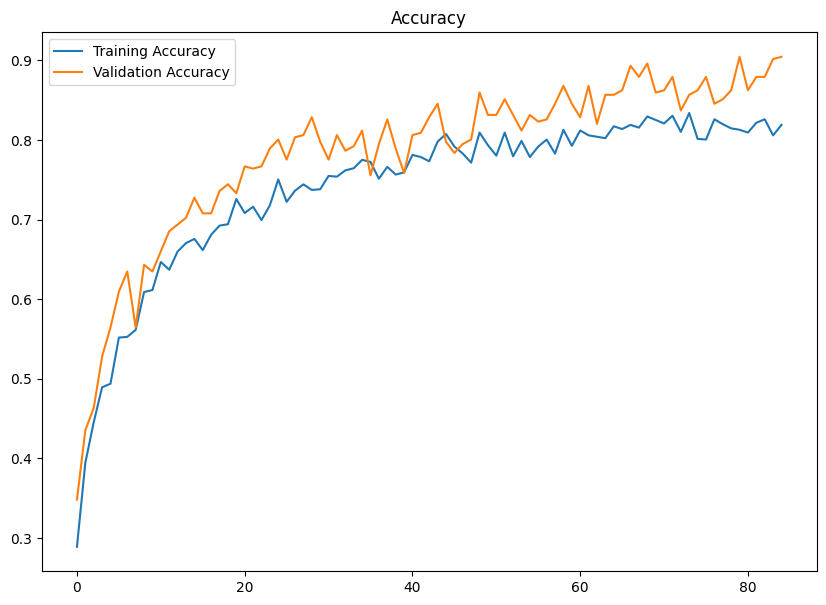

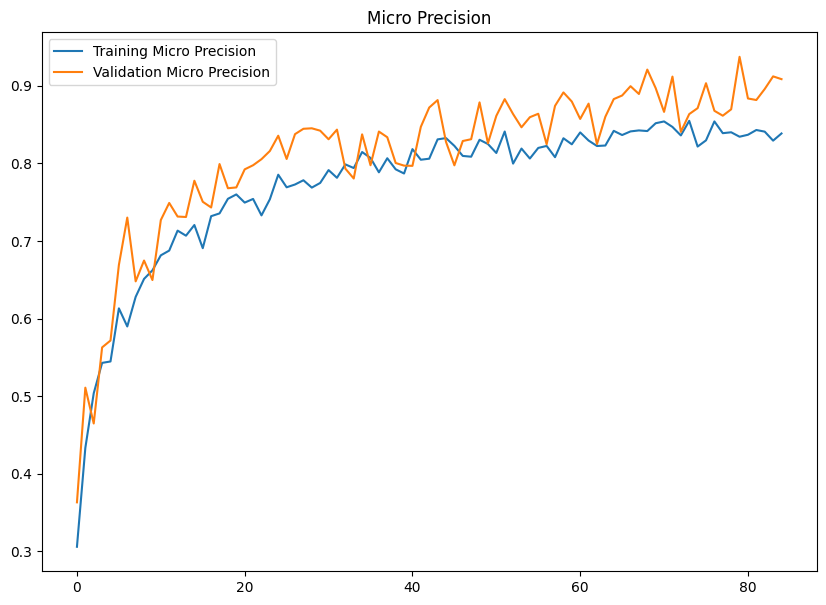

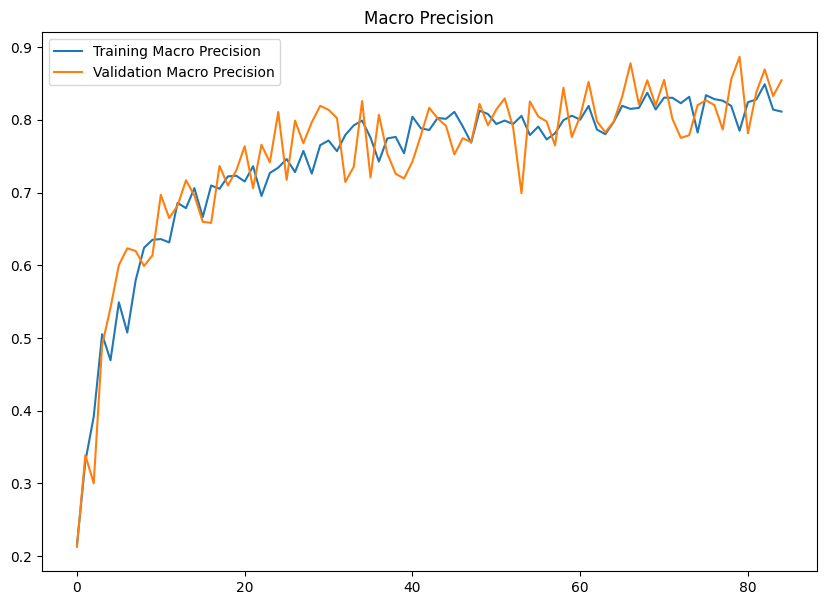

In [285]:
#  plot the loss and accuracy
plt.figure(figsize=(10, 7))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss')

plt.figure(figsize=(10, 7))
plt.plot(history.history['categorical_accuracy'], label='Training Accuracy')
plt.plot(history.history['val_categorical_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')

plt.figure(figsize=(10, 7))
plt.plot(history.history['microprecision'], label='Training Micro Precision')
plt.plot(history.history['val_microprecision'], label='Validation Micro Precision')
plt.legend()
plt.title('Micro Precision')

plt.figure(figsize=(10, 7))
plt.plot(history.history['macroprecision'], label='Training Macro Precision')
plt.plot(history.history['val_macroprecision'], label='Validation Macro Precision')
plt.legend()
plt.title('Macro Precision')

##### Save Model

In [286]:
# save the model
densenet_tuned_model.save('models\\DenseNet\\DenseNet-model-tuned.h5')

### DenseNet Cross Validation

In [288]:
# cross validation
skf = StratifiedKFold(n_splits = 5, shuffle=True, random_state=42)

i = 1
densenet_hist = []
densenet_accuracy = []
densenet_micro_precision = []
densenet_macro_precision = []
X = train_df['Image Path']
y = train_df['Label']

for train_index, test_index in skf.split(X, y):
    if i != 1:
        print('\n')
    print('-'*50)
    print('Fold ', i)
    print('-'*50)
    model_checkpoint_cv = tf.keras.callbacks.ModelCheckpoint(
        filepath='tf_checkpoints\\DenseNet\\cv_model\\model_' + str(i),
        monitor='val_loss',
        save_best_only=True,
        save_weights_only=True
    )

    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='loss',
        patience=PAT,
        restore_best_weights=True
    ) 
    
    train_data_cv  = train_df.iloc[train_index]
    test_data_cv  = train_df.iloc[test_index]
    
    train_data_cv, _ = ros.fit_resample(train_data_cv, train_data_cv['Label'])  
    
    train_generator_cv = train_datagen.flow_from_dataframe(
        dataframe=train_data_cv,
        x_col='Image Path',
        y_col= y_columns,
        target_size=(224, 224),
        batch_size=best_hyperparameters.values['batch_size'],
        class_mode='raw',
        shuffle=True,
        seed=42,
        verbose=0
    )

    test_generator_cv = test_datagen.flow_from_dataframe(
        dataframe=test_data_cv,
        x_col='Image Path',
        y_col= y_columns,
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        shuffle=False,
        verbose=0
    )

    densenet_tuned_model_cv = tuner.hypermodel.build(best_hyperparameters)

    densenet_hist.append(densenet_tuned_model_cv.fit(
        train_generator_cv,
        epochs=best_hyperparameters.values['epochs'],
        callbacks=[model_checkpoint, early_stopping],
        validation_data=test_generator_cv,
        verbose=0
    ))

    print('\nModel ' + str(i) + ' evaluation:')
    densenet_tuned_model_cv.evaluate(test_generator_cv, verbose=0)
    predictions = densenet_tuned_model_cv.predict(test_generator_cv, verbose=0)
    predicted_labels = np.argmax(predictions, axis=1)
    true_labels = test_generator_cv.labels
    true_labels = np.argmax(true_labels, axis=1)
    predicted_labels =  change_labels(predicted_labels, y_columns)
    true_labels = change_labels(true_labels, y_columns)
    #  record the metrics
    densenet_accuracy.append(accuracy_score(true_labels, predicted_labels))
    densenet_micro_precision.append(precision_score(true_labels, predicted_labels, average='micro'))
    densenet_macro_precision.append(precision_score(true_labels, predicted_labels, average='macro'))
    print('Accuracy: ', densenet_accuracy[i-1], '\nMicro Precision: ', densenet_micro_precision[i-1], '\nMacro Precision: ', densenet_macro_precision[i-1])
    i += 1

print('\n')
print('-'*50)
print('Results:')
print('Average accuracy: ', np.mean(densenet_accuracy))
print('Average micro precision: ', np.mean(densenet_micro_precision))
print('Average macro precision: ', np.mean(densenet_macro_precision))

--------------------------------------------------
Fold  1
--------------------------------------------------
Found 1137 validated image filenames.
Found 285 validated image filenames.

Model 1 evaluation:
Accuracy:  0.8350877192982457 
Micro Precision:  0.8350877192982457 
Macro Precision:  0.8585469658691113


--------------------------------------------------
Fold  2
--------------------------------------------------
Found 1137 validated image filenames.
Found 285 validated image filenames.

Model 2 evaluation:
Accuracy:  0.8245614035087719 
Micro Precision:  0.8245614035087719 
Macro Precision:  0.8861436611436612


--------------------------------------------------
Fold  3
--------------------------------------------------
Found 1138 validated image filenames.
Found 284 validated image filenames.

Model 3 evaluation:
Accuracy:  0.8626760563380281 
Micro Precision:  0.8626760563380281 
Macro Precision:  0.8627269727220227


--------------------------------------------------
Fold  4

# END